<a href="https://colab.research.google.com/github/stivenbg/Basics_ML/blob/main/Deepoonets_biais_aware_DA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import scipy.io as io
import os
import matplotlib.pyplot as plt
import time
import scipy.io as io
import sys
import matplotlib.gridspec as gridspec
import torch.nn.init as init


In [2]:
sys.path.insert(0, 'Utilities/')
import os

# from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

np.random.seed(42)
import sys
import torch.nn as nn
import torch.optim as optim

In [3]:
data2 = io.loadmat('/content/train_501_mu2_pod1')
datatest = io.loadmat('/content/test_501_mu2_pod1_v2.mat')

In [4]:
#Data
# %% ici le train cest le test, normalement ca devrait bien fonctionner ensutie je change le test
#u_train, v_train, x_train, y_train, u_test, v_test = data2['utrain'].T, data2['vtrain'].T, data2['xtrain'], data2['ytrain'], data2['utest'].T, data2['vtest'].T
u_train, v_train, x_train, y_train = data2['utrain'].T, data2['vtrain'].T, data2['xtrain'], data2['ytrain']

# %%
#u_train = np.reshape(u_train, (101, 40))
#u_train.shape
# %%
#v_train = v_train * 5
v_train.shape
# %%
x_train.shape
# %%
y_train.shape
# %%
x_y_train = np.hstack([x_train, y_train])
# %%
x_y_train = x_y_train
# %%
x_y_train.shape
# %%
u_test = datatest['utest']
u_test = u_test.T
u_test.shape
#%%
#u_test = u_train
u_test.shape

# %%
#v_test = v_train

v_test = datatest['vtest']
v_test = v_test.T
v_test.shape

# #%% test on non scaled data
# v2 = data2['vtest']
# v2 = v_test.T
# #v_test = v_test * 5
# v2.shape
#%%

#x_test, y_test = x_train, y_train
#%%
#x_test.shape
#y_test.shape

# %%
x_test = datatest['xtest']
x_test.shape
 # %%
y_test = datatest['ytest']
y_test.shape
# %%
x_y_test = np.hstack([x_test, y_test])
x_y_test.shape
#%%
x_y_test.shape

(40, 2)

In [33]:
#modele
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()

    # Initialization for DNNs
    def hyper_initial(self, layers):
        L = len(layers)
        W = []
        b = []
        for l in range(1, L):
            in_dim = layers[l - 1]
            out_dim = layers[l]
            std = np.sqrt(2.0 / (in_dim + out_dim))
            weight = nn.Parameter(torch.randn(in_dim, out_dim) * std)
            bias = nn.Parameter(torch.randn(1, out_dim) * std)
            W.append(weight)
            b.append(bias)
        return W, b

    def fnn_B(self, X, W, b):
        A = X
        L = len(W)
        for i in range(L - 1):
            A = torch.tanh(torch.matmul(A, W[i]) + b[i])
        Y = torch.matmul(A, W[-1]) + b[-1]
        return Y

    def fnn_T(self, X, W, b):
        A = X
        L = len(W)
        for i in range(L - 1):
            A = torch.tanh(torch.matmul(A, W[i]) + b[i])
        Y = torch.matmul(A, W[-1]) + b[-1]
        return Y


u_dim = 40
# Output dimension for Branch and Trunk Net
G_dim = 40
# Branch Net
layers_f = [u_dim] + [40] * 7 + [G_dim]
# Trunk dim
x_dim = 2
# Trunk Net
layers_x = [x_dim] + [40] * 7 + [G_dim]
model = DNN()

In [34]:

B_values = [-0.3459, -0.7421, -0.3391, -0.8532, -0.3048, -0.4194, -0.2397, -0.7632, -0.7112, -0.4430, -0.3836, -0.9075, -0.9155, -0.5346, -0.3763, -0.4993, -0.3200, -0.4221, -0.3184, -0.3640, -0.5890, -0.2932, -0.6207, -0.4214, -0.4484, -0.7744, -0.3246, -0.8052, -0.3483, -0.3869, -0.8546, -0.3238, -0.2879, -0.9148, -0.8857, -0.8965, -0.6248, -0.3008, -0.5907, -0.3535]

#B = np.array(B_values,dtype=np.float32).reshape(40, 1)
B = torch.from_numpy(np.array(B_values, dtype=np.float32).reshape(40, 1))

B_tensor = torch.tensor(B)

<ipython-input-34-652ec0091785>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  B_tensor = torch.tensor(B)


B_values = [-0.3459, -0.7421, -0.3391, -0.8532, -0.3048, -0.4194, -0.2397, -0.7632,
    -0.7112, -0.4430, -0.3836, -0.9075, -0.9155, -0.5346, -0.3763, -0.4993,
    -0.3200, -0.4221, -0.3184, -0.3640, -0.5890, -0.2932, -0.6207, -0.4214,
    -0.4484, -0.7744, -0.3246, -0.8052, -0.3483, -0.3869, -0.8546, -0.3238,
    -0.2879, -0.9148, -0.8857, -0.8965, -0.6248, -0.3008, -0.5907, -0.3535]

B = np.array(B_values).reshape(40, 1)


In [35]:
def train_step(model, W_branch, b_branch, W_trunk, b_trunk, v, x, u, optimizer):
    train_vars = W_branch + b_branch + W_trunk + b_trunk
    optimizer.zero_grad()
    u_out_branch = model.fnn_B(v, W_branch, b_branch)
    u_out_trunk = model.fnn_T(x, W_trunk, b_trunk)
    # u_pred = torch.einsum('ij,jj->ij', u_out_branch, u_out_trunk)
    u_pred = torch.einsum('ij,kj->ik', u_out_branch, u_out_trunk)

    mu = 2
    epsilon = 0.01

    inputs = torch.ones(40, 1) # faire attention à cette ligne parce qu'elle definit la dimension de l'input. A chaque fois qu'on change la dimn  de l'input changer la dim ici
    u_1 = u_pred
    #     u_1 = u_1.reshape(-1, 1)
    residual = 0.0
     #for i in range(len(u_pred)):
        # u1 = u_pred[i, :]
         # = u1.T
         #u1 = u1.reshape(-1, 1)

        #grad_u = torch.autograd.grad(u1, x, grad_outputs=inputs, create_graph=True)[0]
         #u_x = grad_u[:, 0].reshape(-1, 1)

         #u_y = grad_u[:, 1].reshape(-1, 1)

         #grad_u_x = torch.autograd.grad(u_x, x, grad_outputs=inputs, create_graph=True)[0]
         #u_xx = grad_u_x[:, 0].reshape(-1, 1)

         #grad_u_y = torch.autograd.grad(u_y, x, grad_outputs=inputs, create_graph=True)[0]
         #u_yy = grad_u_y[:, 1].reshape(-1, 1)

        # v1 = v.T
        # v1 = v1[:, i].reshape(-1, 1)

         #laplacian = u_xx + u_yy
         #res_loss = - np.sqrt(1 + (epsilon * mu) ** 2) * laplacian.reshape(-1, ) - mu ** 2 * u1.reshape(
         #    -1, ) - v1.reshape(-1, )  ##pde loss ici dans v y'a deja mu donc on eleve mu devant
         #residual += res_loss
    #         residual.append(res_loss)

    #     x1 = x[:,0]
    #     x1 = x1.reshape((-1,1))
    #     expanded_x = x1.expand(-1, 100)

    #     y1 = x[:,1]
    #     y1 = y1.reshape((-1,1))
    #     expanded_y = y1.expand(-1, 100)

    #     grad_u_hat = torch.autograd.grad(u_1, expanded_x, grad_outputs=inputs, create_graph=True, allow_unused=True)[0]
    #     u_x = grad_u_hat

    #     u_y = torch.autograd.grad(u_1, expanded_y, grad_outputs=inputs, create_graph=True, allow_unused=True)[0]

    # #     u_y = grad_u_hat[:, 1].reshape(-1,1)

    #     u_xx = torch.autograd.grad(u_x, expanded_x, grad_outputs=inputs, create_graph=True, allow_unused=True)[0]

    #     u_yy = torch.autograd.grad(u_y, expanded_y, grad_outputs=inputs, create_graph=True, allow_unused=True)[0]

    # #     grad_u_x = torch.autograd.grad(u_x, x, grad_outputs=inputs, create_graph=True)[0]
    # #     u_xx = grad_u_x[:, 0].reshape(-1,1)

    # #     grad_u_y = torch.autograd.grad(u_y, x, grad_outputs=inputs, create_graph=True)[0]
    # #     u_yy = grad_u_y[:, 1].reshape(-1,1)

    #     v_1 = v.T
    # #     v_1 = v_1[:, 0].reshape(-1, 1)

    #     laplacian = u_xx+u_yy
    #     res_loss = np.sqrt(1+(epsilon*mu)**2)*laplacian.reshape(-1,)-mu**2*u_1.reshape(-1,)-mu*v_1.reshape(-1,)  ##pde loss

    #     residual = f_net(model, x, v, W_branch, b_branch, W_trunk, b_trunk)

    #     residual = np.array(residual, dtype = np.float32)
    #     residual = residual.reshape(-1,1)
    #loss_pde = torch.mean(torch.abs(residual)) #utiliser abs c'est MAE, plutôt que square pour mse
    data_loss = torch.mean(torch.square(u_pred - u))
    #ortho = np.dot(u_pred[-1,:], B)
    loss_ortho = torch.mean(torch.matmul(u_pred[-1,:], B))


    #loss = data_loss + 0.00005*loss_pde
    #loss = loss_pde
    #loss = data_loss + ortho


    loss = torch.mean(torch.square(u_pred - u)) + 0.00001*torch.abs(loss_ortho)
    loss.backward()
    optimizer.step()
    return loss.item(), u_pred.detach(), loss_ortho.item(), data_loss.item()
    #return loss.item(), u_pred.detach(), data_loss.item()


def test_step(model, W_branch, b_branch, W_trunk, b_trunk, v, x, u, optimizer):
    x_test_tensor = torch.from_numpy(x).float()
    v_test_tensor = torch.from_numpy(v).float()
    u_test_tensor = torch.from_numpy(u).float()

    with torch.no_grad():
        u_out_branch = model.fnn_B(v_test_tensor, W_branch, b_branch)
        u_out_trunk = model.fnn_T(x_test_tensor, W_trunk, b_trunk)
        # u_pred = torch.einsum('ij,jj->ij', u_out_branch, u_out_trunk)
        u_pred = torch.einsum('ij,kj->ik', u_out_branch, u_out_trunk)

        loss = torch.mean(torch.square(u_pred - u_test_tensor))

    return loss.item(), u_pred.detach().numpy()

In [36]:
#Initialisation
W_branch, b_branch = model.hyper_initial(layers_f)
W_trunk, b_trunk = model.hyper_initial(layers_x)

In [37]:
model = DNN()

Iteration: 0 Train_loss:0.0014931227779015899, Test_loss: 0.007099655922502279, ortho_loss:0.05461151525378227


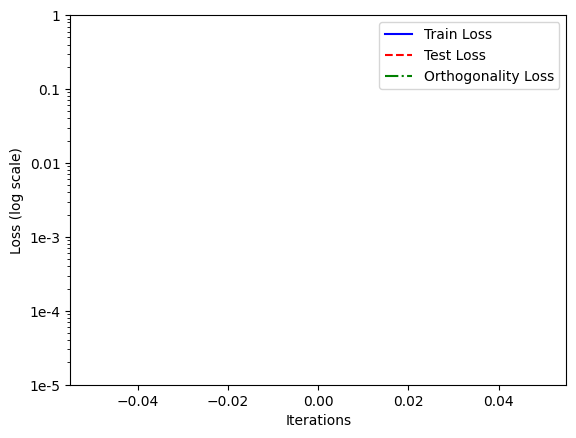

Iteration: 500 Train_loss:0.001492904033511877, Test_loss: 0.007098045200109482, ortho_loss:0.054602671414613724
Iteration: 1000 Train_loss:0.0014926876174286008, Test_loss: 0.007096460554748774, ortho_loss:0.054597407579422


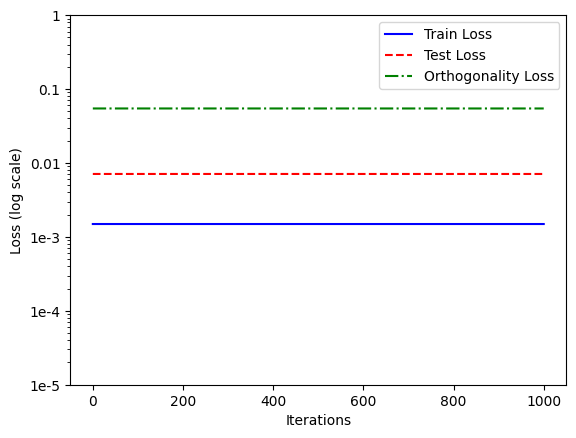

Iteration: 1500 Train_loss:0.001492468873038888, Test_loss: 0.007094889879226685, ortho_loss:0.05459003150463104
Iteration: 2000 Train_loss:0.0014922466361895204, Test_loss: 0.007093331776559353, ortho_loss:0.0545804426074028


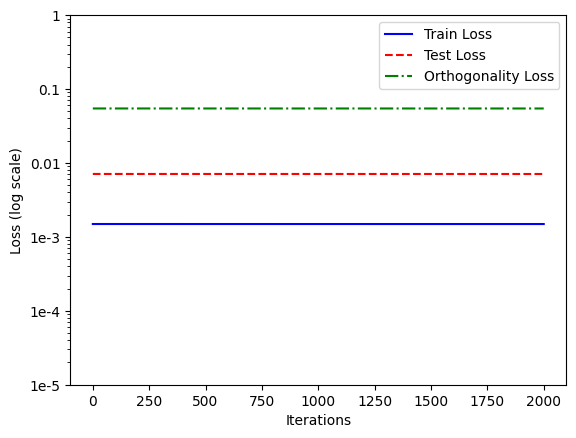

Iteration: 2500 Train_loss:0.0014920263784006238, Test_loss: 0.0070917438715696335, ortho_loss:0.05458365008234978
Iteration: 3000 Train_loss:0.0014918039087206125, Test_loss: 0.00709012895822525, ortho_loss:0.05456806719303131


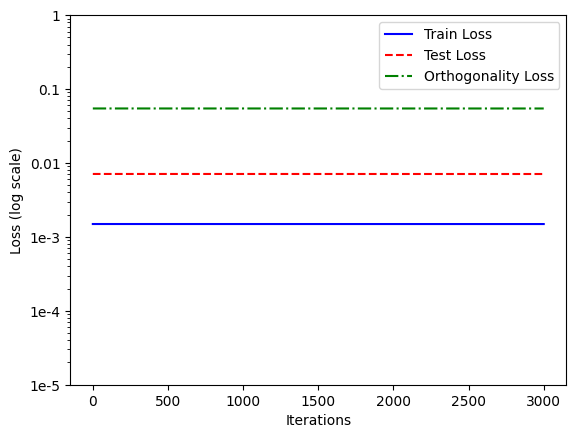

Iteration: 3500 Train_loss:0.0014915840001776814, Test_loss: 0.007088514044880867, ortho_loss:0.05455482378602028
Iteration: 4000 Train_loss:0.0014913599006831646, Test_loss: 0.007086911238729954, ortho_loss:0.054549332708120346


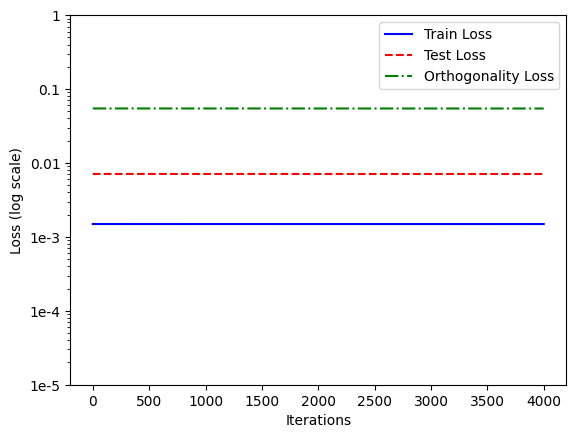

Iteration: 4500 Train_loss:0.0014911402249708772, Test_loss: 0.0070853461511433125, ortho_loss:0.054546888917684555
Iteration: 5000 Train_loss:0.0014909119345247746, Test_loss: 0.00708381412550807, ortho_loss:0.05453036352992058


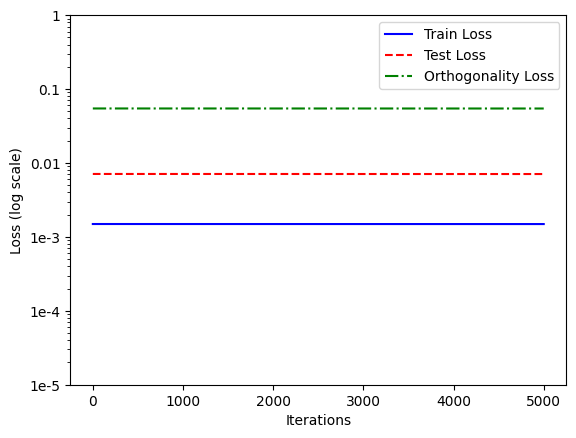

Iteration: 5500 Train_loss:0.0014906879514455795, Test_loss: 0.007082244381308556, ortho_loss:0.054521653801202774
Iteration: 6000 Train_loss:0.0014904660638421774, Test_loss: 0.007080689072608948, ortho_loss:0.05451953038573265


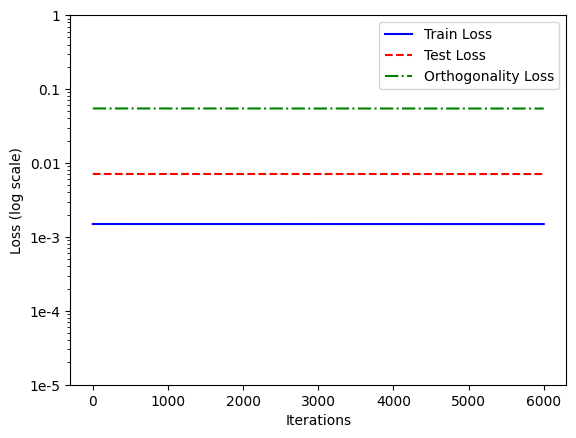

Iteration: 6500 Train_loss:0.0014902377733960748, Test_loss: 0.007079124916344881, ortho_loss:0.0545065738260746
Iteration: 7000 Train_loss:0.0014900154201313853, Test_loss: 0.0070775579661130905, ortho_loss:0.05450421944260597


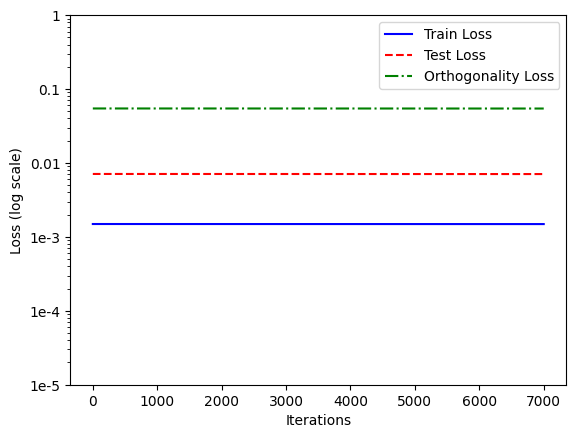

Iteration: 7500 Train_loss:0.0014897850342094898, Test_loss: 0.0070759993977844715, ortho_loss:0.054491832852363586
Iteration: 8000 Train_loss:0.0014895600033923984, Test_loss: 0.007074430119246244, ortho_loss:0.054483406245708466


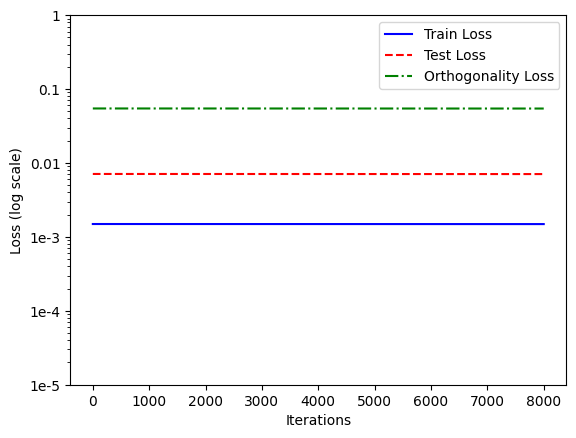

Iteration: 8500 Train_loss:0.001489330199547112, Test_loss: 0.007072855718433857, ortho_loss:0.05448320135474205
Iteration: 9000 Train_loss:0.0014891092432662845, Test_loss: 0.007071299012750387, ortho_loss:0.0544736348092556


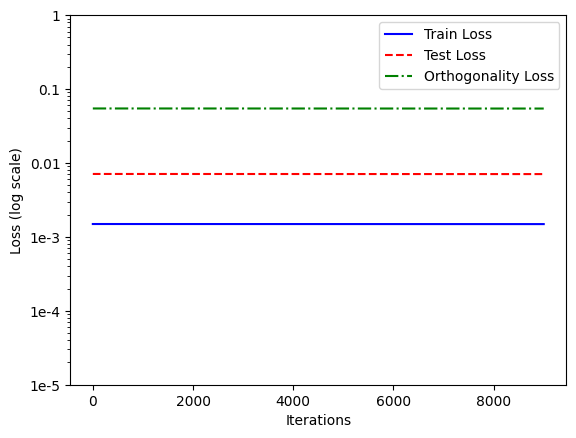

Iteration: 9500 Train_loss:0.0014888783916831017, Test_loss: 0.00706973671913147, ortho_loss:0.0544651560485363
Iteration: 10000 Train_loss:0.0014886530116200447, Test_loss: 0.007068172097206116, ortho_loss:0.05445883423089981


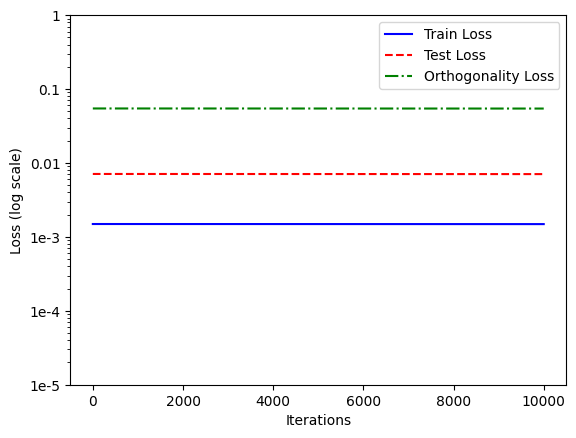

Iteration: 10500 Train_loss:0.0014884222764521837, Test_loss: 0.00706661120057106, ortho_loss:0.05445284768939018
Iteration: 11000 Train_loss:0.0014881949173286557, Test_loss: 0.007065057288855314, ortho_loss:0.0544450543820858


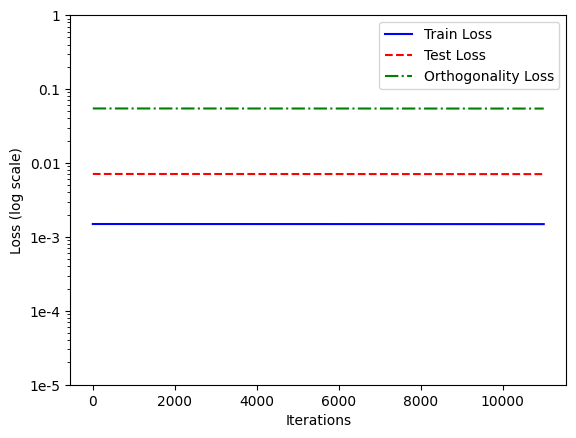

Iteration: 11500 Train_loss:0.0014879654627293348, Test_loss: 0.007063497789204121, ortho_loss:0.054437216371297836
Iteration: 12000 Train_loss:0.0014877348439767957, Test_loss: 0.00706194993108511, ortho_loss:0.05442386865615845


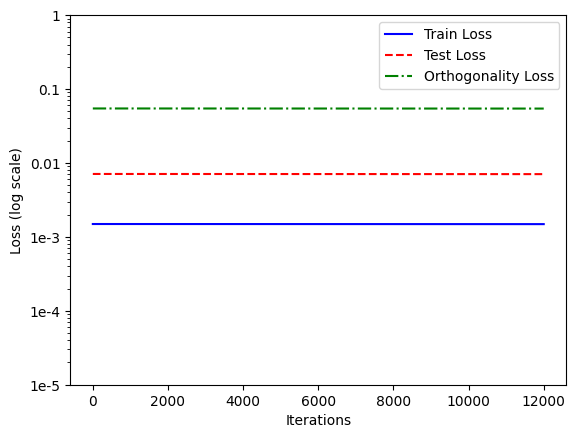

Iteration: 12500 Train_loss:0.0014875014312565327, Test_loss: 0.007060393691062927, ortho_loss:0.054424948990345
Iteration: 13000 Train_loss:0.001487272442318499, Test_loss: 0.0070587950758636, ortho_loss:0.05441512539982796


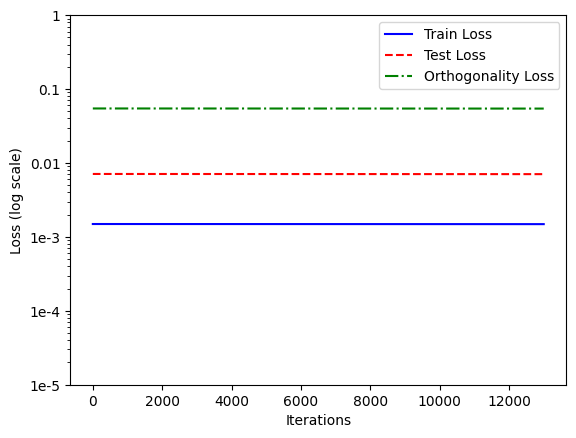

Iteration: 13500 Train_loss:0.0014870415907353163, Test_loss: 0.007057129871100187, ortho_loss:0.05439987778663635
Iteration: 14000 Train_loss:0.0014868052676320076, Test_loss: 0.007055388763546944, ortho_loss:0.05439649894833565


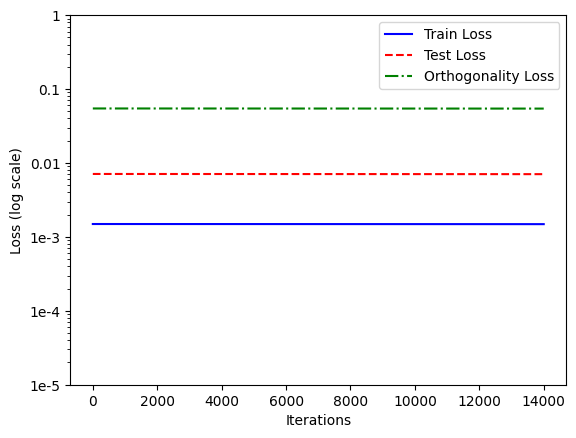

Iteration: 14500 Train_loss:0.0014865725534036756, Test_loss: 0.007053641136735678, ortho_loss:0.05439429357647896
Iteration: 15000 Train_loss:0.0014863379765301943, Test_loss: 0.007051905617117882, ortho_loss:0.05437818169593811


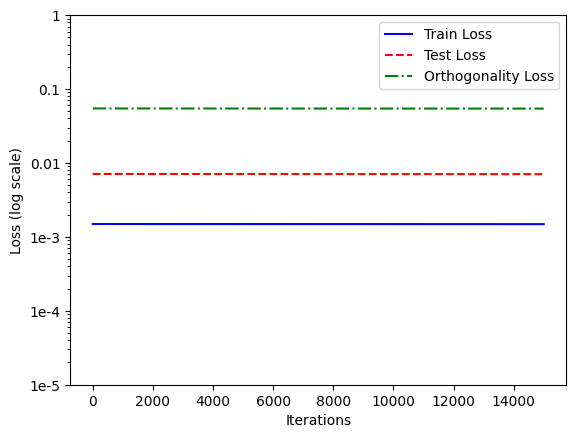

Iteration: 15500 Train_loss:0.0014861030504107475, Test_loss: 0.007050145883113146, ortho_loss:0.05437209829688072
Iteration: 16000 Train_loss:0.0014858657959848642, Test_loss: 0.007048389408737421, ortho_loss:0.0543573759496212


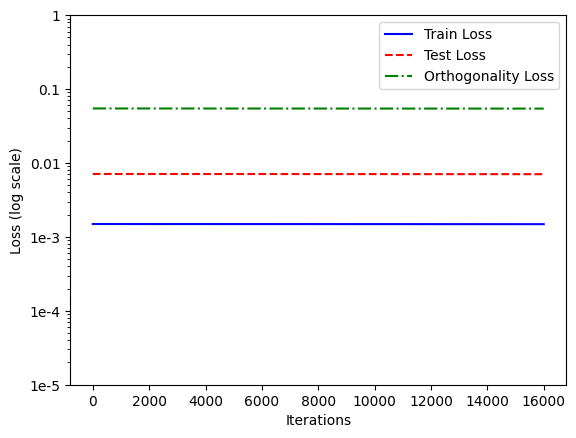

Iteration: 16500 Train_loss:0.0014856342459097505, Test_loss: 0.007046641781926155, ortho_loss:0.05435539409518242
Iteration: 17000 Train_loss:0.001485395710915327, Test_loss: 0.0070448974147439, ortho_loss:0.054345060139894485


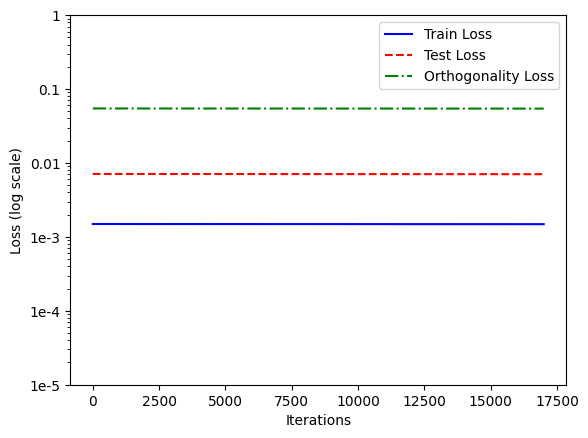

Iteration: 17500 Train_loss:0.001485157641582191, Test_loss: 0.007043156772851944, ortho_loss:0.054333265870809555
Iteration: 18000 Train_loss:0.0014849192230030894, Test_loss: 0.00704143475741148, ortho_loss:0.054324645549058914


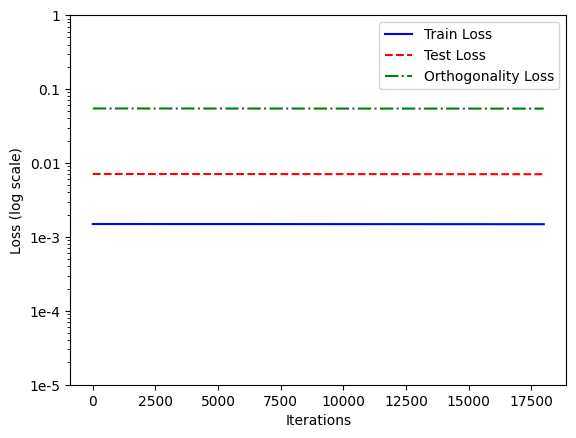

Iteration: 18500 Train_loss:0.001484682783484459, Test_loss: 0.0070396969094872475, ortho_loss:0.05431456118822098
Iteration: 19000 Train_loss:0.0014844434335827827, Test_loss: 0.007037960924208164, ortho_loss:0.0543084517121315


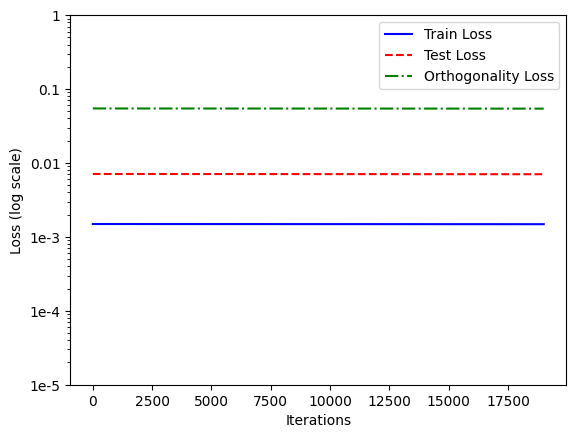

Iteration: 19500 Train_loss:0.0014842089731246233, Test_loss: 0.007036181166768074, ortho_loss:0.054299160838127136
Iteration: 20000 Train_loss:0.0014839691575616598, Test_loss: 0.007034397684037685, ortho_loss:0.05429207161068916


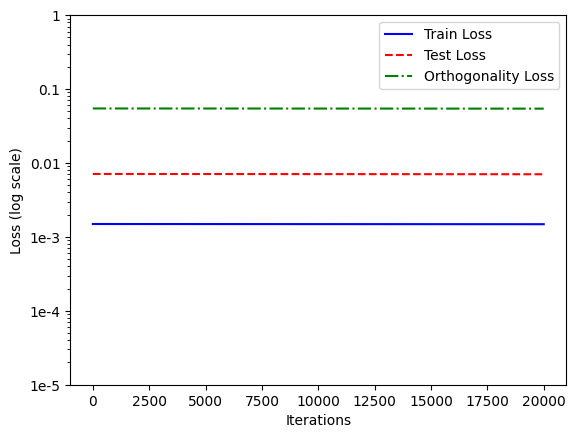

Iteration: 20500 Train_loss:0.0014837227063253522, Test_loss: 0.007032576948404312, ortho_loss:0.054281193763017654
Iteration: 21000 Train_loss:0.0014834856847301126, Test_loss: 0.007030791137367487, ortho_loss:0.05427897348999977


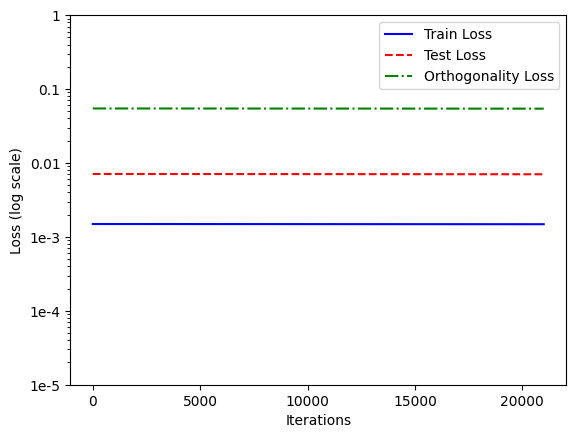

Iteration: 21500 Train_loss:0.0014832480810582638, Test_loss: 0.007028995081782341, ortho_loss:0.054272621870040894
Iteration: 22000 Train_loss:0.0014830087311565876, Test_loss: 0.007027208339422941, ortho_loss:0.054264914244413376


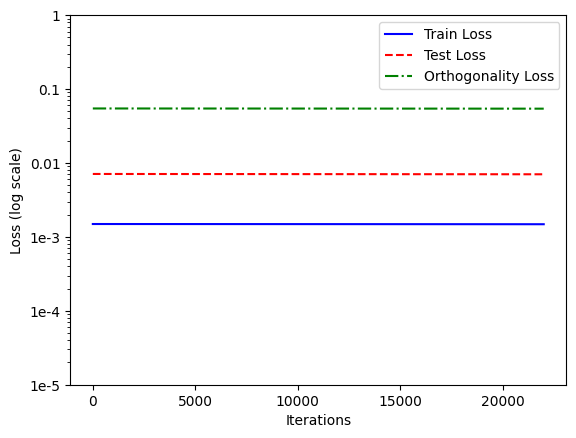

Iteration: 22500 Train_loss:0.0014827646082267165, Test_loss: 0.007025393191725016, ortho_loss:0.054259978234767914
Iteration: 23000 Train_loss:0.0014825223479419947, Test_loss: 0.007023550104349852, ortho_loss:0.05425206571817398


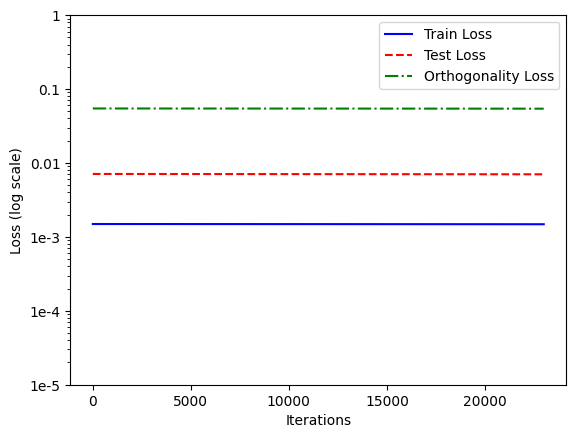

Iteration: 23500 Train_loss:0.0014822803204879165, Test_loss: 0.007021642755717039, ortho_loss:0.0542430579662323
Iteration: 24000 Train_loss:0.0014820341020822525, Test_loss: 0.007019729819148779, ortho_loss:0.054237205535173416


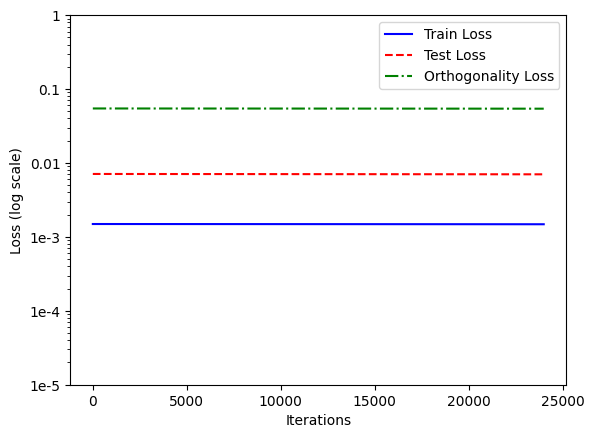

Iteration: 24500 Train_loss:0.0014817907940596342, Test_loss: 0.007017810363322496, ortho_loss:0.05423911288380623
Iteration: 25000 Train_loss:0.001481547486037016, Test_loss: 0.007015895564109087, ortho_loss:0.05422595515847206


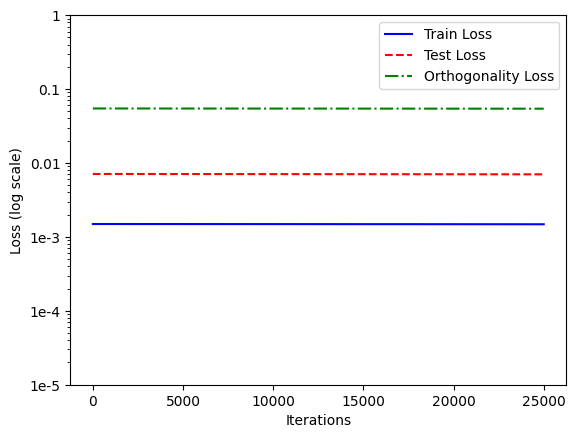

Iteration: 25500 Train_loss:0.001481303945183754, Test_loss: 0.007013970986008644, ortho_loss:0.05422117933630943
Iteration: 26000 Train_loss:0.001481055747717619, Test_loss: 0.007012039888650179, ortho_loss:0.05421603471040726


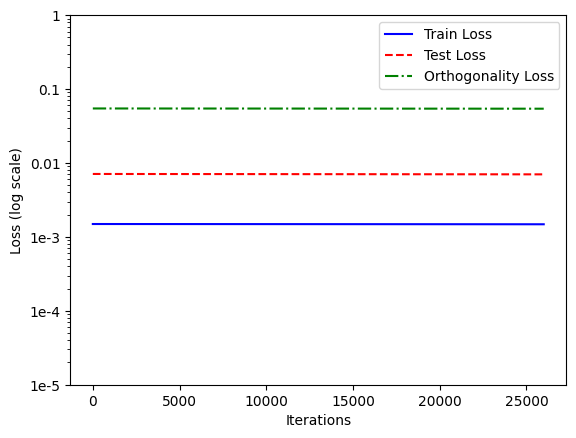

Iteration: 26500 Train_loss:0.0014808073174208403, Test_loss: 0.007010074332356453, ortho_loss:0.05420547351241112
Iteration: 27000 Train_loss:0.0014805615646764636, Test_loss: 0.007008120883256197, ortho_loss:0.05420532450079918


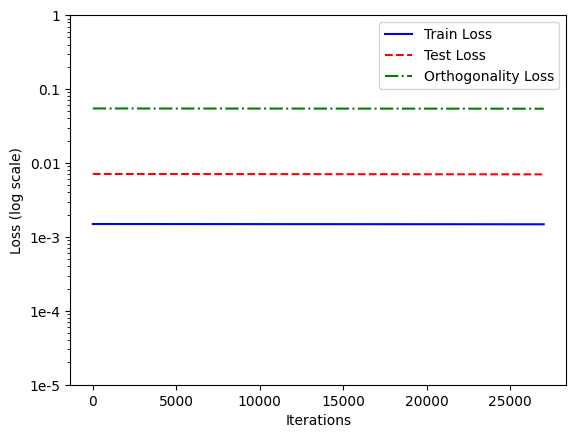

Iteration: 27500 Train_loss:0.001480315113440156, Test_loss: 0.007006143219769001, ortho_loss:0.054198600351810455
Iteration: 28000 Train_loss:0.0014800692442804575, Test_loss: 0.007004146929830313, ortho_loss:0.05418972671031952


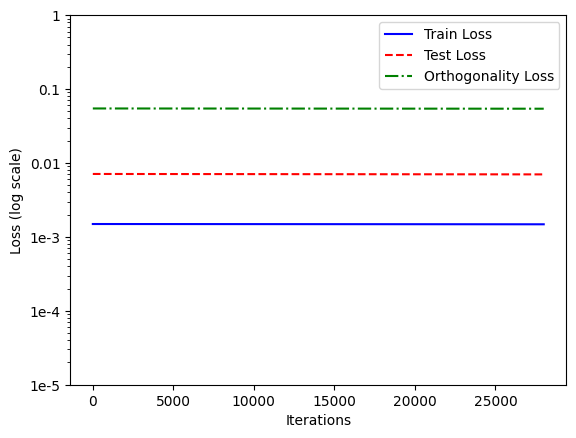

Iteration: 28500 Train_loss:0.0014798197662457824, Test_loss: 0.0070021385326981544, ortho_loss:0.05418563634157181
Iteration: 29000 Train_loss:0.0014795735478401184, Test_loss: 0.0070001231506466866, ortho_loss:0.05418848991394043


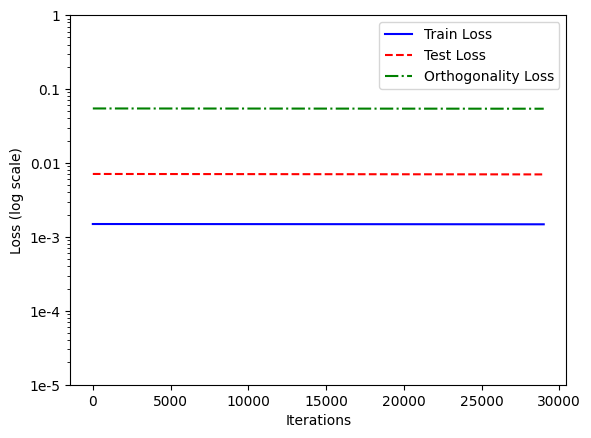

Iteration: 29500 Train_loss:0.0014793246518820524, Test_loss: 0.006998083554208279, ortho_loss:0.054179202765226364
Iteration: 30000 Train_loss:0.0014790751738473773, Test_loss: 0.006996051408350468, ortho_loss:0.05417420715093613


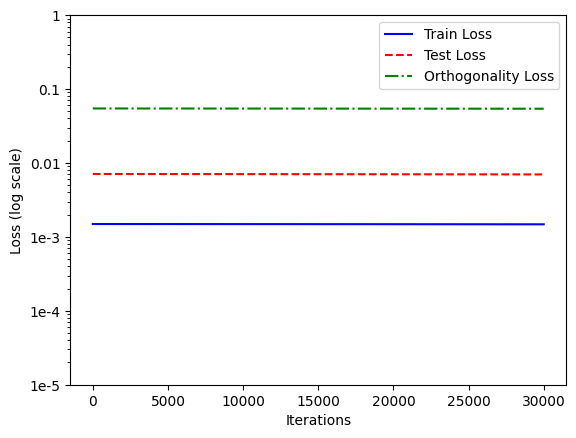

Iteration: 30500 Train_loss:0.001478822436183691, Test_loss: 0.006994026247411966, ortho_loss:0.0541723370552063
Iteration: 31000 Train_loss:0.0014785703970119357, Test_loss: 0.006991968024522066, ortho_loss:0.05416223779320717


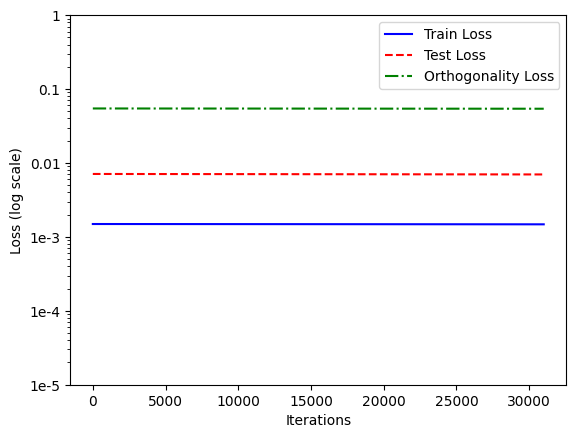

Iteration: 31500 Train_loss:0.0014783221995458007, Test_loss: 0.006989889778196812, ortho_loss:0.05415842682123184
Iteration: 32000 Train_loss:0.0014780701603740454, Test_loss: 0.006987795699387789, ortho_loss:0.054148655384778976


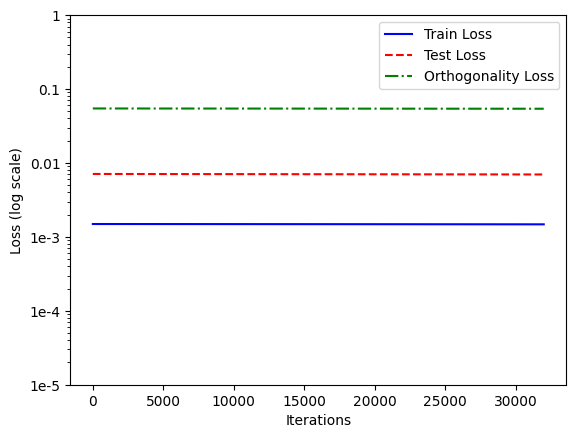

Iteration: 32500 Train_loss:0.00147781812120229, Test_loss: 0.006985716987401247, ortho_loss:0.05414563789963722
Iteration: 33000 Train_loss:0.0014775671297684312, Test_loss: 0.00698362709954381, ortho_loss:0.054139573127031326


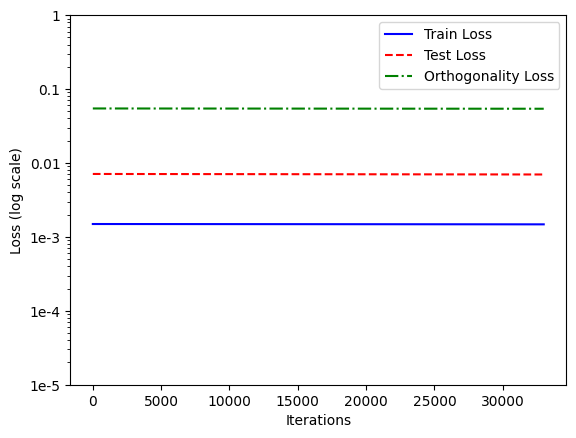

Iteration: 33500 Train_loss:0.0014773097354918718, Test_loss: 0.006981493905186653, ortho_loss:0.054133180528879166
Iteration: 34000 Train_loss:0.0014770565321668983, Test_loss: 0.006979373283684254, ortho_loss:0.05412667989730835


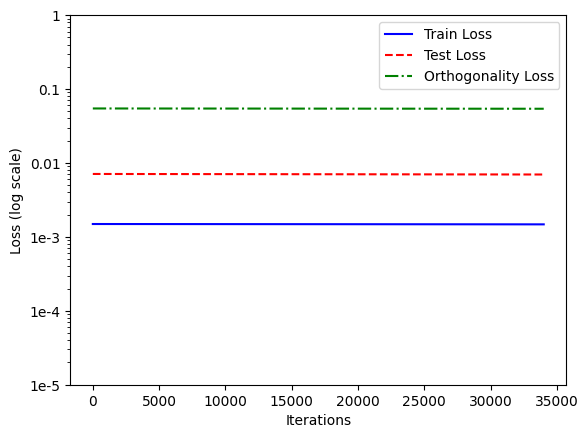

Iteration: 34500 Train_loss:0.0014768041437491775, Test_loss: 0.0069772289134562016, ortho_loss:0.054119013249874115
Iteration: 35000 Train_loss:0.0014765497762709856, Test_loss: 0.006975090131163597, ortho_loss:0.05411821976304054


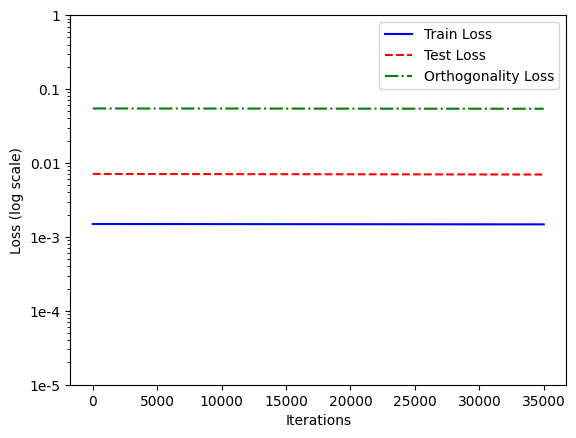

Iteration: 35500 Train_loss:0.0014762916835024953, Test_loss: 0.006972979754209518, ortho_loss:0.054112378507852554
Iteration: 36000 Train_loss:0.001476032892242074, Test_loss: 0.006970861926674843, ortho_loss:0.054106660187244415


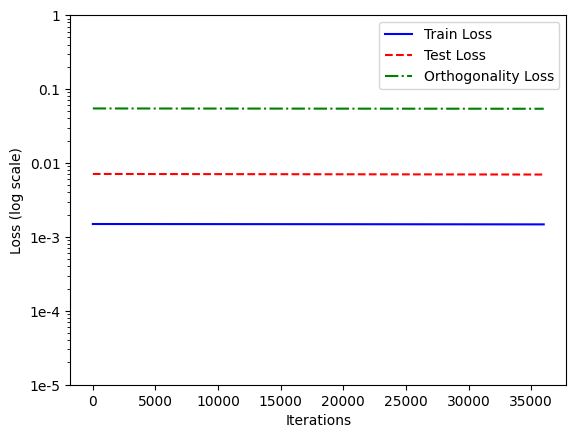

Iteration: 36500 Train_loss:0.0014757754979655147, Test_loss: 0.0069687687791883945, ortho_loss:0.05410030111670494
Iteration: 37000 Train_loss:0.0014755207812413573, Test_loss: 0.0069666458293795586, ortho_loss:0.05409828945994377


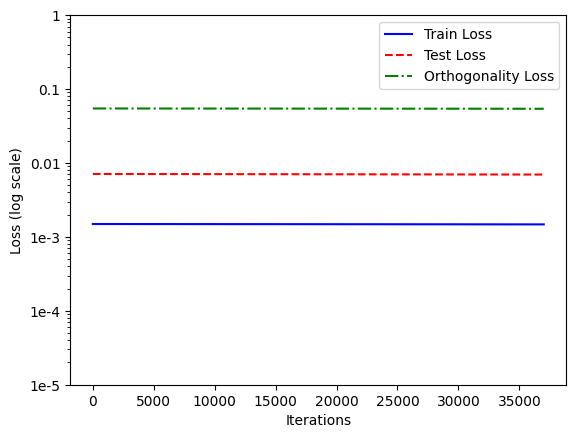

Iteration: 37500 Train_loss:0.0014752635033801198, Test_loss: 0.00696452846750617, ortho_loss:0.0540945902466774
Iteration: 38000 Train_loss:0.0014750027330592275, Test_loss: 0.00696242181584239, ortho_loss:0.054089128971099854


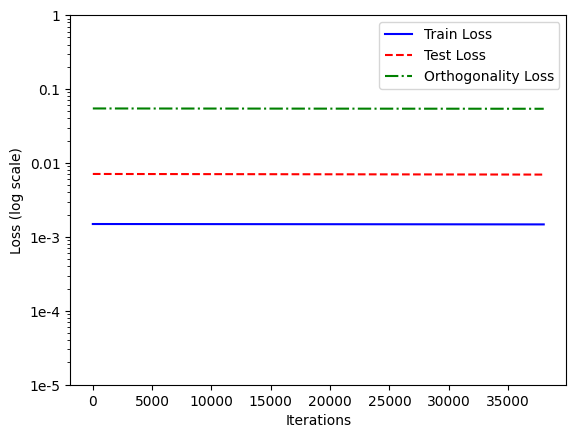

Iteration: 38500 Train_loss:0.0014747456880286336, Test_loss: 0.0069602979347109795, ortho_loss:0.05407918244600296
Iteration: 39000 Train_loss:0.0014744835207238793, Test_loss: 0.0069581917487084866, ortho_loss:0.054076846688985825


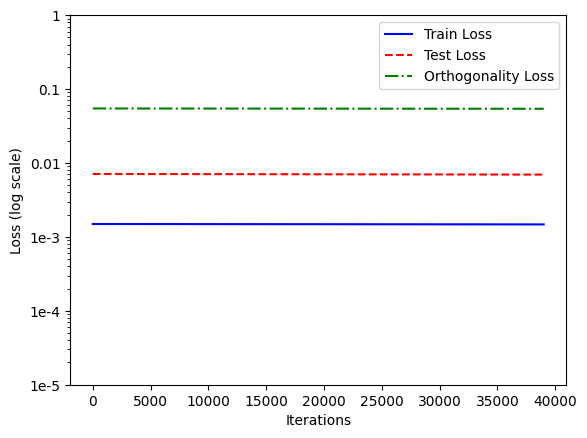

Iteration: 39500 Train_loss:0.0014742235653102398, Test_loss: 0.006956076715141535, ortho_loss:0.05407344922423363
Iteration: 40000 Train_loss:0.0014739613980054855, Test_loss: 0.006953966338187456, ortho_loss:0.05406186729669571


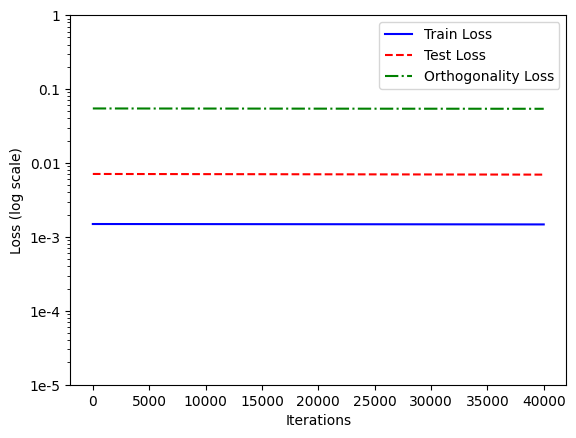

Iteration: 40500 Train_loss:0.0014736974844709039, Test_loss: 0.006951888091862202, ortho_loss:0.054060786962509155
Iteration: 41000 Train_loss:0.0014734346186742187, Test_loss: 0.006949787028133869, ortho_loss:0.05405689403414726


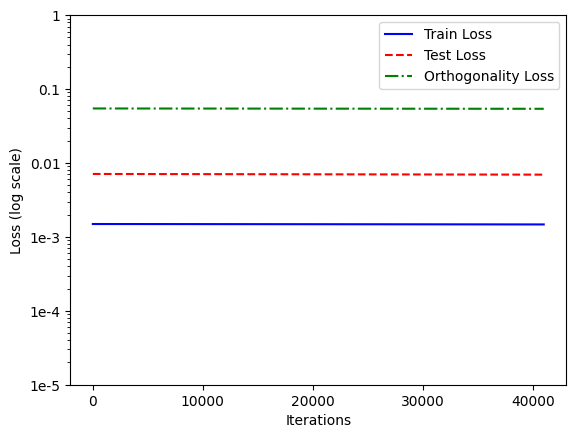

Iteration: 41500 Train_loss:0.001473169308155775, Test_loss: 0.006947687361389399, ortho_loss:0.05404992029070854
Iteration: 42000 Train_loss:0.0014729052782058716, Test_loss: 0.006945578847080469, ortho_loss:0.054050203412771225


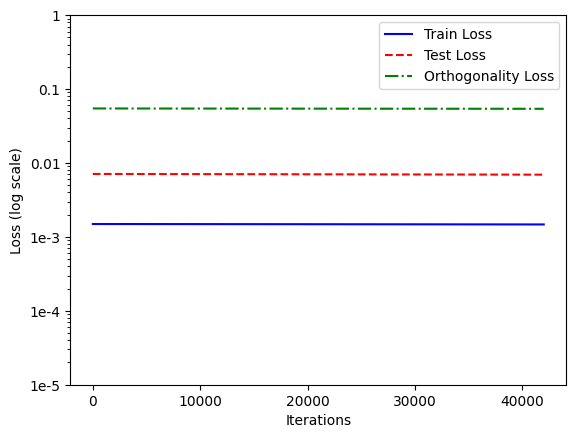

Iteration: 42500 Train_loss:0.0014726388035342097, Test_loss: 0.0069434745237231255, ortho_loss:0.05404770374298096
Iteration: 43000 Train_loss:0.0014723724452778697, Test_loss: 0.006941379513591528, ortho_loss:0.054044563323259354


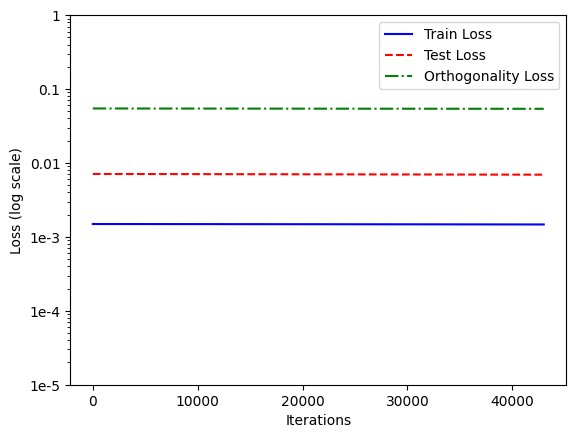

Iteration: 43500 Train_loss:0.0014721096958965063, Test_loss: 0.00693927239626646, ortho_loss:0.05403868854045868
Iteration: 44000 Train_loss:0.0014718389138579369, Test_loss: 0.006937173195183277, ortho_loss:0.05403498187661171


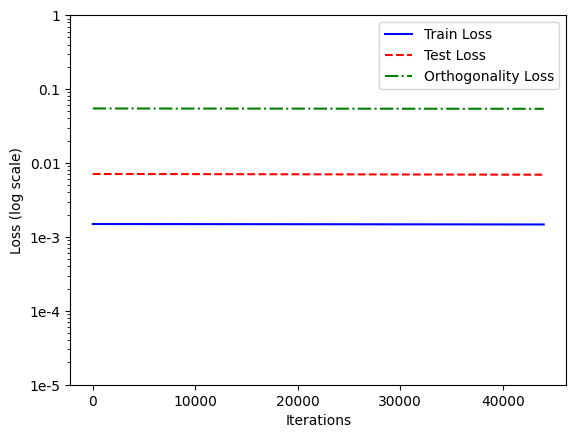

Iteration: 44500 Train_loss:0.0014715715078637004, Test_loss: 0.0069350493140518665, ortho_loss:0.054037321358919144
Iteration: 45000 Train_loss:0.0014713035197928548, Test_loss: 0.00693295244127512, ortho_loss:0.05403190851211548


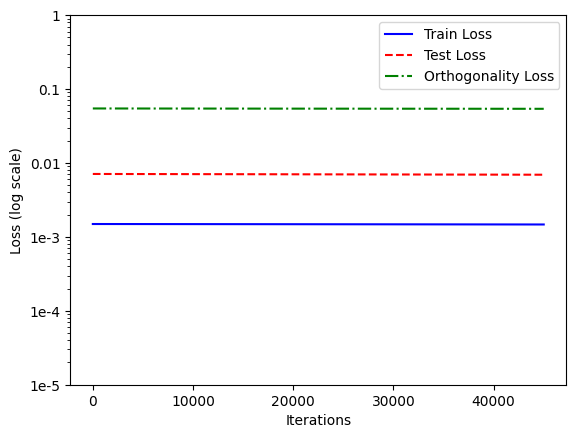

Iteration: 45500 Train_loss:0.001471040421165526, Test_loss: 0.006930830422788858, ortho_loss:0.05403076857328415
Iteration: 46000 Train_loss:0.001470769988372922, Test_loss: 0.006928696297109127, ortho_loss:0.054022207856178284


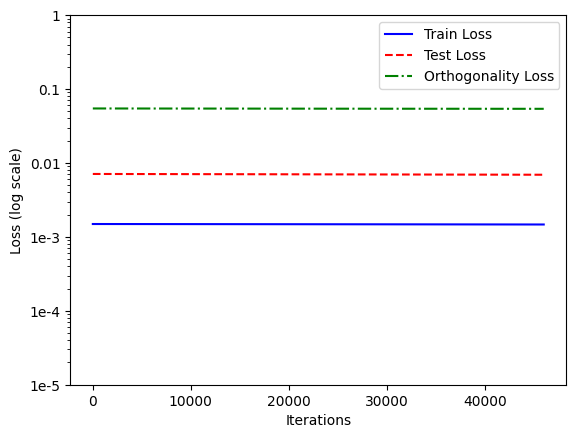

Iteration: 46500 Train_loss:0.001470494782552123, Test_loss: 0.006926552392542362, ortho_loss:0.05401475355029106
Iteration: 47000 Train_loss:0.0014702259795740247, Test_loss: 0.006924377288669348, ortho_loss:0.054011452943086624


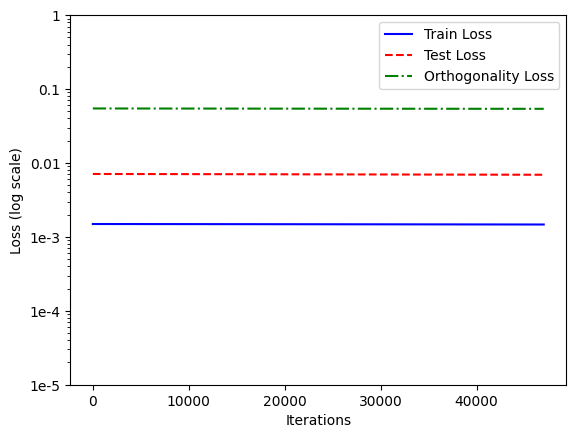

Iteration: 47500 Train_loss:0.0014699605526402593, Test_loss: 0.0069221751764416695, ortho_loss:0.054012540727853775
Iteration: 48000 Train_loss:0.0014696831349283457, Test_loss: 0.006919959560036659, ortho_loss:0.05400368198752403


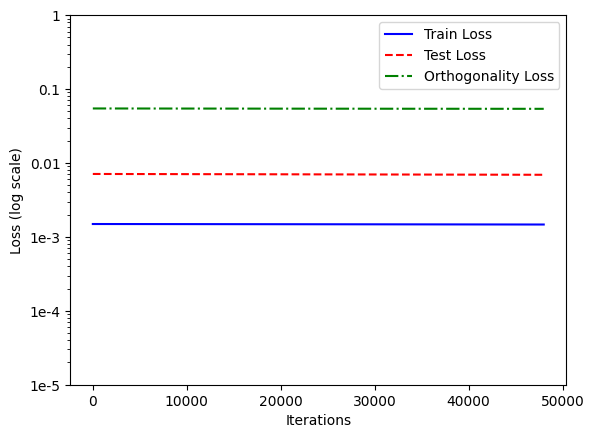

Iteration: 48500 Train_loss:0.0014694121200591326, Test_loss: 0.006917730905115604, ortho_loss:0.05400240793824196
Iteration: 49000 Train_loss:0.0014691399410367012, Test_loss: 0.006915494799613953, ortho_loss:0.05400019511580467


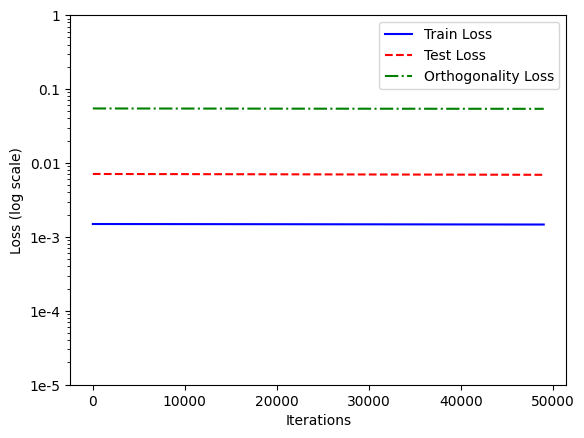

Iteration: 49500 Train_loss:0.0014688679948449135, Test_loss: 0.006913252640515566, ortho_loss:0.054004933685064316
Iteration: 50000 Train_loss:0.001468596630729735, Test_loss: 0.006911029573529959, ortho_loss:0.053997430950403214


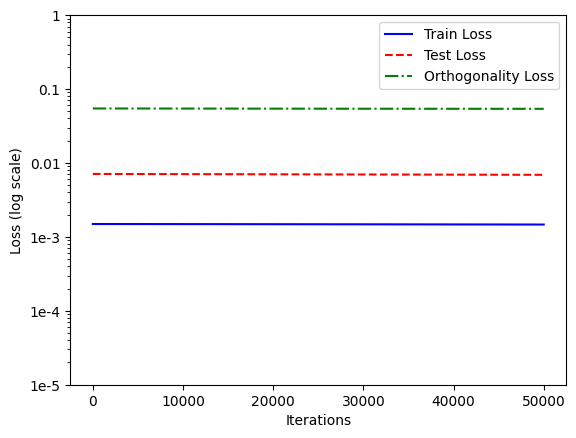

Iteration: 50500 Train_loss:0.0014683178160339594, Test_loss: 0.006908800452947617, ortho_loss:0.053991131484508514
Iteration: 51000 Train_loss:0.0014680445892736316, Test_loss: 0.006906589958816767, ortho_loss:0.053988754749298096


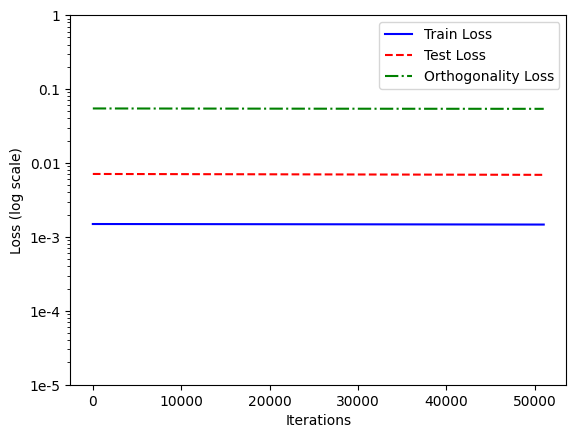

Iteration: 51500 Train_loss:0.001467772526666522, Test_loss: 0.006904376670718193, ortho_loss:0.053985968232154846
Iteration: 52000 Train_loss:0.0014674895210191607, Test_loss: 0.0069021969102323055, ortho_loss:0.053989216685295105


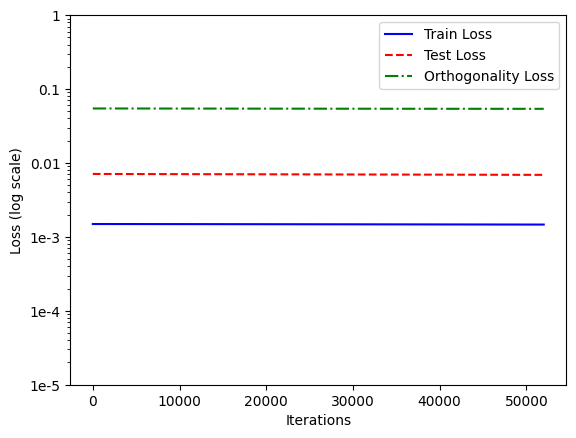

Iteration: 52500 Train_loss:0.0014672125689685345, Test_loss: 0.0069000148214399815, ortho_loss:0.05398097261786461
Iteration: 53000 Train_loss:0.0014669352676719427, Test_loss: 0.0068978359922766685, ortho_loss:0.053982943296432495


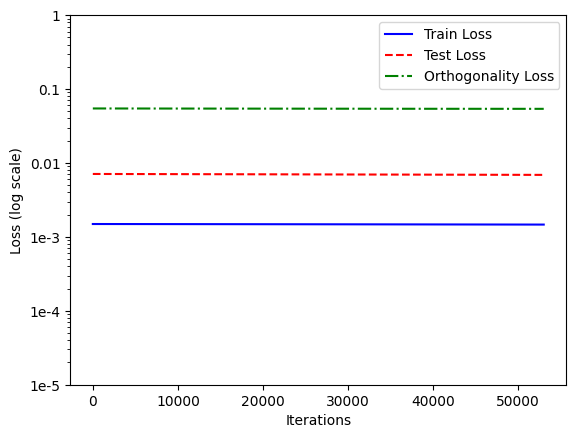

Iteration: 53500 Train_loss:0.001466658664867282, Test_loss: 0.006895643658936024, ortho_loss:0.053979650139808655
Iteration: 54000 Train_loss:0.0014663818292319775, Test_loss: 0.006893438287079334, ortho_loss:0.053972963243722916


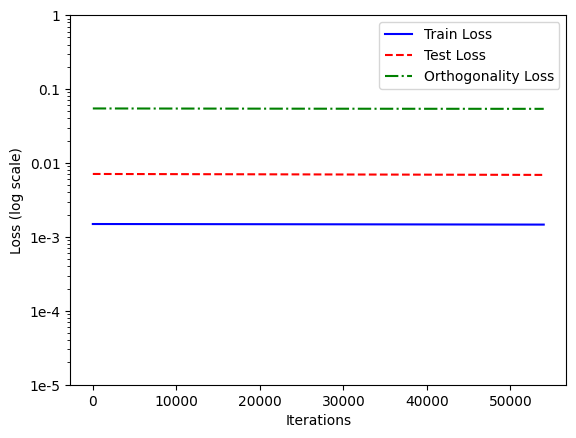

Iteration: 54500 Train_loss:0.0014661031309515238, Test_loss: 0.006891218479722738, ortho_loss:0.05397335812449455
Iteration: 55000 Train_loss:0.0014658225700259209, Test_loss: 0.00688897306099534, ortho_loss:0.05396949127316475


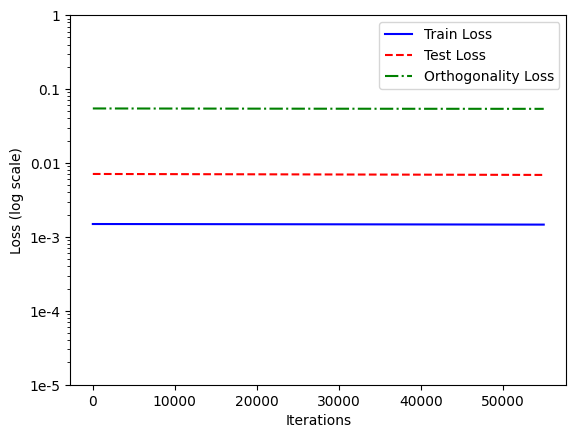

Iteration: 55500 Train_loss:0.0014655422419309616, Test_loss: 0.006886688061058521, ortho_loss:0.05396256968379021
Iteration: 56000 Train_loss:0.0014652605168521404, Test_loss: 0.006884354166686535, ortho_loss:0.05396552383899689


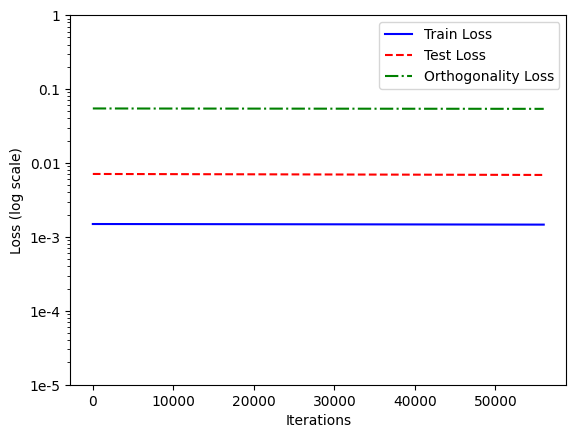

Iteration: 56500 Train_loss:0.0014649834483861923, Test_loss: 0.006881946697831154, ortho_loss:0.05396069958806038
Iteration: 57000 Train_loss:0.0014646962517872453, Test_loss: 0.006879527121782303, ortho_loss:0.05395989865064621


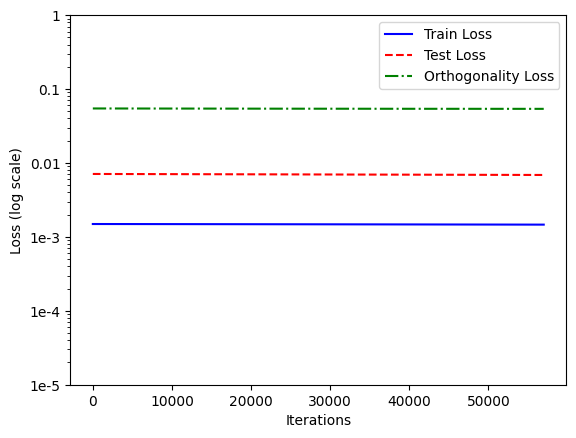

Iteration: 57500 Train_loss:0.001464408589527011, Test_loss: 0.006877079140394926, ortho_loss:0.05395416170358658
Iteration: 58000 Train_loss:0.0014641259331256151, Test_loss: 0.006874618586152792, ortho_loss:0.05395648628473282


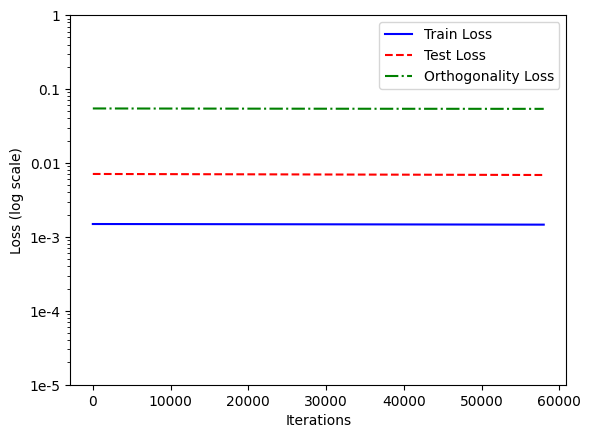

Iteration: 58500 Train_loss:0.0014638423454016447, Test_loss: 0.006872147787362337, ortho_loss:0.0539507120847702
Iteration: 59000 Train_loss:0.0014635552652180195, Test_loss: 0.006869659759104252, ortho_loss:0.05394996330142021


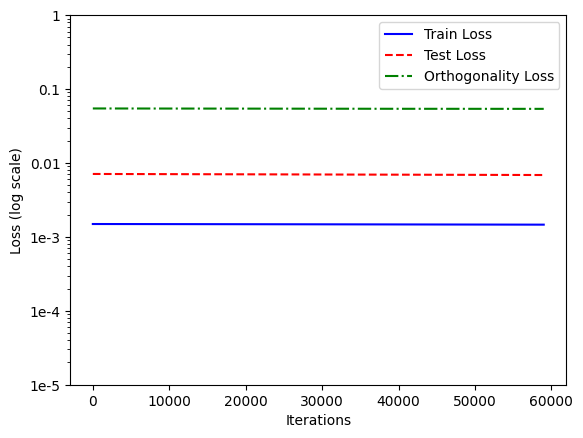

Iteration: 59500 Train_loss:0.0014632728416472673, Test_loss: 0.006867151707410812, ortho_loss:0.05394082888960838
Iteration: 60000 Train_loss:0.0014629856450483203, Test_loss: 0.0068646445870399475, ortho_loss:0.05393816530704498


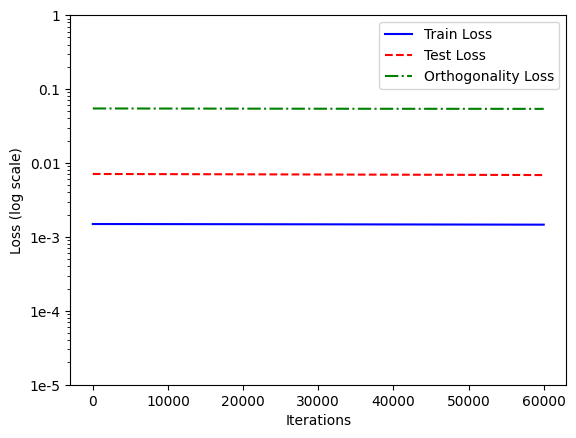

Iteration: 60500 Train_loss:0.0014626976335421205, Test_loss: 0.006862139329314232, ortho_loss:0.053936246782541275
Iteration: 61000 Train_loss:0.0014624089235439897, Test_loss: 0.006859634071588516, ortho_loss:0.053927917033433914


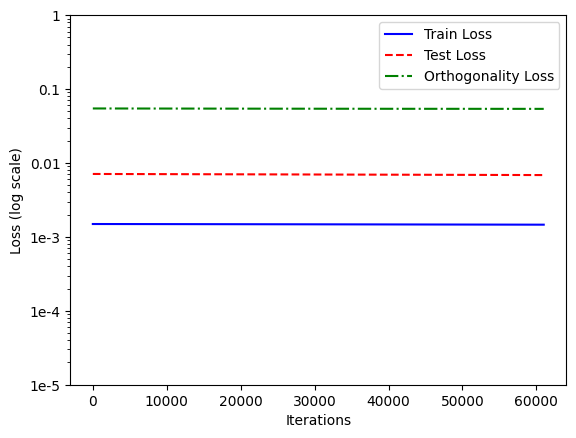

Iteration: 61500 Train_loss:0.001462117419578135, Test_loss: 0.006857128348201513, ortho_loss:0.05392959713935852
Iteration: 62000 Train_loss:0.001461830921471119, Test_loss: 0.006854631472378969, ortho_loss:0.053926270455121994


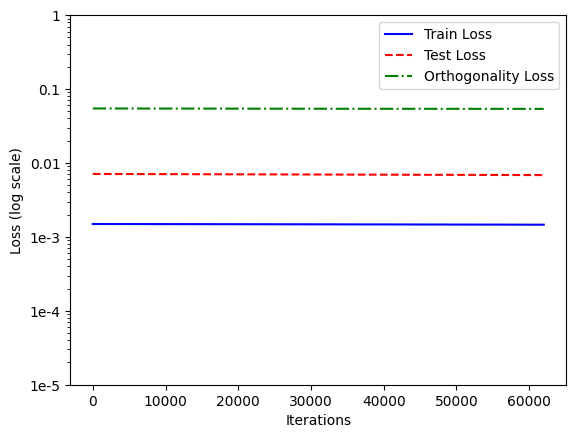

Iteration: 62500 Train_loss:0.0014615411637350917, Test_loss: 0.0068521201610565186, ortho_loss:0.05391955375671387
Iteration: 63000 Train_loss:0.001461249659769237, Test_loss: 0.006849623750895262, ortho_loss:0.053920138627290726


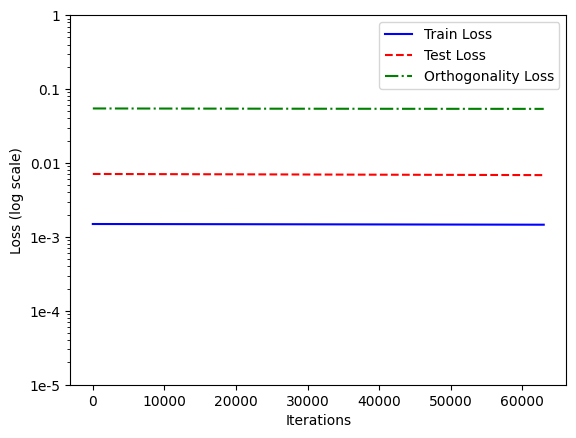

Iteration: 63500 Train_loss:0.0014609601348638535, Test_loss: 0.006847115233540535, ortho_loss:0.05391334369778633
Iteration: 64000 Train_loss:0.00146067189052701, Test_loss: 0.006844621151685715, ortho_loss:0.05391286313533783


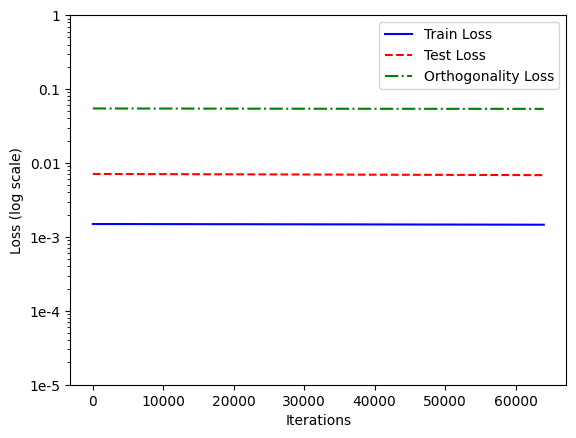

Iteration: 64500 Train_loss:0.001460375846363604, Test_loss: 0.006842097267508507, ortho_loss:0.053910885006189346
Iteration: 65000 Train_loss:0.001460082596167922, Test_loss: 0.006839579436928034, ortho_loss:0.05390731245279312


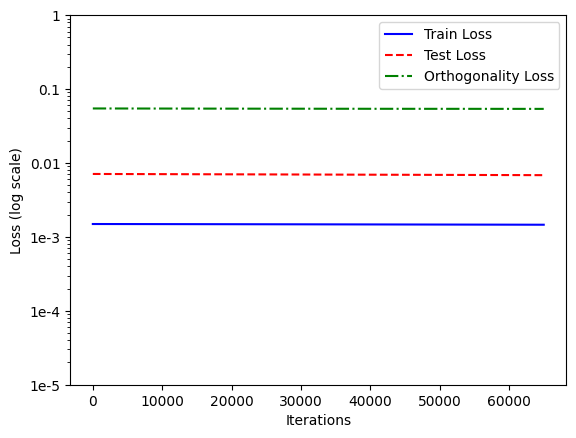

Iteration: 65500 Train_loss:0.0014597887638956308, Test_loss: 0.006837061140686274, ortho_loss:0.05391073226928711
Iteration: 66000 Train_loss:0.0014594951644539833, Test_loss: 0.006834554951637983, ortho_loss:0.05390634015202522


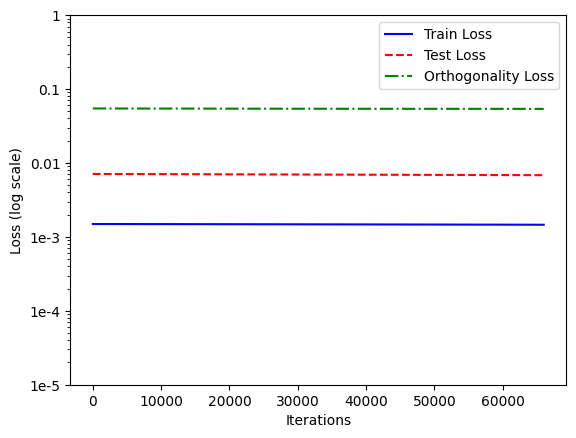

Iteration: 66500 Train_loss:0.001459199469536543, Test_loss: 0.006832036655396223, ortho_loss:0.05390144884586334
Iteration: 67000 Train_loss:0.0014589006314054132, Test_loss: 0.00682951882481575, ortho_loss:0.053901124745607376


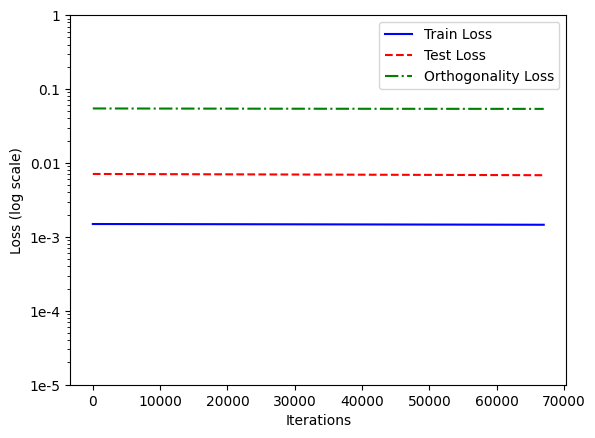

Iteration: 67500 Train_loss:0.0014586040051653981, Test_loss: 0.006826998665928841, ortho_loss:0.053903788328170776
Iteration: 68000 Train_loss:0.0014583063311874866, Test_loss: 0.006824474316090345, ortho_loss:0.0539046972990036


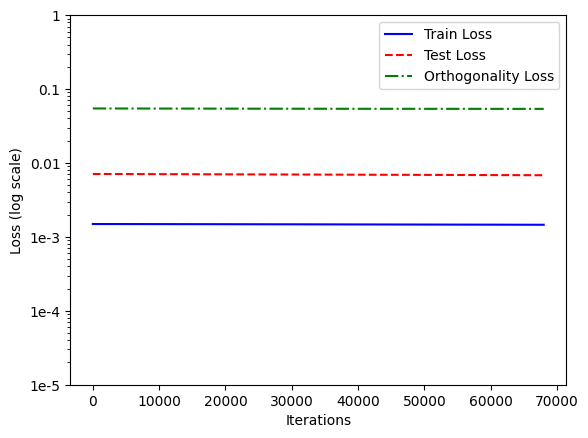

Iteration: 68500 Train_loss:0.001458008773624897, Test_loss: 0.006821918301284313, ortho_loss:0.05390194430947304
Iteration: 69000 Train_loss:0.001457718200981617, Test_loss: 0.00681937113404274, ortho_loss:0.05389668419957161


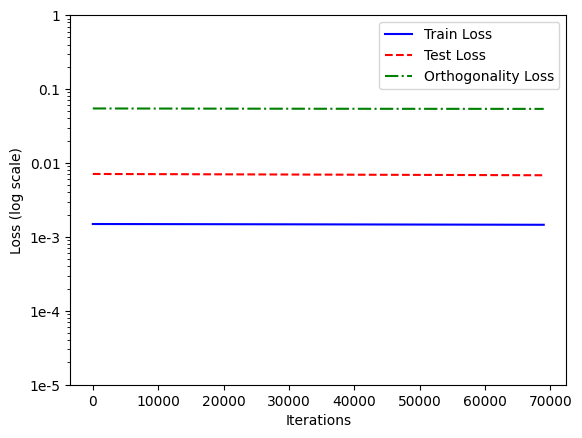

Iteration: 69500 Train_loss:0.0014574108645319939, Test_loss: 0.006816818378865719, ortho_loss:0.053892213851213455
Iteration: 70000 Train_loss:0.0014571116771548986, Test_loss: 0.006814277730882168, ortho_loss:0.05388627201318741


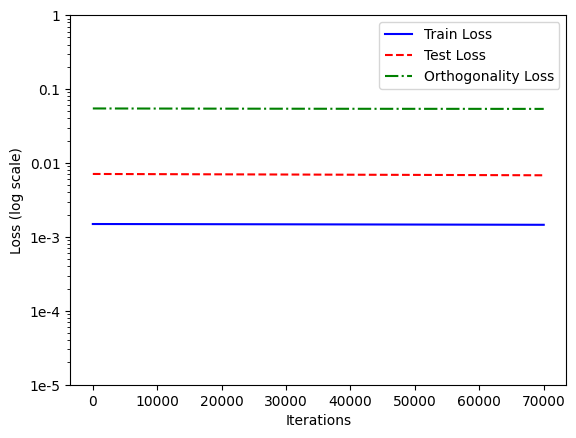

Iteration: 70500 Train_loss:0.0014568092301487923, Test_loss: 0.006811720319092274, ortho_loss:0.05389270931482315
Iteration: 71000 Train_loss:0.0014565105084329844, Test_loss: 0.006809210404753685, ortho_loss:0.0538860484957695


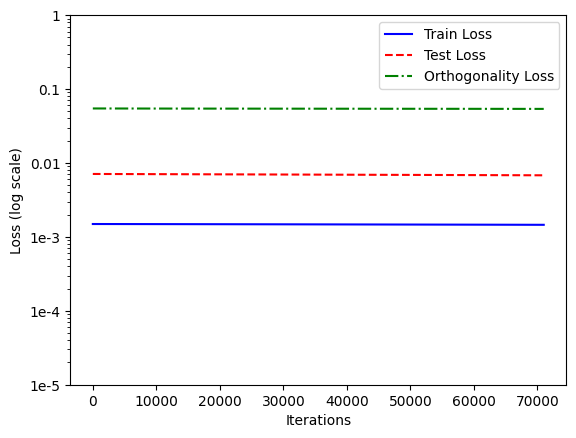

Iteration: 71500 Train_loss:0.0014562113210558891, Test_loss: 0.006806711200624704, ortho_loss:0.053887415677309036
Iteration: 72000 Train_loss:0.0014559113187715411, Test_loss: 0.006804209668189287, ortho_loss:0.053876589983701706


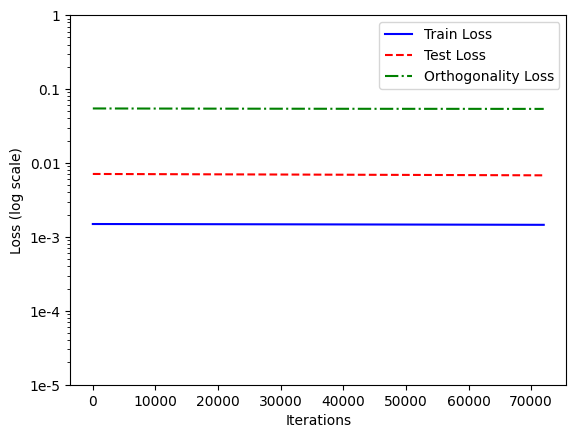

Iteration: 72500 Train_loss:0.0014556070091202855, Test_loss: 0.0068016862496733665, ortho_loss:0.05387398600578308
Iteration: 73000 Train_loss:0.0014552997890859842, Test_loss: 0.006799155380576849, ortho_loss:0.053878918290138245


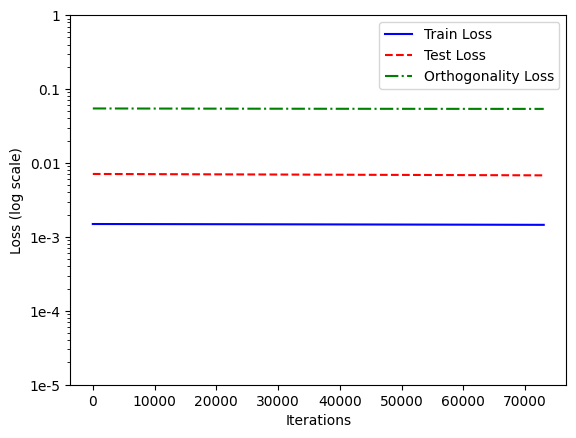

Iteration: 73500 Train_loss:0.0014549981569871306, Test_loss: 0.00679664546623826, ortho_loss:0.05387822911143303
Iteration: 74000 Train_loss:0.0014546922175213695, Test_loss: 0.006794148590415716, ortho_loss:0.05387105047702789


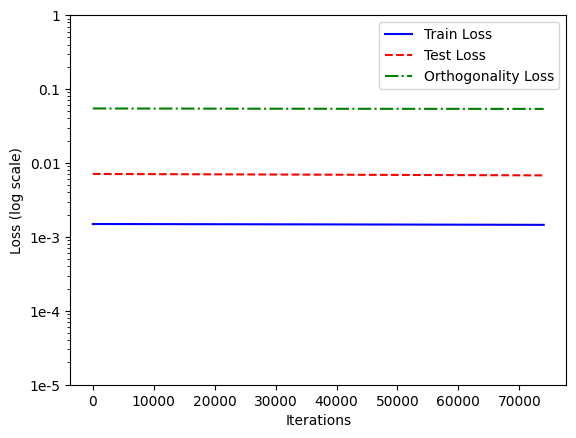

Iteration: 74500 Train_loss:0.0014543881407007575, Test_loss: 0.006791645660996437, ortho_loss:0.05386965721845627
Iteration: 75000 Train_loss:0.0014540789416059852, Test_loss: 0.006789139937609434, ortho_loss:0.053859736770391464


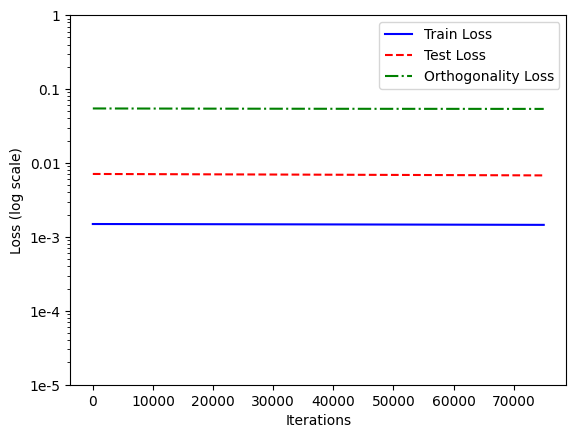

Iteration: 75500 Train_loss:0.0014537775423377752, Test_loss: 0.006786659825593233, ortho_loss:0.05386561527848244
Iteration: 76000 Train_loss:0.0014534643851220608, Test_loss: 0.006784176453948021, ortho_loss:0.05385629087686539


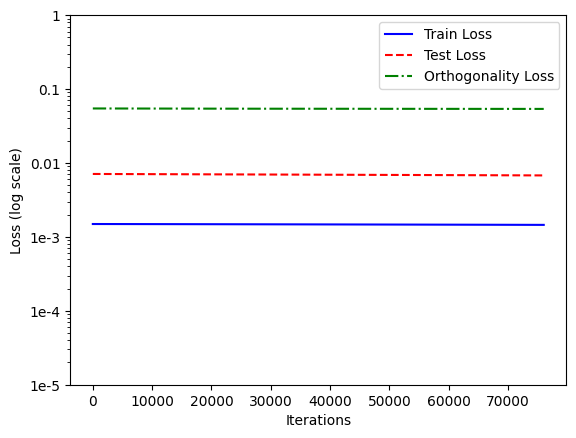

Iteration: 76500 Train_loss:0.001453162170946598, Test_loss: 0.006781705189496279, ortho_loss:0.05385809391736984
Iteration: 77000 Train_loss:0.0014528523897752166, Test_loss: 0.00677922647446394, ortho_loss:0.05385253578424454


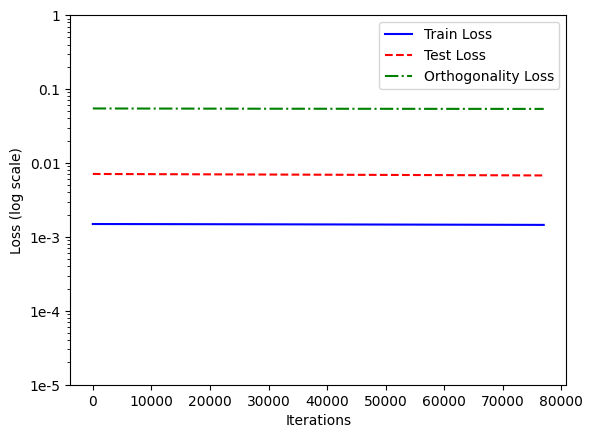

Iteration: 77500 Train_loss:0.0014525378355756402, Test_loss: 0.006776747293770313, ortho_loss:0.05384631082415581
Iteration: 78000 Train_loss:0.0014522334095090628, Test_loss: 0.006774276960641146, ortho_loss:0.05384692922234535


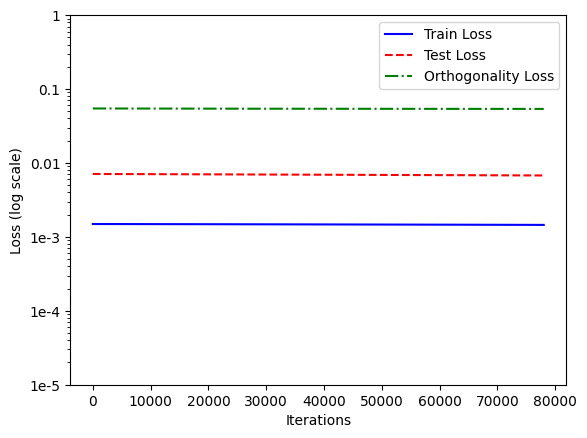

Iteration: 78500 Train_loss:0.0014519179239869118, Test_loss: 0.006771818269044161, ortho_loss:0.05385017395019531
Iteration: 79000 Train_loss:0.0014516044175252318, Test_loss: 0.006769354920834303, ortho_loss:0.053835973143577576


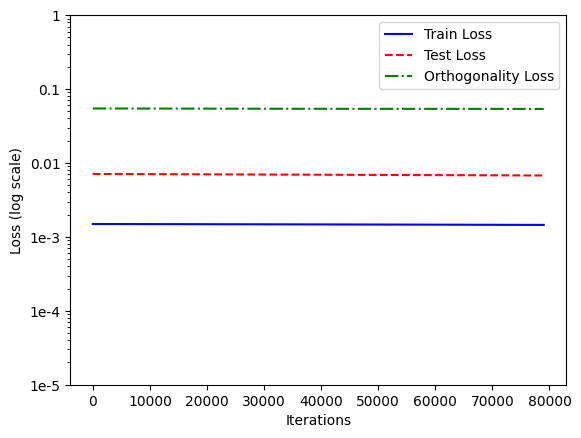

Iteration: 79500 Train_loss:0.0014512974303215742, Test_loss: 0.006766866892576218, ortho_loss:0.05383734777569771
Iteration: 80000 Train_loss:0.0014509848551824689, Test_loss: 0.006764375604689121, ortho_loss:0.053834833204746246


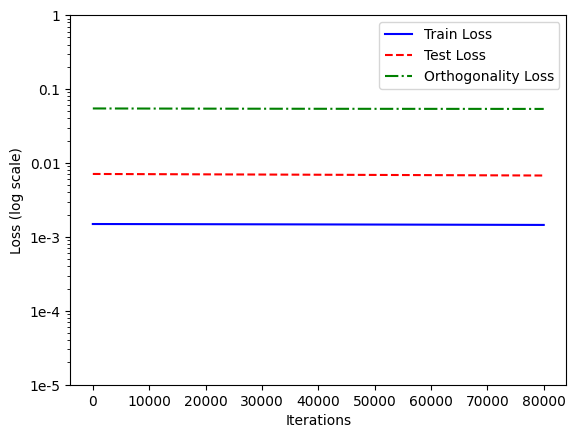

Iteration: 80500 Train_loss:0.001450671348720789, Test_loss: 0.006761876400560141, ortho_loss:0.05383054539561272
Iteration: 81000 Train_loss:0.0014503587735816836, Test_loss: 0.006759359035640955, ortho_loss:0.05383126437664032


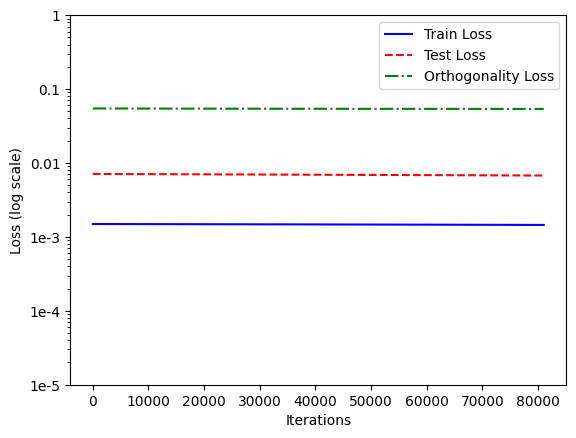

Iteration: 81500 Train_loss:0.0014500399120151997, Test_loss: 0.006756842602044344, ortho_loss:0.05382801592350006
Iteration: 82000 Train_loss:0.0014497266383841634, Test_loss: 0.00675435783341527, ortho_loss:0.0538296140730381


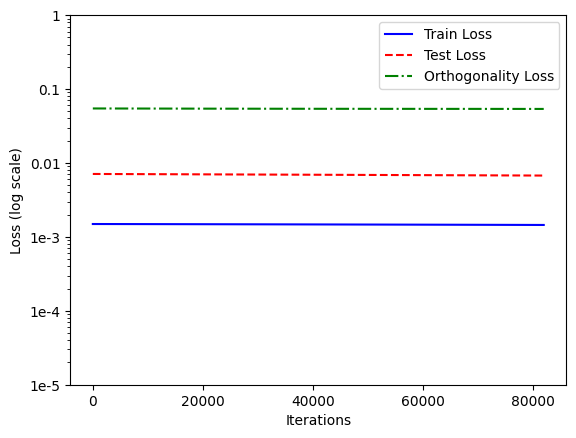

Iteration: 82500 Train_loss:0.0014494069619104266, Test_loss: 0.0067518604919314384, ortho_loss:0.05382824316620827
Iteration: 83000 Train_loss:0.0014490931062027812, Test_loss: 0.006749371998012066, ortho_loss:0.053831152617931366


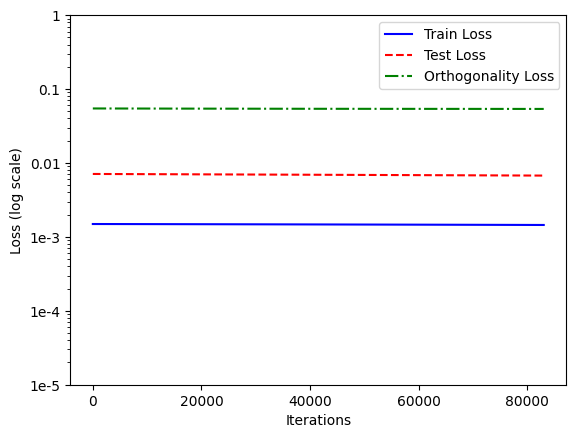

Iteration: 83500 Train_loss:0.001448775758035481, Test_loss: 0.006746891885995865, ortho_loss:0.0538313165307045
Iteration: 84000 Train_loss:0.0014484525891020894, Test_loss: 0.006744428537786007, ortho_loss:0.05383123829960823


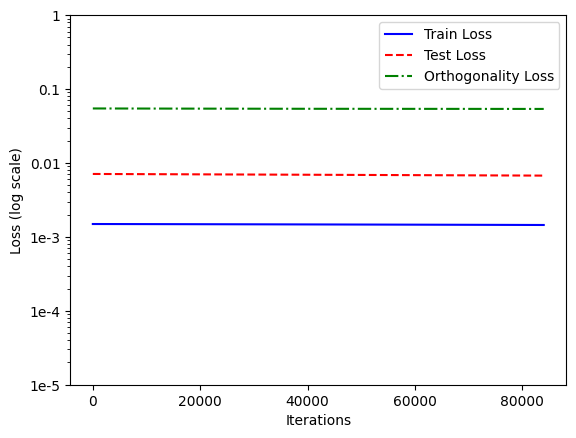

Iteration: 84500 Train_loss:0.0014481325633823872, Test_loss: 0.006741982884705067, ortho_loss:0.05382588133215904
Iteration: 85000 Train_loss:0.0014478130033239722, Test_loss: 0.0067395493388175964, ortho_loss:0.05382467806339264


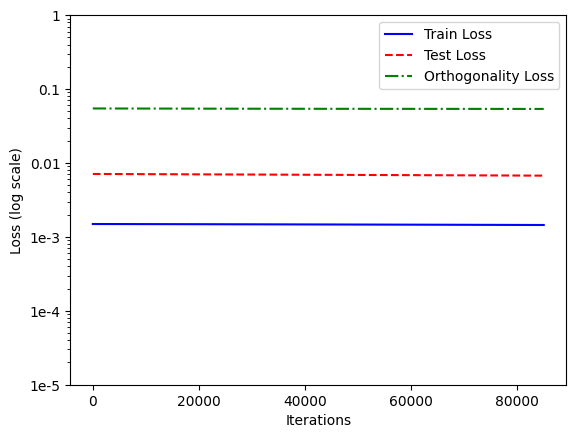

Iteration: 85500 Train_loss:0.0014474899508059025, Test_loss: 0.006737097166478634, ortho_loss:0.05381910502910614
Iteration: 86000 Train_loss:0.00144716608338058, Test_loss: 0.006734646391123533, ortho_loss:0.05381765216588974


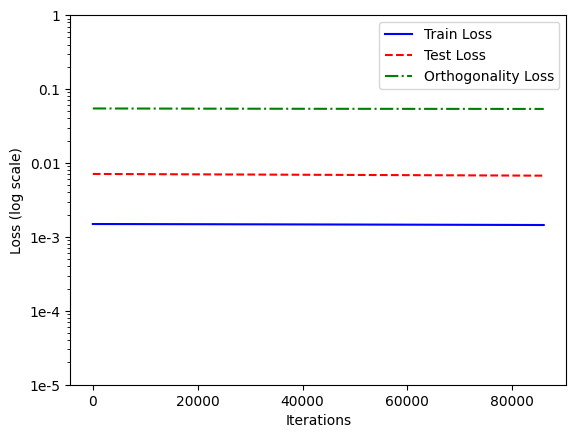

Iteration: 86500 Train_loss:0.0014468419831246138, Test_loss: 0.006732192821800709, ortho_loss:0.053814634680747986
Iteration: 87000 Train_loss:0.0014465247513726354, Test_loss: 0.006729732267558575, ortho_loss:0.05381539836525917


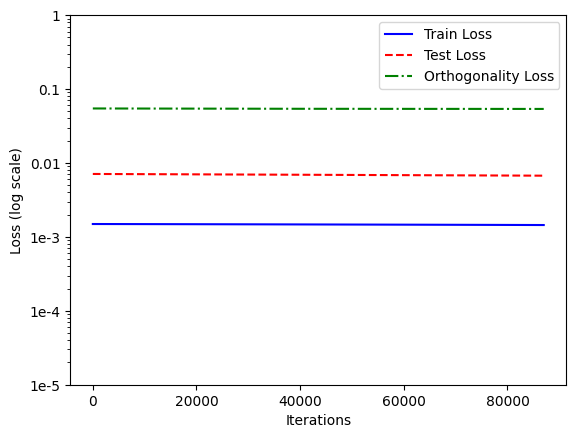

Iteration: 87500 Train_loss:0.0014462015824392438, Test_loss: 0.006727293133735657, ortho_loss:0.053812649101018906
Iteration: 88000 Train_loss:0.0014458730584010482, Test_loss: 0.00672487635165453, ortho_loss:0.05381306633353233


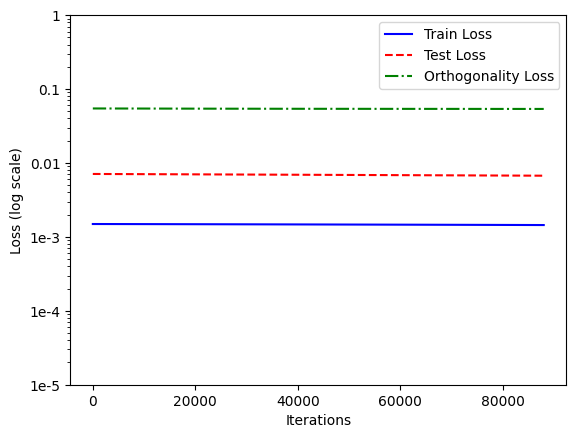

Iteration: 88500 Train_loss:0.0014455481432378292, Test_loss: 0.006722421385347843, ortho_loss:0.053810004144907
Iteration: 89000 Train_loss:0.0014452263712882996, Test_loss: 0.006719951517879963, ortho_loss:0.05380519852042198


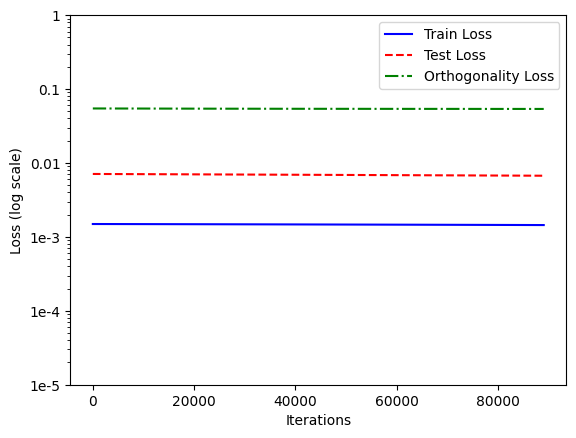

Iteration: 89500 Train_loss:0.001444900524802506, Test_loss: 0.0067174616269767284, ortho_loss:0.05380202457308769
Iteration: 90000 Train_loss:0.0014445733977481723, Test_loss: 0.006714994553476572, ortho_loss:0.0538068562746048


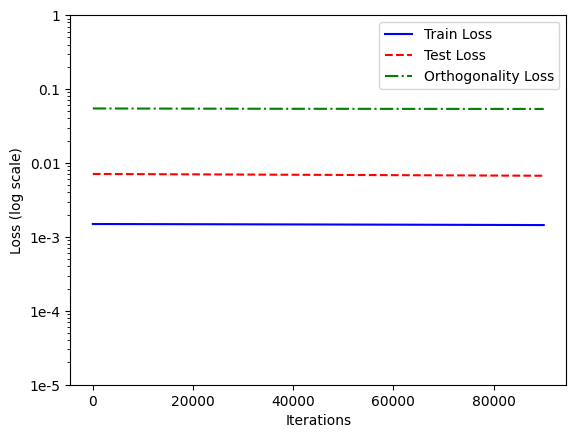

Iteration: 90500 Train_loss:0.0014442505780607462, Test_loss: 0.006712500937283039, ortho_loss:0.053806837648153305
Iteration: 91000 Train_loss:0.0014439241494983435, Test_loss: 0.006710021290928125, ortho_loss:0.0538049079477787


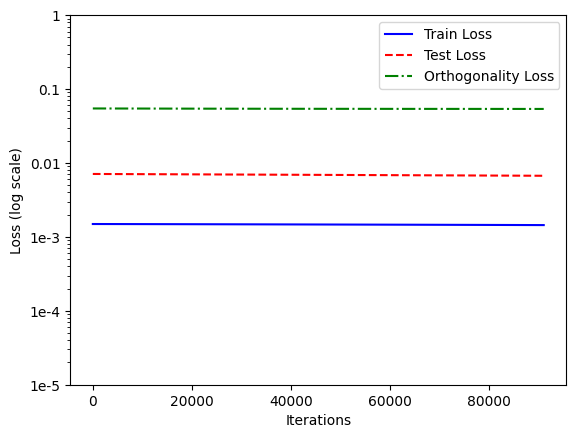

Iteration: 91500 Train_loss:0.0014435934135690331, Test_loss: 0.006707550957798958, ortho_loss:0.053807541728019714
Iteration: 92000 Train_loss:0.0014432627940550447, Test_loss: 0.006705134641379118, ortho_loss:0.05379857122898102


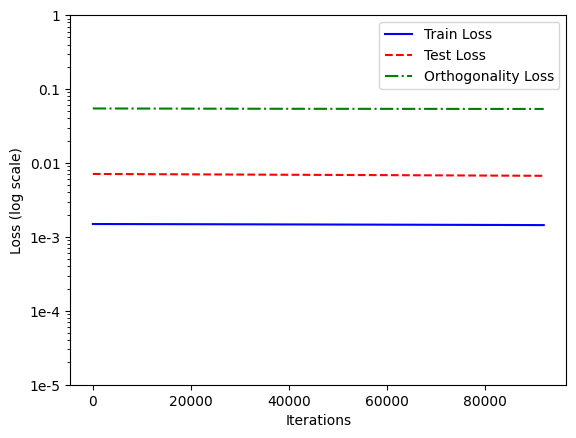

Iteration: 92500 Train_loss:0.0014429317088797688, Test_loss: 0.006702670361846685, ortho_loss:0.05380262807011604
Iteration: 93000 Train_loss:0.0014426070265471935, Test_loss: 0.00670020142570138, ortho_loss:0.0537964403629303


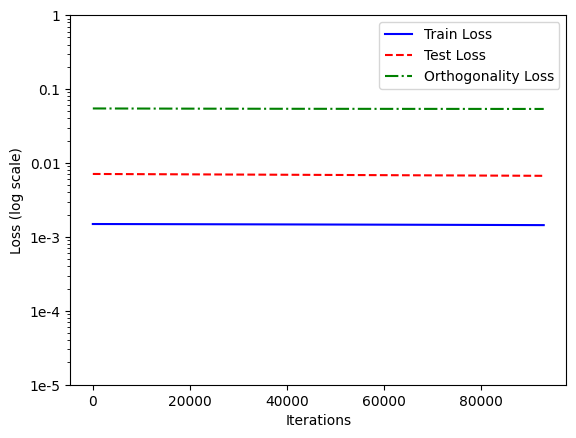

Iteration: 93500 Train_loss:0.0014422774547711015, Test_loss: 0.006697700824588537, ortho_loss:0.053794555366039276
Iteration: 94000 Train_loss:0.00144194217864424, Test_loss: 0.006695201620459557, ortho_loss:0.05379201099276543


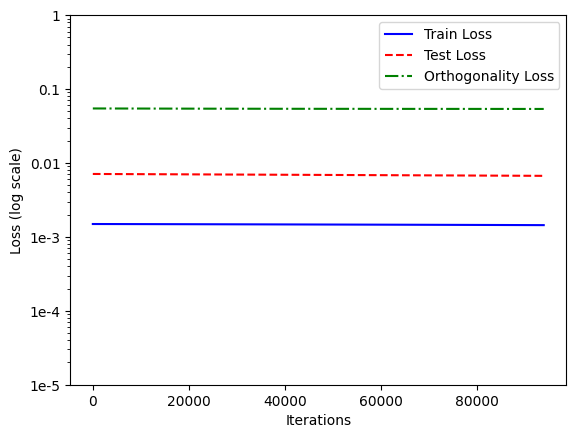

Iteration: 94500 Train_loss:0.0014416052727028728, Test_loss: 0.0066927052102983, ortho_loss:0.053790051490068436
Iteration: 95000 Train_loss:0.0014412772143259645, Test_loss: 0.006690233945846558, ortho_loss:0.05378882214426994


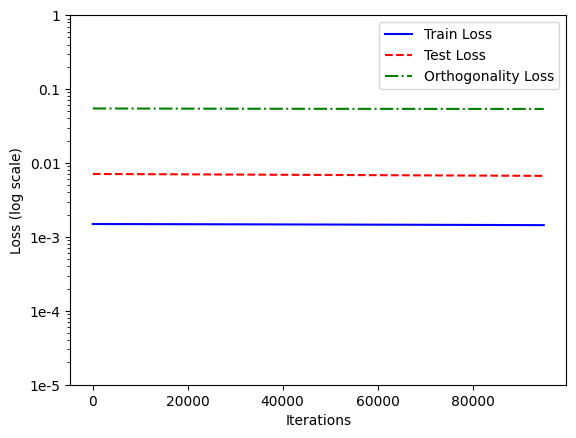

Iteration: 95500 Train_loss:0.0014409436844289303, Test_loss: 0.00668774638324976, ortho_loss:0.05378825590014458
Iteration: 96000 Train_loss:0.0014406085247173905, Test_loss: 0.00668526254594326, ortho_loss:0.05378420650959015


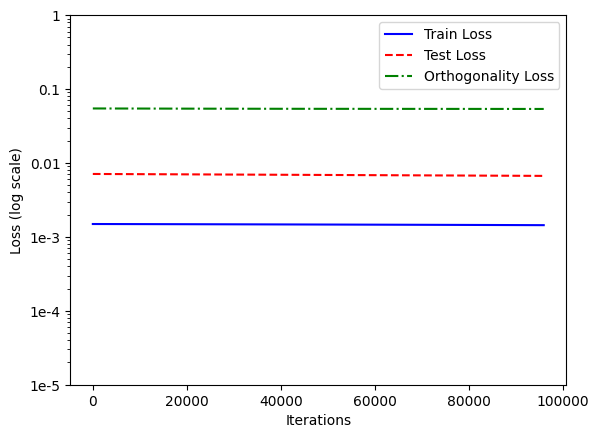

Iteration: 96500 Train_loss:0.0014402763918042183, Test_loss: 0.00668276846408844, ortho_loss:0.05378710851073265
Iteration: 97000 Train_loss:0.0014399390202015638, Test_loss: 0.006680270191282034, ortho_loss:0.053782615810632706


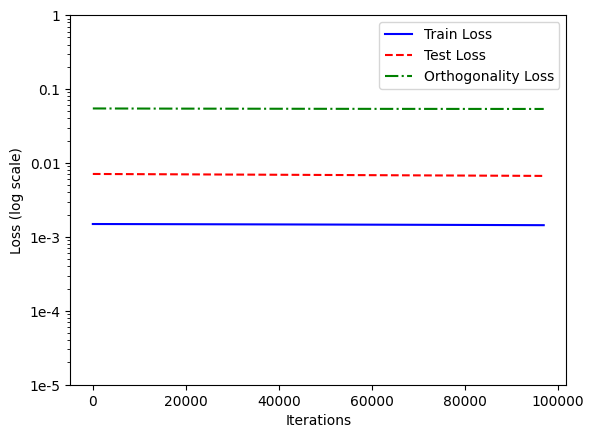

Iteration: 97500 Train_loss:0.001439604558981955, Test_loss: 0.006677791941910982, ortho_loss:0.05378488823771477
Iteration: 98000 Train_loss:0.001439267536625266, Test_loss: 0.006675335578620434, ortho_loss:0.05378296598792076


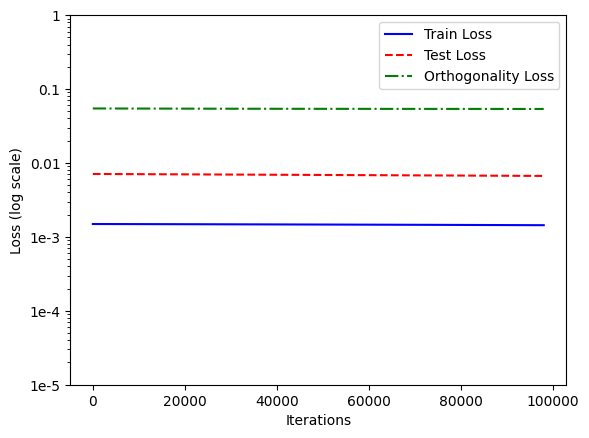

Iteration: 98500 Train_loss:0.001438930514268577, Test_loss: 0.006672892719507217, ortho_loss:0.053786952048540115
Iteration: 99000 Train_loss:0.0014385923277586699, Test_loss: 0.006670456845313311, ortho_loss:0.053783826529979706


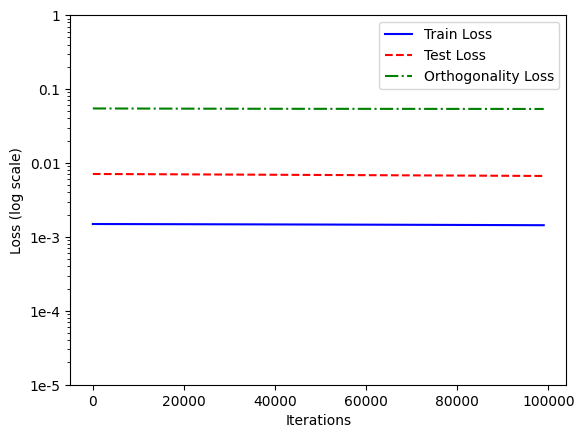

Iteration: 99500 Train_loss:0.0014382506487891078, Test_loss: 0.00666804239153862, ortho_loss:0.05378173291683197
Iteration: 100000 Train_loss:0.0014379125786945224, Test_loss: 0.006665654480457306, ortho_loss:0.05378555506467819


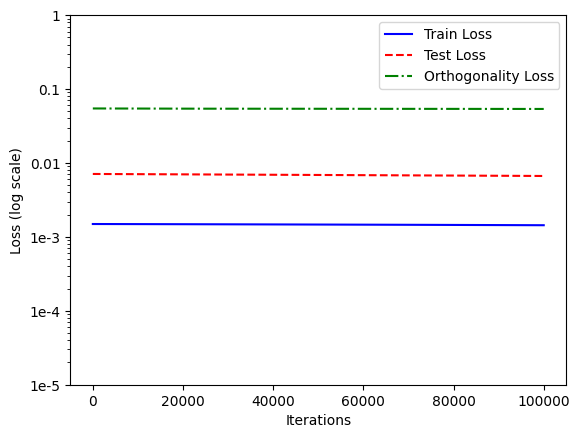

Iteration: 100500 Train_loss:0.0014375702012330294, Test_loss: 0.006663262844085693, ortho_loss:0.05377892777323723
Iteration: 101000 Train_loss:0.0014372315490618348, Test_loss: 0.00666089216247201, ortho_loss:0.053779635578393936


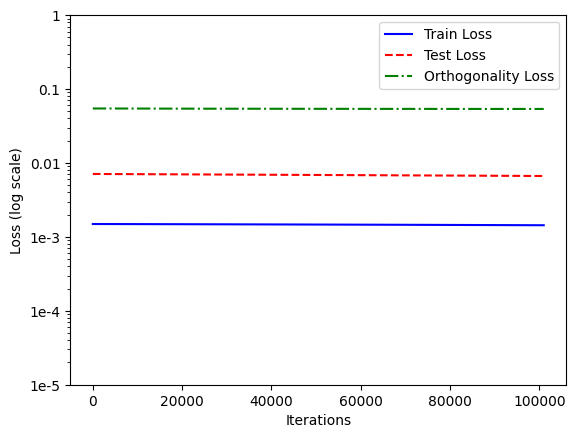

Iteration: 101500 Train_loss:0.001436886959709227, Test_loss: 0.006658507511019707, ortho_loss:0.05378800630569458
Iteration: 102000 Train_loss:0.001436547376215458, Test_loss: 0.0066561452113091946, ortho_loss:0.05378536134958267


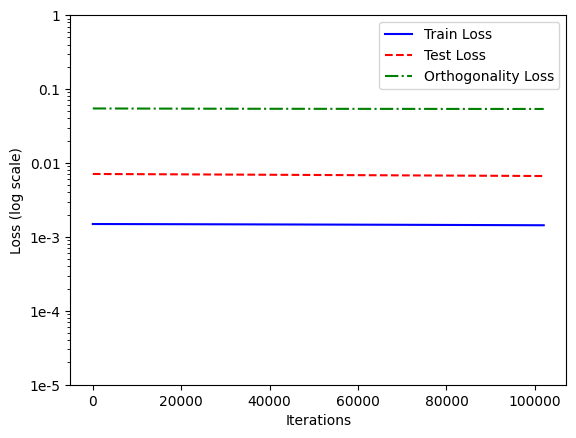

Iteration: 102500 Train_loss:0.0014362061629071832, Test_loss: 0.00665378337725997, ortho_loss:0.05377819761633873
Iteration: 103000 Train_loss:0.0014358606422320008, Test_loss: 0.006651452276855707, ortho_loss:0.05377790331840515


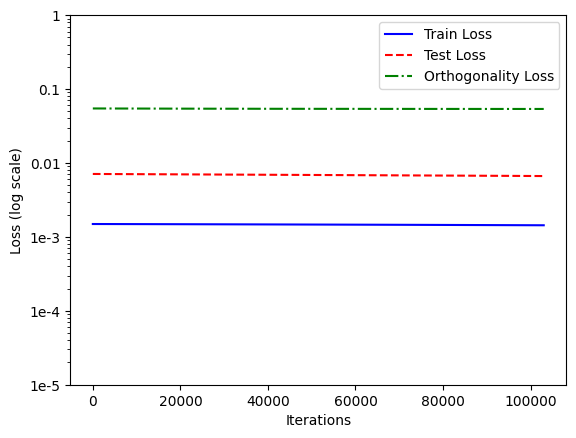

Iteration: 103500 Train_loss:0.001435514073818922, Test_loss: 0.006649097427725792, ortho_loss:0.05378023162484169
Iteration: 104000 Train_loss:0.0014351694844663143, Test_loss: 0.00664678867906332, ortho_loss:0.05377590283751488


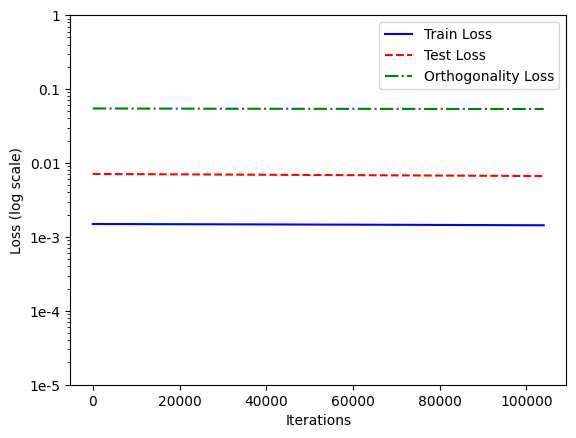

Iteration: 104500 Train_loss:0.0014348214026540518, Test_loss: 0.006644484121352434, ortho_loss:0.05377882719039917
Iteration: 105000 Train_loss:0.0014344776282086968, Test_loss: 0.006642177235335112, ortho_loss:0.05377214401960373


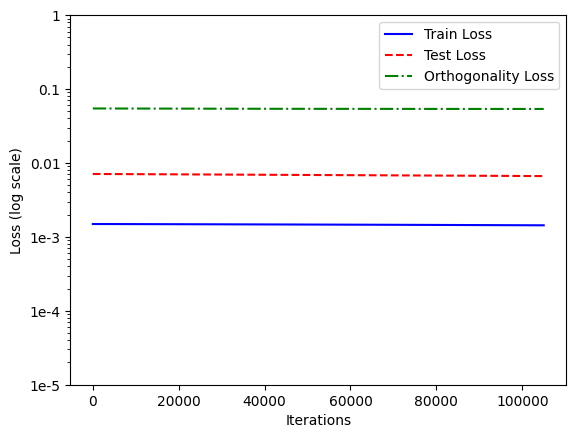

Iteration: 105500 Train_loss:0.00143413245677948, Test_loss: 0.0066398498602211475, ortho_loss:0.05376950278878212
Iteration: 106000 Train_loss:0.0014337878674268723, Test_loss: 0.0066375331953167915, ortho_loss:0.05377252399921417


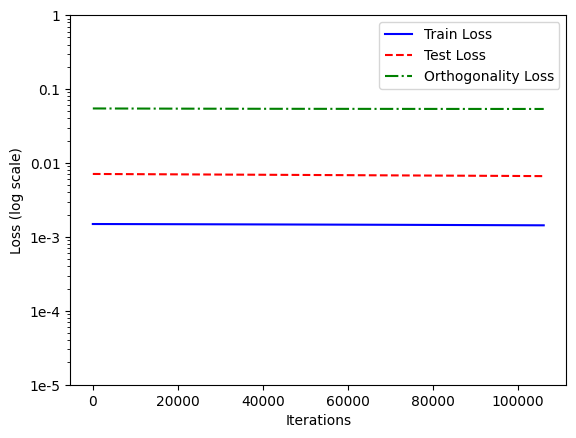

Iteration: 106500 Train_loss:0.0014334360603243113, Test_loss: 0.0066352058202028275, ortho_loss:0.05377047136425972
Iteration: 107000 Train_loss:0.0014330855337902904, Test_loss: 0.006632891017943621, ortho_loss:0.053770534694194794


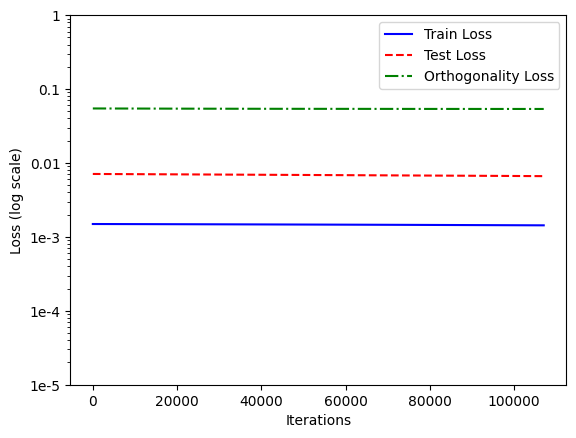

Iteration: 107500 Train_loss:0.0014327376848086715, Test_loss: 0.00663057342171669, ortho_loss:0.05376766249537468
Iteration: 108000 Train_loss:0.0014323880895972252, Test_loss: 0.006628244649618864, ortho_loss:0.05376528576016426


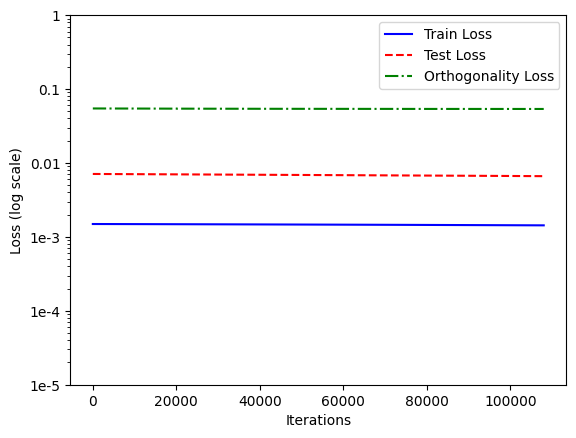

Iteration: 108500 Train_loss:0.0014320369809865952, Test_loss: 0.0066259088926017284, ortho_loss:0.05375954881310463
Iteration: 109000 Train_loss:0.0014316851738840342, Test_loss: 0.0066235740669071674, ortho_loss:0.0537579171359539


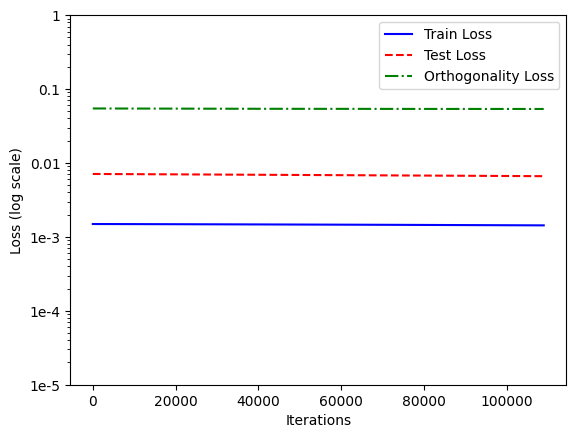

Iteration: 109500 Train_loss:0.0014313356950879097, Test_loss: 0.006621229462325573, ortho_loss:0.05375729873776436
Iteration: 110000 Train_loss:0.0014309814432635903, Test_loss: 0.006618874613195658, ortho_loss:0.05376520752906799


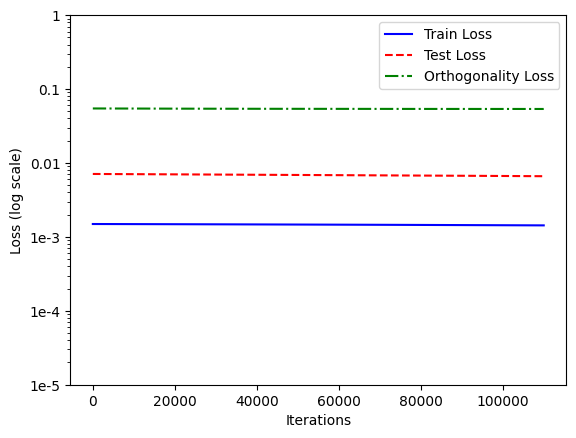

Iteration: 110500 Train_loss:0.0014306290540844202, Test_loss: 0.006616515107452869, ortho_loss:0.05375836789608002
Iteration: 111000 Train_loss:0.00143027538433671, Test_loss: 0.006614172365516424, ortho_loss:0.05375310778617859


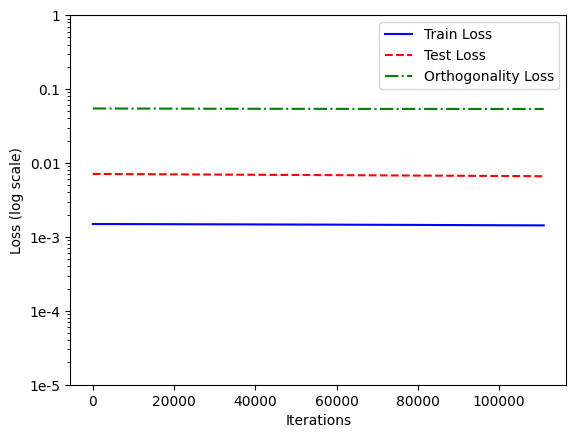

Iteration: 111500 Train_loss:0.0014299149625003338, Test_loss: 0.0066117881797254086, ortho_loss:0.05375001206994057
Iteration: 112000 Train_loss:0.001429563737474382, Test_loss: 0.006609390489757061, ortho_loss:0.05375479534268379


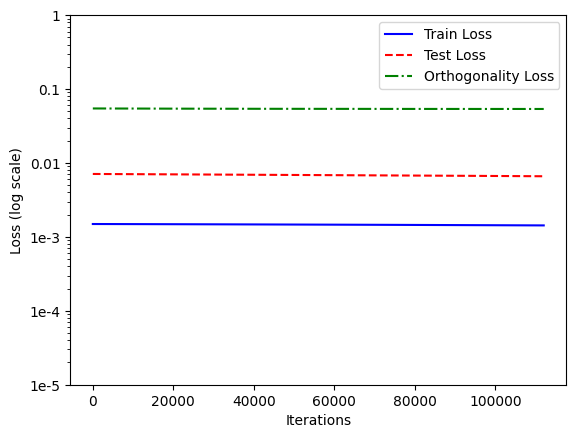

Iteration: 112500 Train_loss:0.0014292038977146149, Test_loss: 0.006607008166611195, ortho_loss:0.05375335365533829
Iteration: 113000 Train_loss:0.0014288515085354447, Test_loss: 0.006604629103094339, ortho_loss:0.05375036224722862


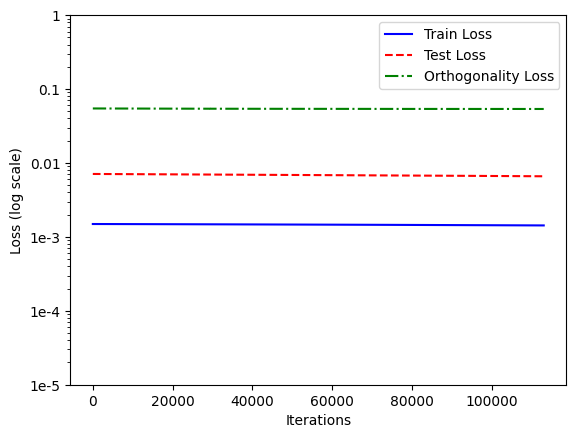

Iteration: 113500 Train_loss:0.001428490853868425, Test_loss: 0.006602226756513119, ortho_loss:0.05375044420361519
Iteration: 114000 Train_loss:0.0014281318290159106, Test_loss: 0.006599851883947849, ortho_loss:0.053749486804008484


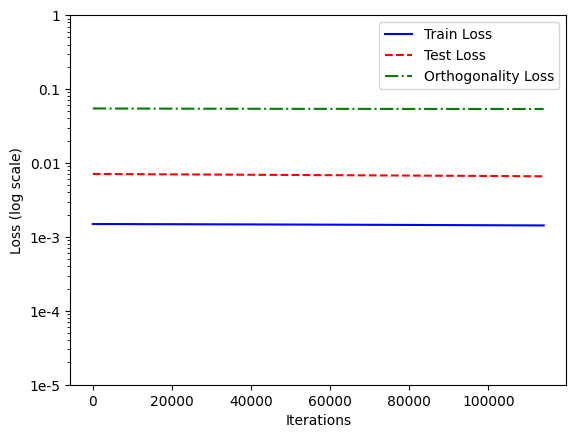

Iteration: 114500 Train_loss:0.0014277729205787182, Test_loss: 0.006597475614398718, ortho_loss:0.05375147610902786
Iteration: 115000 Train_loss:0.0014274145942181349, Test_loss: 0.006595090497285128, ortho_loss:0.05374183505773544


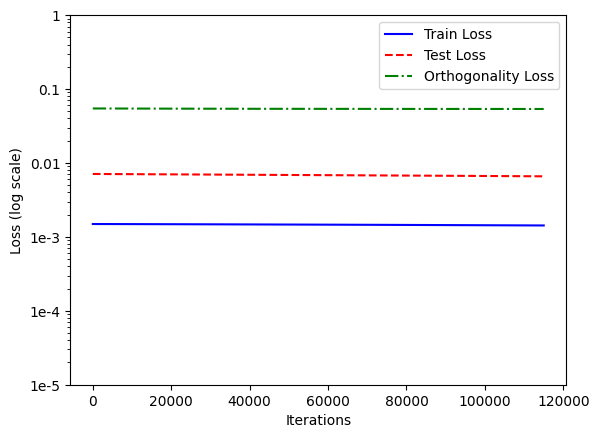

Iteration: 115500 Train_loss:0.0014270545216277242, Test_loss: 0.006592692341655493, ortho_loss:0.053749825805425644
Iteration: 116000 Train_loss:0.0014266913058236241, Test_loss: 0.006590291392058134, ortho_loss:0.05374780297279358


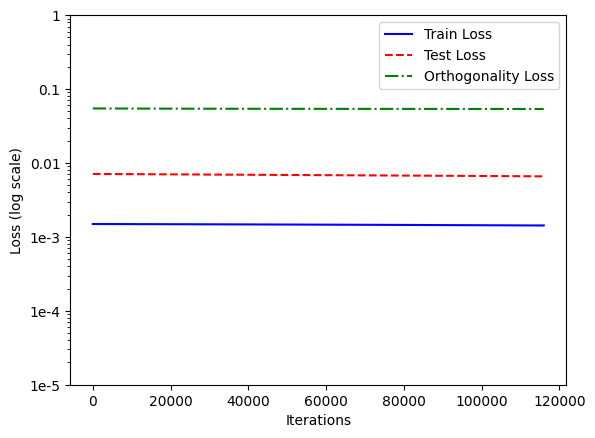

Iteration: 116500 Train_loss:0.0014263322809711099, Test_loss: 0.006587862502783537, ortho_loss:0.0537463016808033
Iteration: 117000 Train_loss:0.0014259747695177794, Test_loss: 0.006585451774299145, ortho_loss:0.05374084413051605


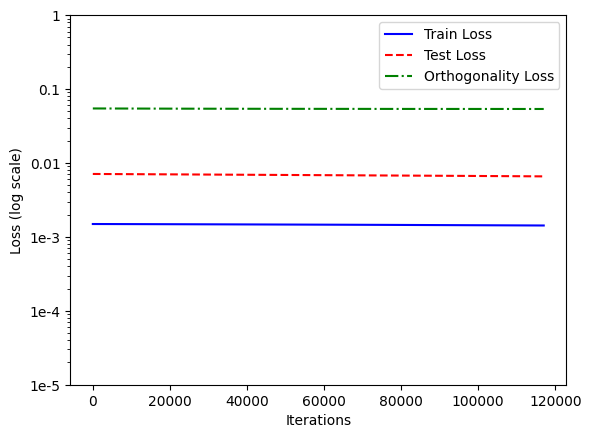

Iteration: 117500 Train_loss:0.0014256135327741504, Test_loss: 0.006583017762750387, ortho_loss:0.053742147982120514
Iteration: 118000 Train_loss:0.0014252503169700503, Test_loss: 0.006580580025911331, ortho_loss:0.053742654621601105


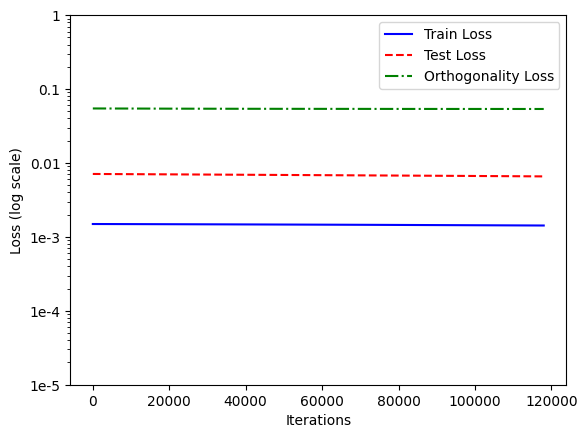

Iteration: 118500 Train_loss:0.001424891408532858, Test_loss: 0.006578142289072275, ortho_loss:0.0537409745156765
Iteration: 119000 Train_loss:0.0014245276106521487, Test_loss: 0.006575691048055887, ortho_loss:0.053739260882139206


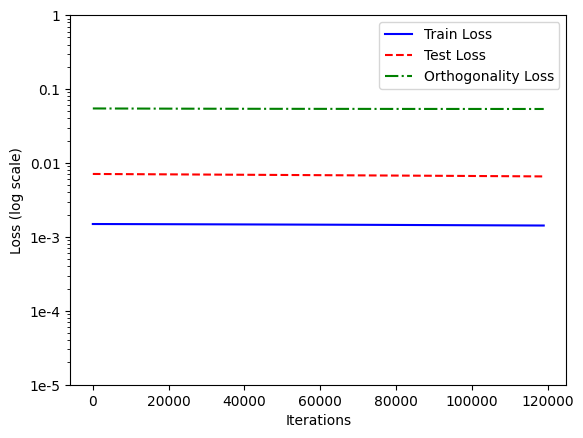

Iteration: 119500 Train_loss:0.0014241616008803248, Test_loss: 0.006573248654603958, ortho_loss:0.053737107664346695
Iteration: 120000 Train_loss:0.0014238007133826613, Test_loss: 0.0065708099864423275, ortho_loss:0.053740352392196655


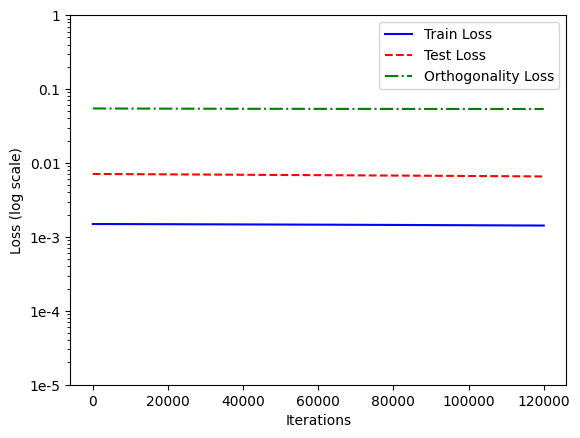

Iteration: 120500 Train_loss:0.0014234352856874466, Test_loss: 0.006568373646587133, ortho_loss:0.053738709539175034
Iteration: 121000 Train_loss:0.001423071720637381, Test_loss: 0.006565931718796492, ortho_loss:0.05373686924576759


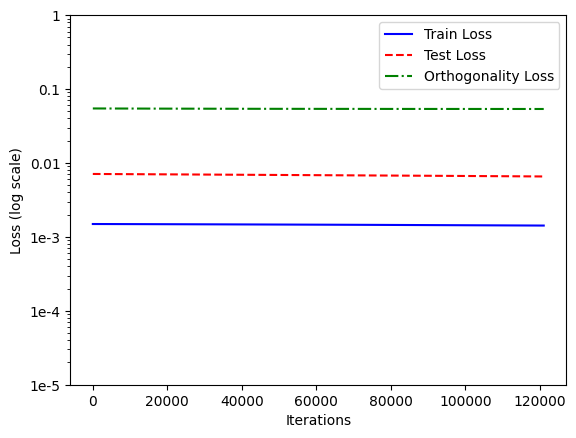

Iteration: 121500 Train_loss:0.001422703149728477, Test_loss: 0.00656352611258626, ortho_loss:0.05373981222510338
Iteration: 122000 Train_loss:0.0014223388861864805, Test_loss: 0.0065611000172793865, ortho_loss:0.05373888835310936


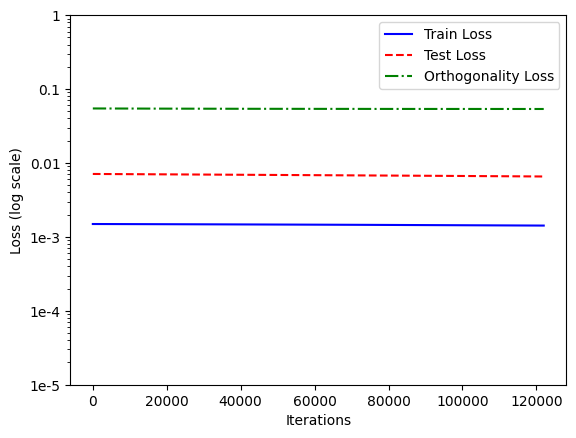

Iteration: 122500 Train_loss:0.0014219682198017836, Test_loss: 0.006558675784617662, ortho_loss:0.053737420588731766
Iteration: 123000 Train_loss:0.001421601278707385, Test_loss: 0.006556266453117132, ortho_loss:0.053735118359327316


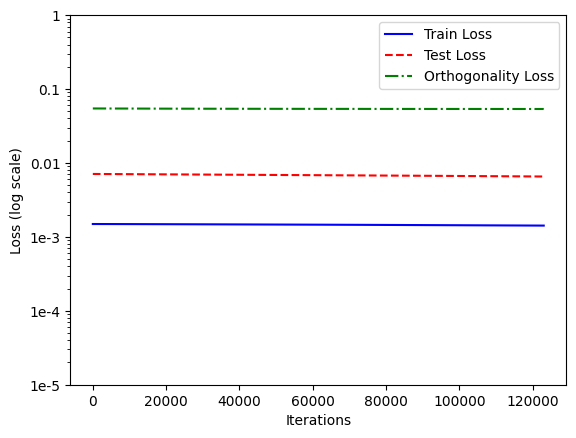

Iteration: 123500 Train_loss:0.0014212315436452627, Test_loss: 0.0065538291819393635, ortho_loss:0.05373447388410568
Iteration: 124000 Train_loss:0.001420861342921853, Test_loss: 0.006551384460180998, ortho_loss:0.05373279005289078


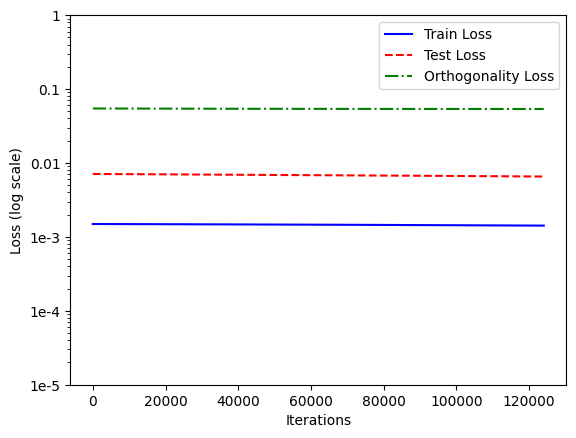

Iteration: 124500 Train_loss:0.0014204945182427764, Test_loss: 0.006548925768584013, ortho_loss:0.05373450741171837
Iteration: 125000 Train_loss:0.0014201236190274358, Test_loss: 0.006546427495777607, ortho_loss:0.053735941648483276


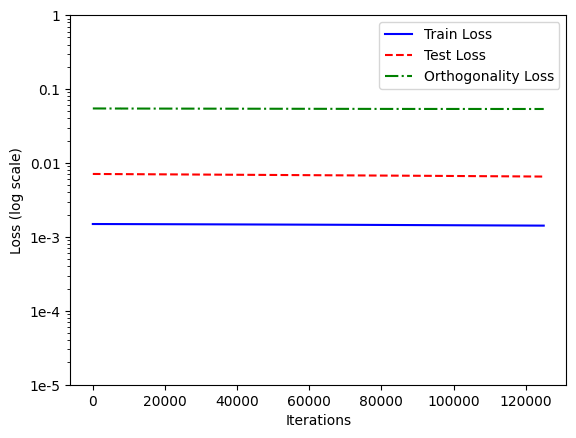

Iteration: 125500 Train_loss:0.0014197516720741987, Test_loss: 0.006543940398842096, ortho_loss:0.0537358820438385
Iteration: 126000 Train_loss:0.0014193777460604906, Test_loss: 0.006541438400745392, ortho_loss:0.053740352392196655


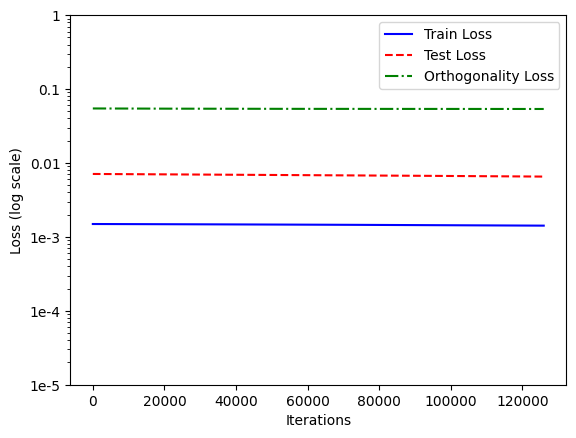

Iteration: 126500 Train_loss:0.001419009524397552, Test_loss: 0.006538934074342251, ortho_loss:0.053733352571725845
Iteration: 127000 Train_loss:0.0014186394400894642, Test_loss: 0.006536465138196945, ortho_loss:0.053740955889225006


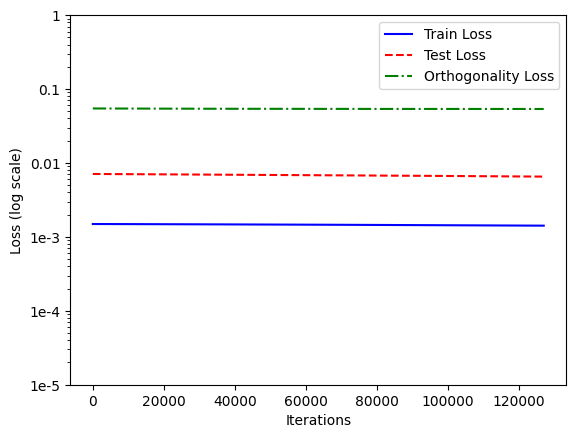

Iteration: 127500 Train_loss:0.0014182663289830089, Test_loss: 0.006533987354487181, ortho_loss:0.05373866483569145
Iteration: 128000 Train_loss:0.0014178900746628642, Test_loss: 0.006531520280987024, ortho_loss:0.05373241379857063


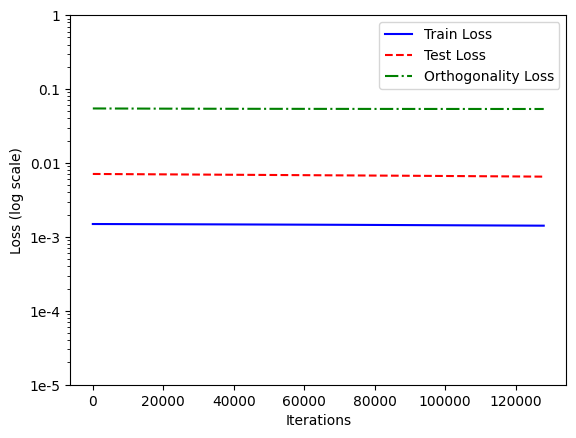

Iteration: 128500 Train_loss:0.0014175149844959378, Test_loss: 0.006529067177325487, ortho_loss:0.05372568592429161
Iteration: 129000 Train_loss:0.0014171403599902987, Test_loss: 0.006526613142341375, ortho_loss:0.053735557943582535


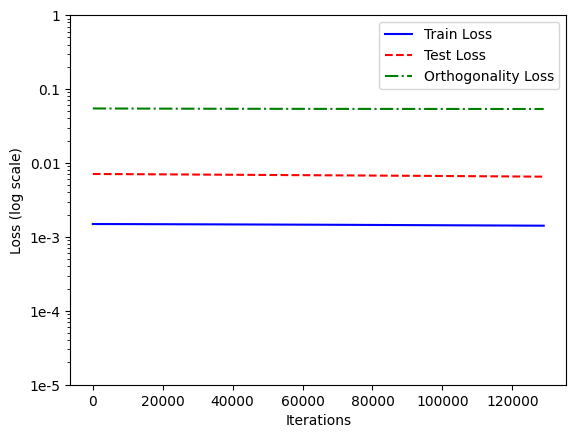

Iteration: 129500 Train_loss:0.001416765502654016, Test_loss: 0.006524196360260248, ortho_loss:0.05372800678014755
Iteration: 130000 Train_loss:0.0014163895975798368, Test_loss: 0.0065217530354857445, ortho_loss:0.05372678115963936


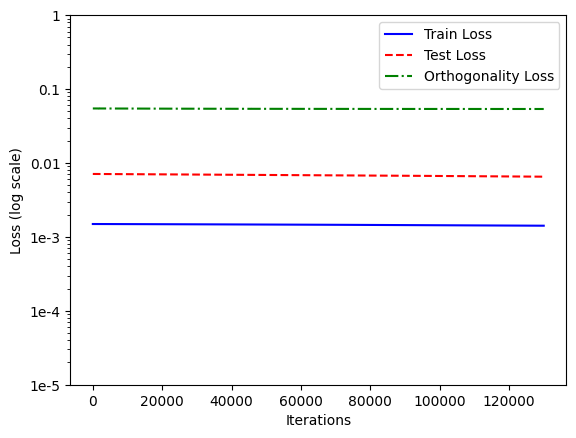

Iteration: 130500 Train_loss:0.0014160099672153592, Test_loss: 0.006519331131130457, ortho_loss:0.05373074859380722
Iteration: 131000 Train_loss:0.0014156380202621222, Test_loss: 0.006516935769468546, ortho_loss:0.05372606962919235


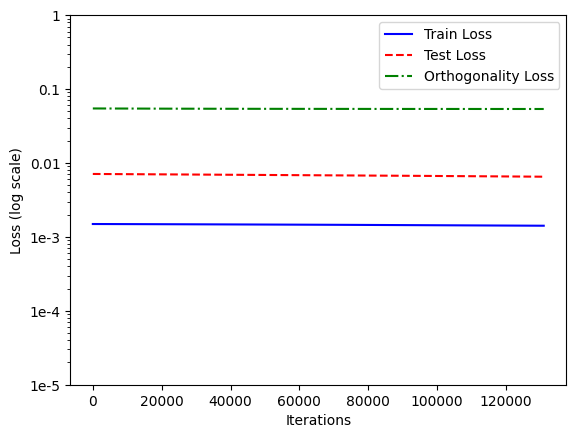

Iteration: 131500 Train_loss:0.001415256061591208, Test_loss: 0.006514541804790497, ortho_loss:0.05372102931141853
Iteration: 132000 Train_loss:0.0014148754999041557, Test_loss: 0.006512154825031757, ortho_loss:0.05372004956007004


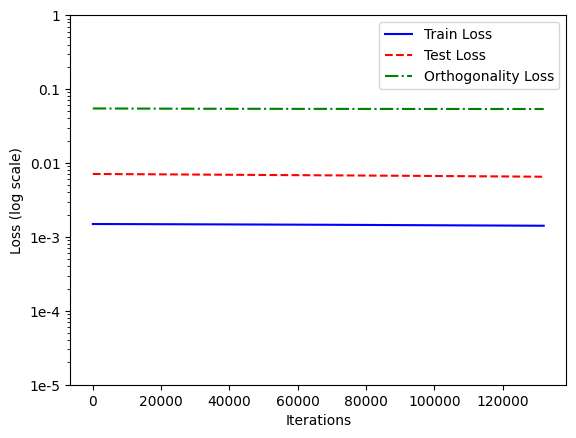

Iteration: 132500 Train_loss:0.0014144910965114832, Test_loss: 0.006509772967547178, ortho_loss:0.05371451750397682
Iteration: 133000 Train_loss:0.0014141133287921548, Test_loss: 0.006507390178740025, ortho_loss:0.0537148118019104


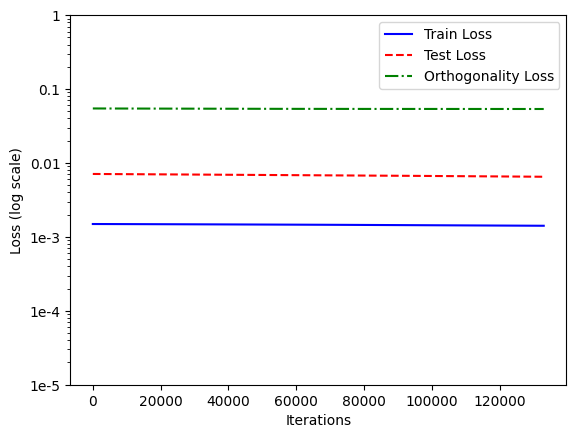

Iteration: 133500 Train_loss:0.0014137314865365624, Test_loss: 0.006505012046545744, ortho_loss:0.05371955782175064
Iteration: 134000 Train_loss:0.001413347665220499, Test_loss: 0.00650265347212553, ortho_loss:0.053715866059064865


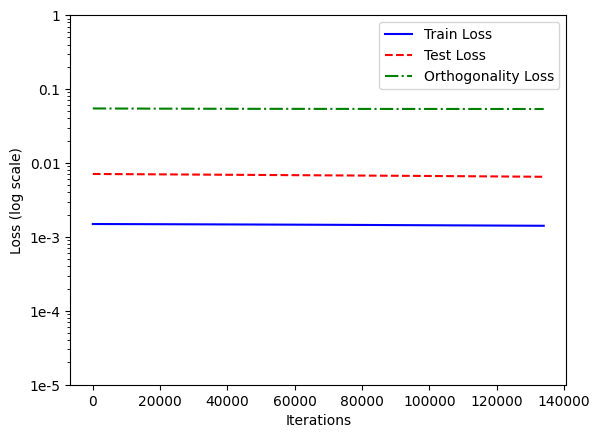

Iteration: 134500 Train_loss:0.0014129732735455036, Test_loss: 0.006500288378447294, ortho_loss:0.05371068790555
Iteration: 135000 Train_loss:0.0014125852612778544, Test_loss: 0.0064979372546076775, ortho_loss:0.05371182784438133


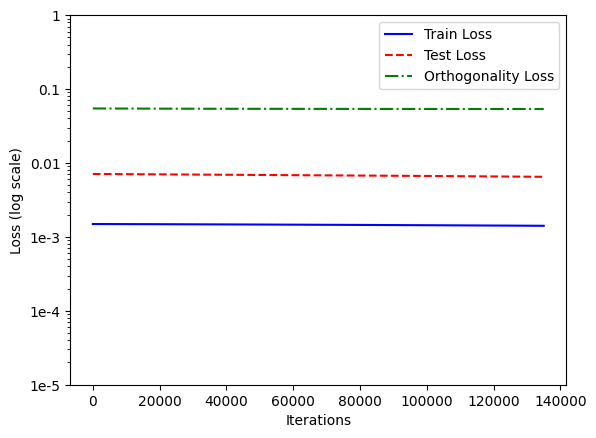

Iteration: 135500 Train_loss:0.001412205514498055, Test_loss: 0.006495581474155188, ortho_loss:0.053716134279966354
Iteration: 136000 Train_loss:0.0014118212275207043, Test_loss: 0.006493249908089638, ortho_loss:0.05371270328760147


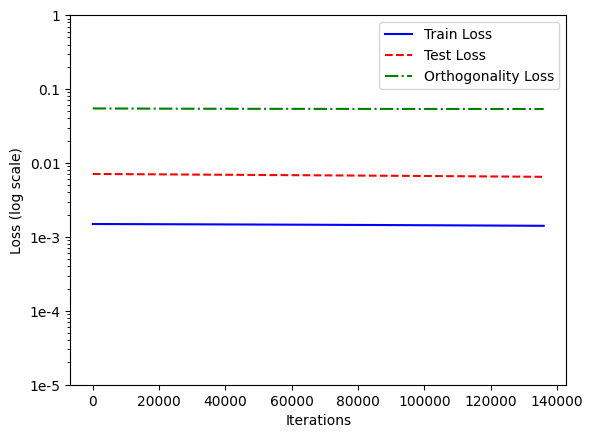

Iteration: 136500 Train_loss:0.0014114375226199627, Test_loss: 0.006490902975201607, ortho_loss:0.05370904877781868
Iteration: 137000 Train_loss:0.0014110504416748881, Test_loss: 0.006488557904958725, ortho_loss:0.05370781943202019


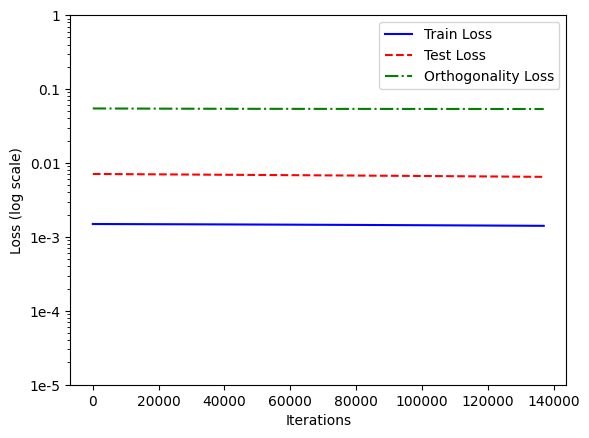

Iteration: 137500 Train_loss:0.001410667086020112, Test_loss: 0.00648622028529644, ortho_loss:0.05370594933629036
Iteration: 138000 Train_loss:0.0014102780260145664, Test_loss: 0.006483881268650293, ortho_loss:0.05370528623461723


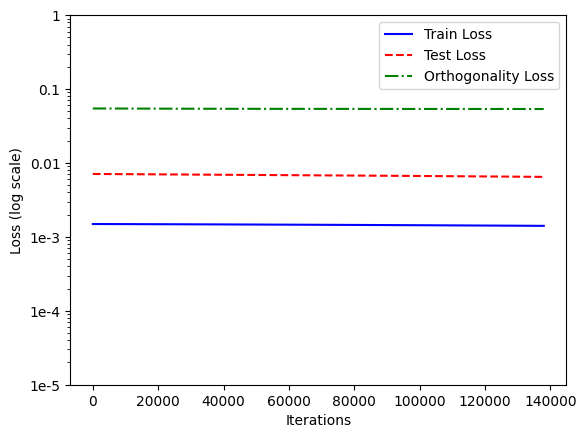

Iteration: 138500 Train_loss:0.0014098944375291467, Test_loss: 0.006481533870100975, ortho_loss:0.05370791628956795
Iteration: 139000 Train_loss:0.0014095086371526122, Test_loss: 0.006479203235358, ortho_loss:0.0537043996155262


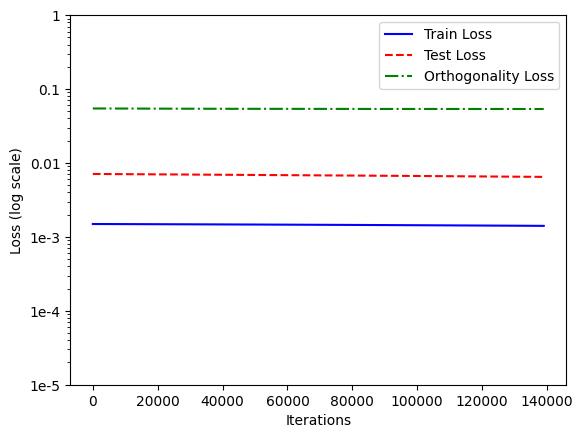

Iteration: 139500 Train_loss:0.0014091262128204107, Test_loss: 0.006476873066276312, ortho_loss:0.05370885133743286
Iteration: 140000 Train_loss:0.001408734475262463, Test_loss: 0.0064745438285171986, ortho_loss:0.05371079221367836


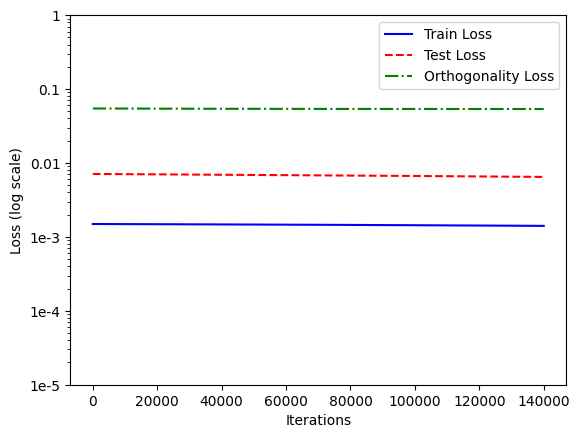

Iteration: 140500 Train_loss:0.0014083519345149398, Test_loss: 0.006472230423241854, ortho_loss:0.05371281877160072
Iteration: 141000 Train_loss:0.0014079598477110267, Test_loss: 0.00646990118548274, ortho_loss:0.05370865762233734


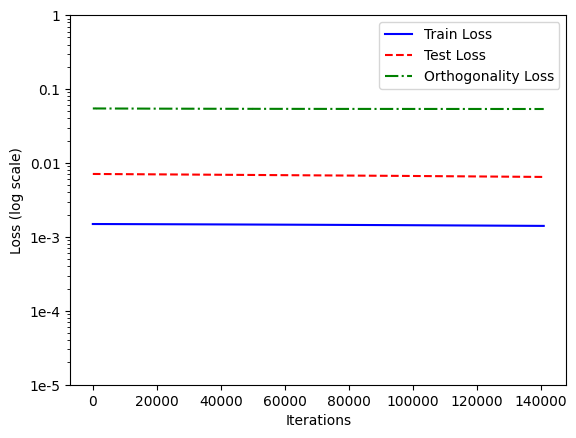

Iteration: 141500 Train_loss:0.0014075760263949633, Test_loss: 0.006467586848884821, ortho_loss:0.05370715260505676
Iteration: 142000 Train_loss:0.0014071888290345669, Test_loss: 0.006465258076786995, ortho_loss:0.05370629206299782


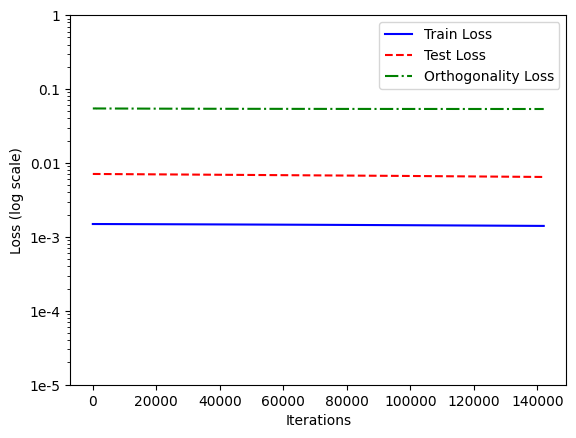

Iteration: 142500 Train_loss:0.0014067996526136994, Test_loss: 0.006462931167334318, ortho_loss:0.053705453872680664
Iteration: 143000 Train_loss:0.001406409777700901, Test_loss: 0.006460598669946194, ortho_loss:0.053707778453826904


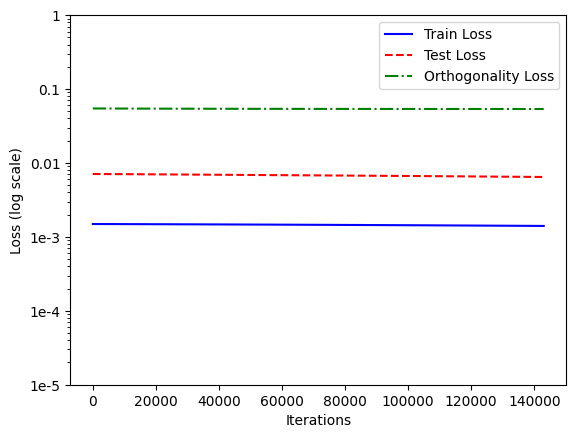

Iteration: 143500 Train_loss:0.0014060201356187463, Test_loss: 0.0064582922495901585, ortho_loss:0.053706295788288116
Iteration: 144000 Train_loss:0.0014056316576898098, Test_loss: 0.006455976516008377, ortho_loss:0.053702179342508316


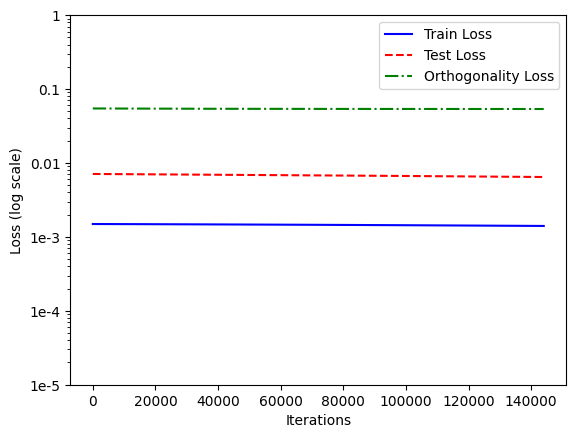

Iteration: 144500 Train_loss:0.001405238639563322, Test_loss: 0.006453655660152435, ortho_loss:0.053704723715782166
Iteration: 145000 Train_loss:0.0014048521406948566, Test_loss: 0.006451326888054609, ortho_loss:0.05369739234447479


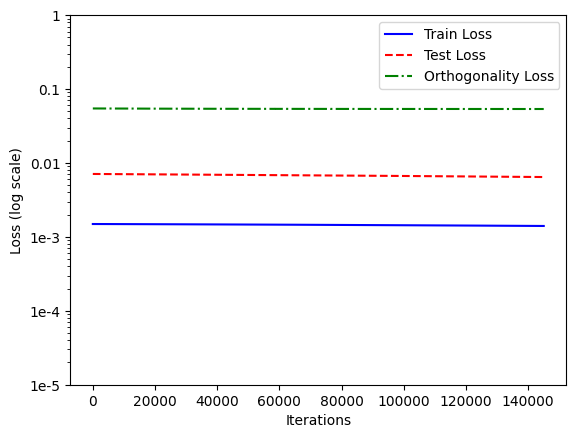

Iteration: 145500 Train_loss:0.0014044598210602999, Test_loss: 0.006449003703892231, ortho_loss:0.0537031888961792
Iteration: 146000 Train_loss:0.0014040714595466852, Test_loss: 0.006446691229939461, ortho_loss:0.05369681864976883


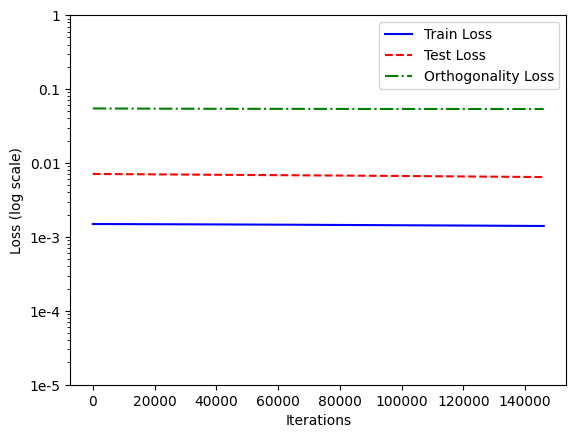

Iteration: 146500 Train_loss:0.00140367541462183, Test_loss: 0.006444362457841635, ortho_loss:0.05369381234049797
Iteration: 147000 Train_loss:0.0014032897306606174, Test_loss: 0.006442038342356682, ortho_loss:0.053695596754550934


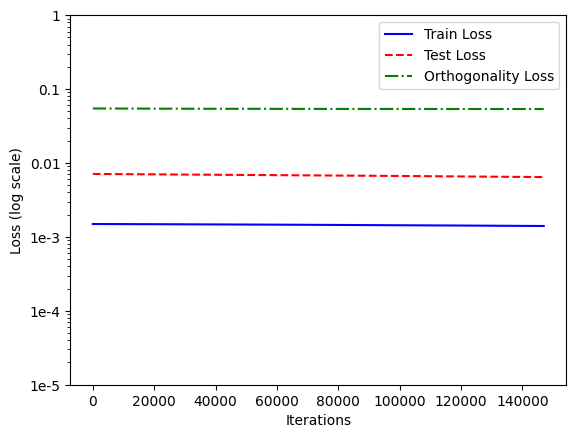

Iteration: 147500 Train_loss:0.0014028914738446474, Test_loss: 0.0064396932721138, ortho_loss:0.05369428172707558
Iteration: 148000 Train_loss:0.0014025012496858835, Test_loss: 0.006437342613935471, ortho_loss:0.05369701609015465


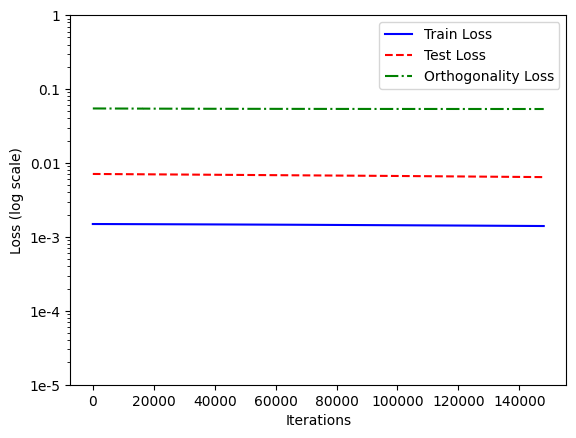

Iteration: 148500 Train_loss:0.0014021052047610283, Test_loss: 0.00643498171120882, ortho_loss:0.05368867889046669
Iteration: 149000 Train_loss:0.001401710556820035, Test_loss: 0.006432616151869297, ortho_loss:0.053684841841459274


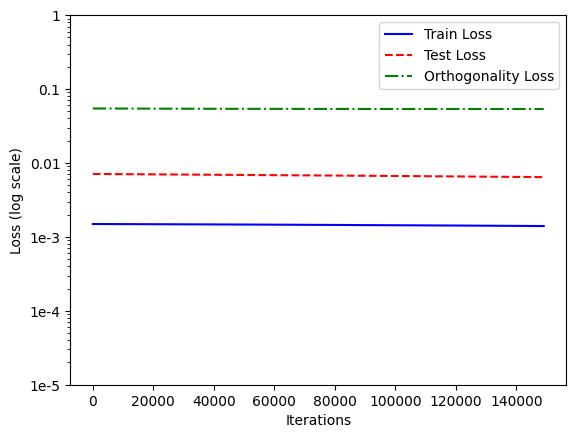

Iteration: 149500 Train_loss:0.0014013214968144894, Test_loss: 0.006430228240787983, ortho_loss:0.053689144551754
Iteration: 150000 Train_loss:0.0014009239384904504, Test_loss: 0.006427860353142023, ortho_loss:0.053690988570451736


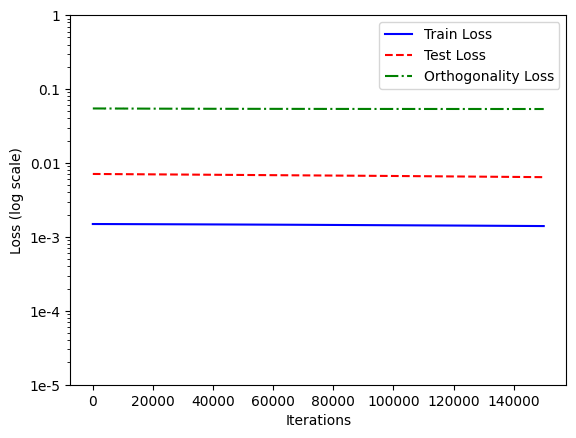

Iteration: 150500 Train_loss:0.001400525332428515, Test_loss: 0.006425484549254179, ortho_loss:0.05368860438466072
Iteration: 151000 Train_loss:0.0014001323143020272, Test_loss: 0.006423088721930981, ortho_loss:0.053680069744586945


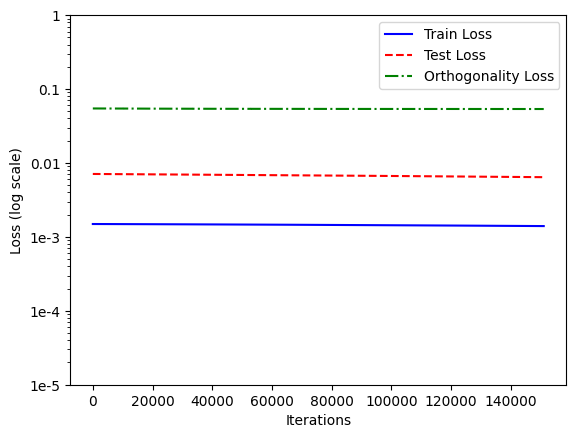

Iteration: 151500 Train_loss:0.0013997339410707355, Test_loss: 0.006420707330107689, ortho_loss:0.05368712916970253
Iteration: 152000 Train_loss:0.001399341388605535, Test_loss: 0.006418297998607159, ortho_loss:0.05368175730109215


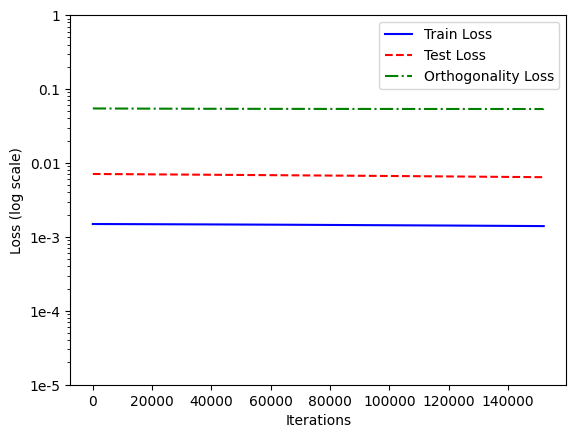

Iteration: 152500 Train_loss:0.0013989440631121397, Test_loss: 0.006415896583348513, ortho_loss:0.053679052740335464
Iteration: 153000 Train_loss:0.001398552325554192, Test_loss: 0.006413494236767292, ortho_loss:0.05367770045995712


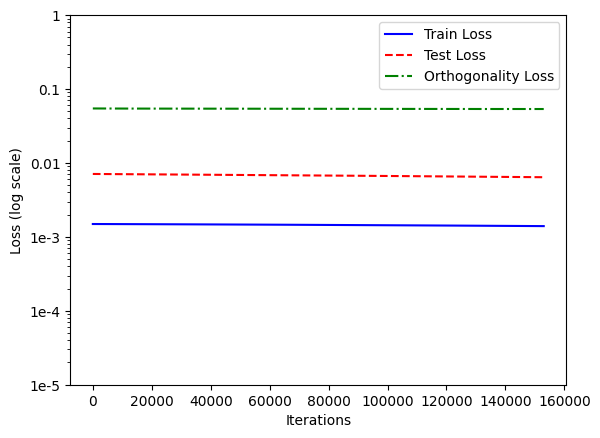

Iteration: 153500 Train_loss:0.001398154767230153, Test_loss: 0.006411108188331127, ortho_loss:0.05367366969585419
Iteration: 154000 Train_loss:0.001397755928337574, Test_loss: 0.006408718414604664, ortho_loss:0.05367230996489525


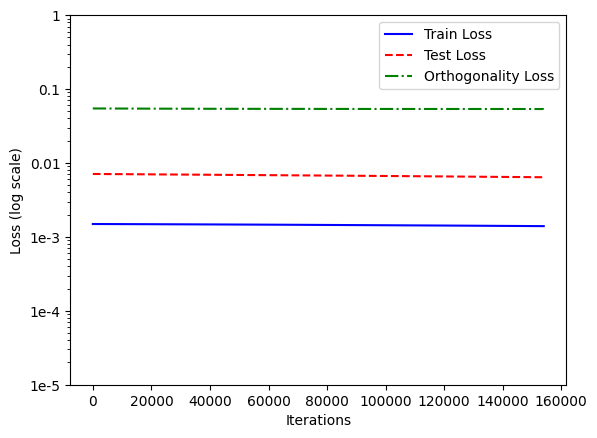

Iteration: 154500 Train_loss:0.0013973598834127188, Test_loss: 0.0064063225872814655, ortho_loss:0.05367923527956009
Iteration: 155000 Train_loss:0.0013969666324555874, Test_loss: 0.0064039225690066814, ortho_loss:0.053675998002290726


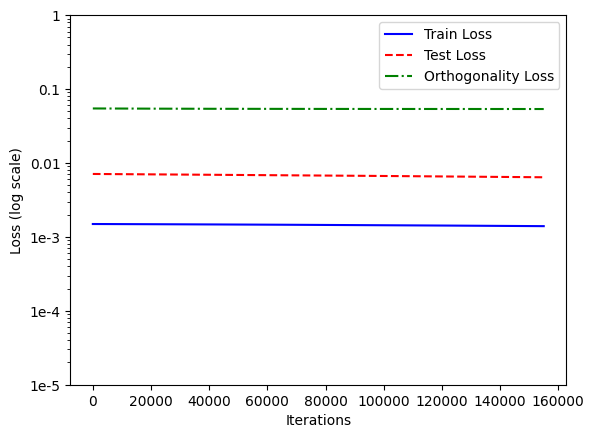

Iteration: 155500 Train_loss:0.00139656534884125, Test_loss: 0.006401493679732084, ortho_loss:0.05367593839764595
Iteration: 156000 Train_loss:0.0013961661607027054, Test_loss: 0.006399056874215603, ortho_loss:0.053675029426813126


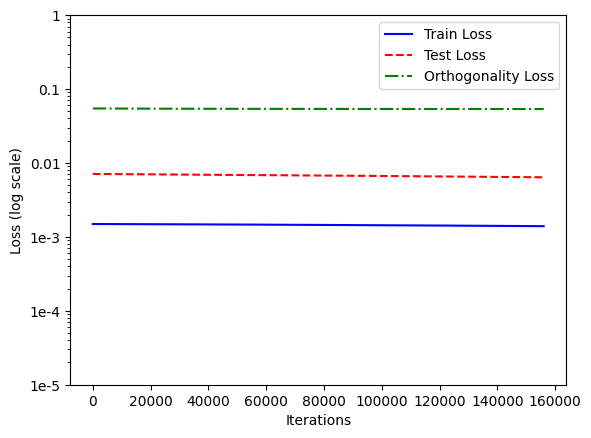

Iteration: 156500 Train_loss:0.00139576755464077, Test_loss: 0.006396621000021696, ortho_loss:0.05367342010140419
Iteration: 157000 Train_loss:0.0013953660381957889, Test_loss: 0.006394198630005121, ortho_loss:0.0536709800362587


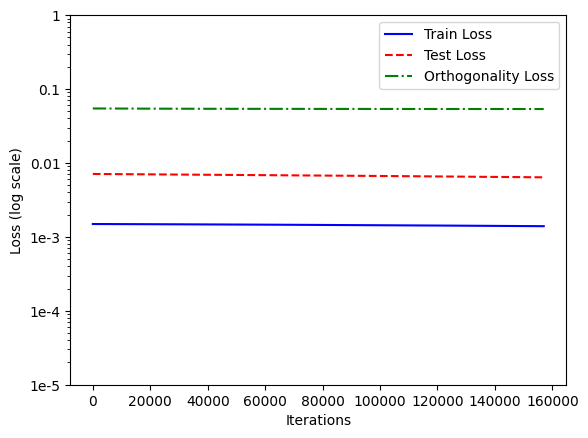

Iteration: 157500 Train_loss:0.0013949655694887042, Test_loss: 0.006391758564859629, ortho_loss:0.053672853857278824
Iteration: 158000 Train_loss:0.001394576160237193, Test_loss: 0.006389319896697998, ortho_loss:0.053679149597883224


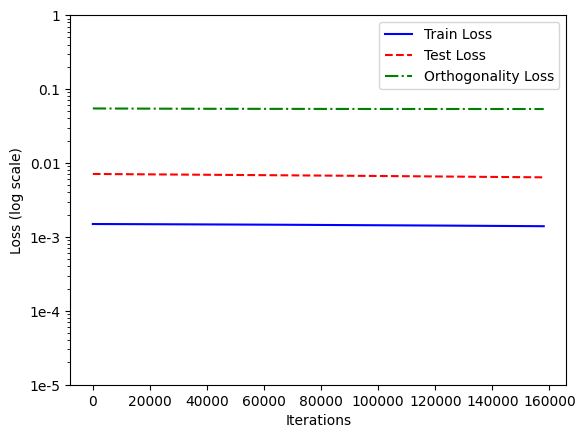

Iteration: 158500 Train_loss:0.0013941696379333735, Test_loss: 0.006386841647326946, ortho_loss:0.05367617309093475
Iteration: 159000 Train_loss:0.0013937706826254725, Test_loss: 0.006384366657584906, ortho_loss:0.05367447808384895


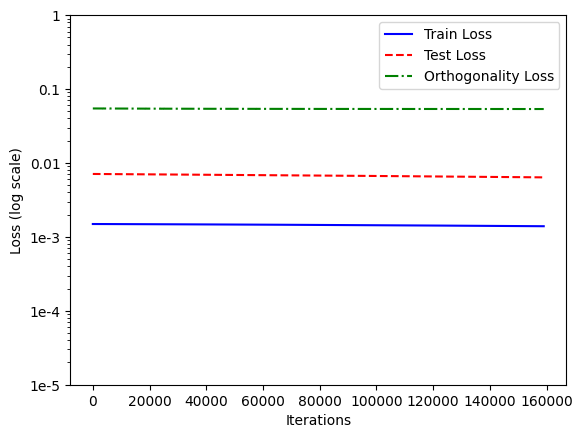

Iteration: 159500 Train_loss:0.0013933716109022498, Test_loss: 0.006381876301020384, ortho_loss:0.05368061736226082
Iteration: 160000 Train_loss:0.0013929681153967977, Test_loss: 0.006379400379955769, ortho_loss:0.053681932389736176


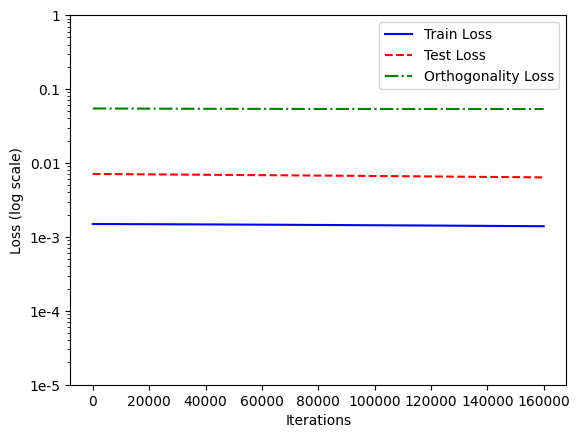

Iteration: 160500 Train_loss:0.0013925716048106551, Test_loss: 0.00637693190947175, ortho_loss:0.05368497222661972
Iteration: 161000 Train_loss:0.0013921725330874324, Test_loss: 0.0063744536601006985, ortho_loss:0.05368821695446968


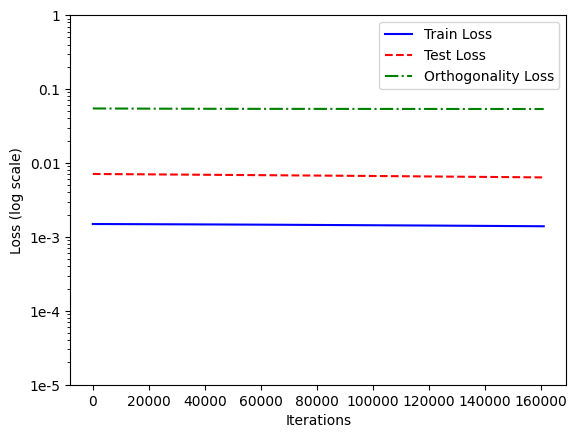

Iteration: 161500 Train_loss:0.001391768455505371, Test_loss: 0.006371974479407072, ortho_loss:0.0536835677921772
Iteration: 162000 Train_loss:0.001391371013596654, Test_loss: 0.006369503680616617, ortho_loss:0.053685542196035385


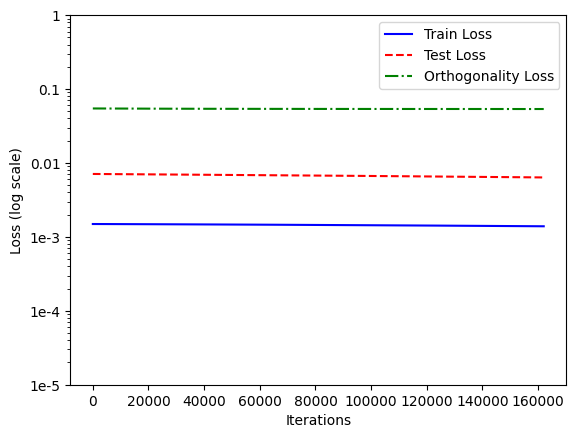

Iteration: 162500 Train_loss:0.0013909649569541216, Test_loss: 0.006367013324052095, ortho_loss:0.05368252843618393
Iteration: 163000 Train_loss:0.0013905649539083242, Test_loss: 0.00636452529579401, ortho_loss:0.05368908494710922


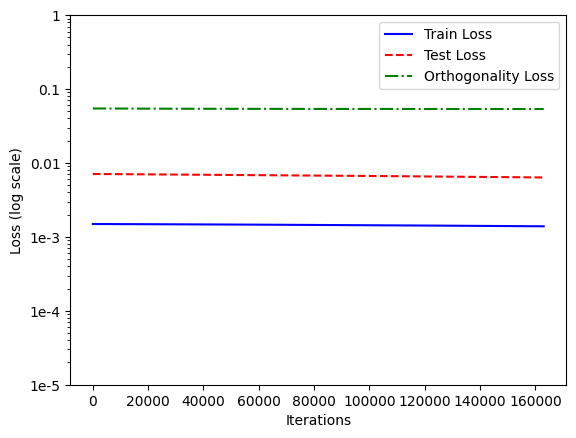

Iteration: 163500 Train_loss:0.0013901600614190102, Test_loss: 0.006362034007906914, ortho_loss:0.053685057908296585
Iteration: 164000 Train_loss:0.0013897630851715803, Test_loss: 0.006359551101922989, ortho_loss:0.053683359175920486


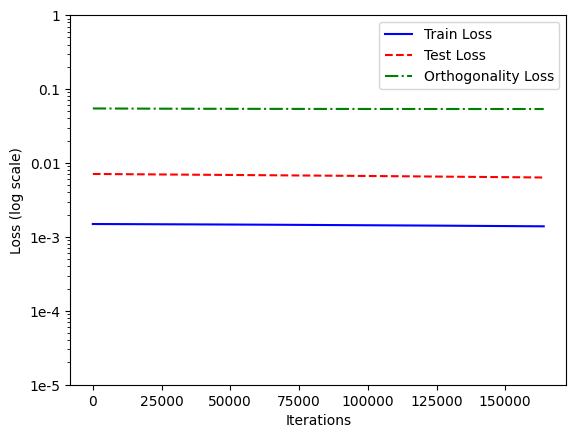

Iteration: 164500 Train_loss:0.001389355049468577, Test_loss: 0.006357054691761732, ortho_loss:0.05368578061461449
Iteration: 165000 Train_loss:0.0013889555120840669, Test_loss: 0.006354594603180885, ortho_loss:0.05368681624531746


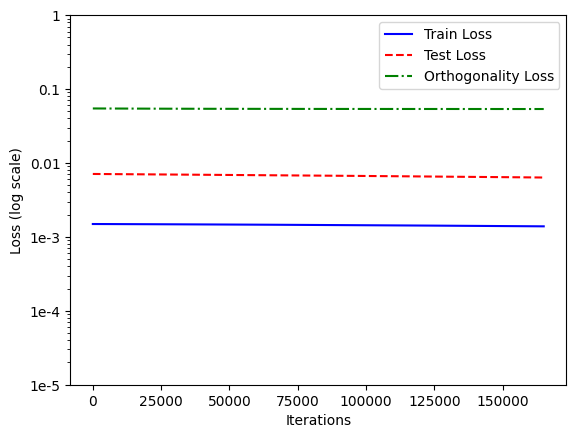

Iteration: 165500 Train_loss:0.0013885515509173274, Test_loss: 0.006352148950099945, ortho_loss:0.053681038320064545
Iteration: 166000 Train_loss:0.0013881433987990022, Test_loss: 0.006349692586809397, ortho_loss:0.05368336662650108


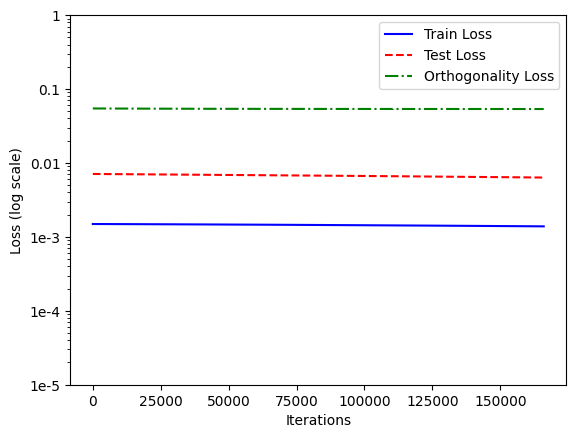

Iteration: 166500 Train_loss:0.0013877414166927338, Test_loss: 0.0063472227193415165, ortho_loss:0.053681544959545135
Iteration: 167000 Train_loss:0.0013873399002477527, Test_loss: 0.006344753783196211, ortho_loss:0.05368169769644737


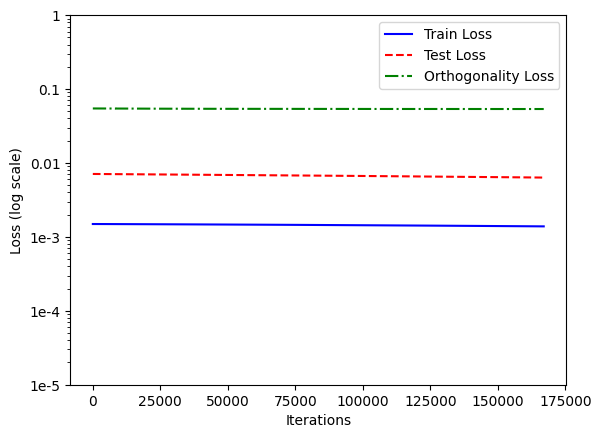

Iteration: 167500 Train_loss:0.0013869416434317827, Test_loss: 0.0063422322273254395, ortho_loss:0.053685400635004044
Iteration: 168000 Train_loss:0.0013865364016965032, Test_loss: 0.006339697632938623, ortho_loss:0.05368189141154289


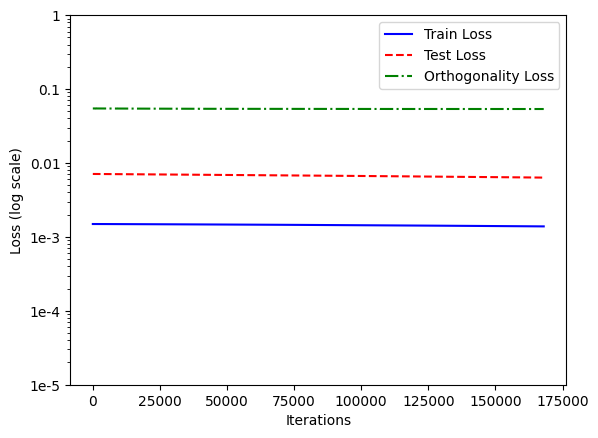

Iteration: 168500 Train_loss:0.001386132906191051, Test_loss: 0.006337145809084177, ortho_loss:0.053678713738918304
Iteration: 169000 Train_loss:0.001385727897286415, Test_loss: 0.006334605161100626, ortho_loss:0.05367602780461311


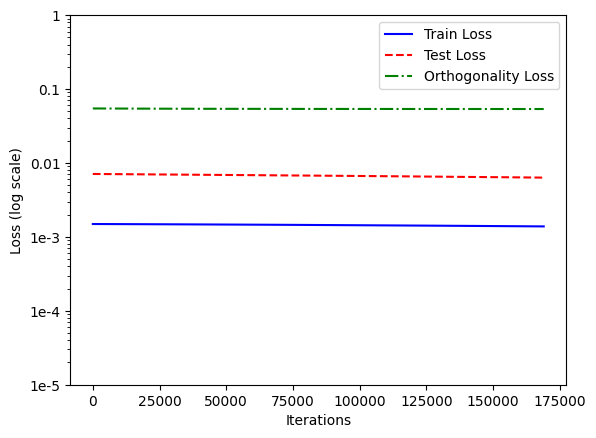

Iteration: 169500 Train_loss:0.0013853269629180431, Test_loss: 0.006332079414278269, ortho_loss:0.05368083715438843
Iteration: 170000 Train_loss:0.0013849212555214763, Test_loss: 0.006329555530101061, ortho_loss:0.05368480458855629


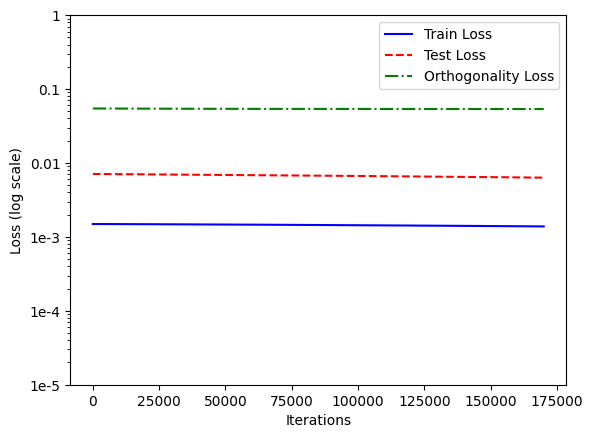

Iteration: 170500 Train_loss:0.0013845188077539206, Test_loss: 0.006327049341052771, ortho_loss:0.053682565689086914
Iteration: 171000 Train_loss:0.0013841156614944339, Test_loss: 0.006324564106762409, ortho_loss:0.05368496850132942


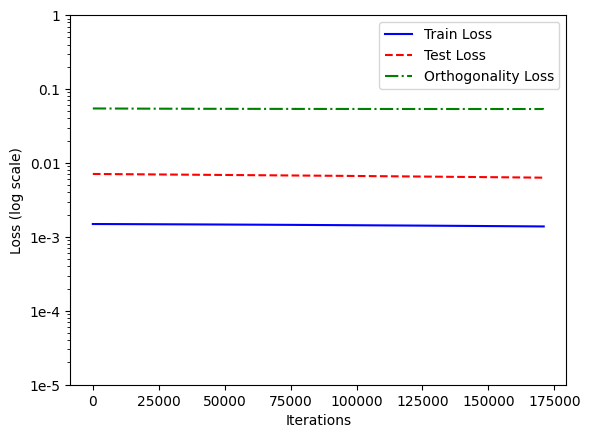

Iteration: 171500 Train_loss:0.001383707975037396, Test_loss: 0.0063220723532140255, ortho_loss:0.0536879226565361
Iteration: 172000 Train_loss:0.0013833052944391966, Test_loss: 0.00631960853934288, ortho_loss:0.053683891892433167


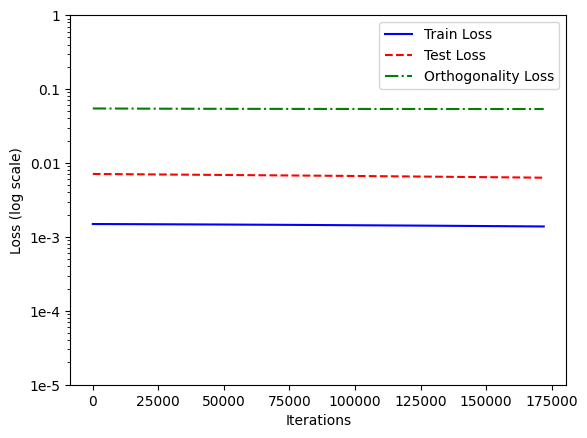

Iteration: 172500 Train_loss:0.0013829017989337444, Test_loss: 0.00631711957976222, ortho_loss:0.053688712418079376
Iteration: 173000 Train_loss:0.0013824974885210395, Test_loss: 0.006314664613455534, ortho_loss:0.05368846654891968


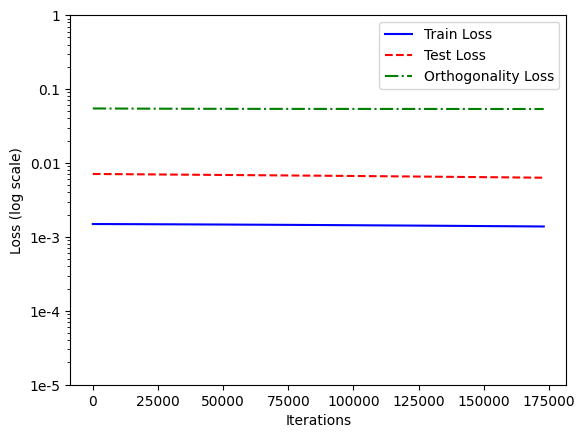

Iteration: 173500 Train_loss:0.0013820944586768746, Test_loss: 0.006312195677310228, ortho_loss:0.053690601140260696
Iteration: 174000 Train_loss:0.001381691894493997, Test_loss: 0.006309716496616602, ortho_loss:0.05369660630822182


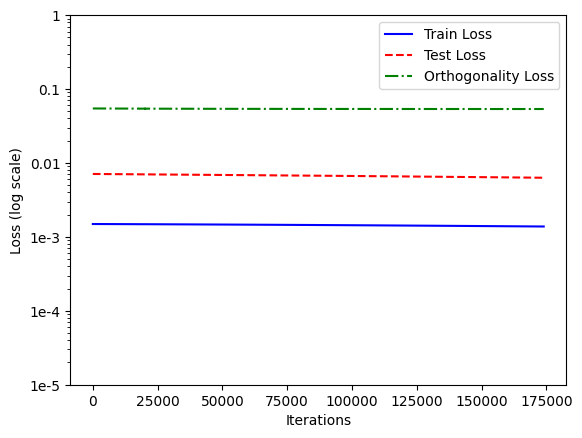

Iteration: 174500 Train_loss:0.001381289097480476, Test_loss: 0.006307229399681091, ortho_loss:0.05369534716010094
Iteration: 175000 Train_loss:0.0013808828080073, Test_loss: 0.006304722744971514, ortho_loss:0.05369694530963898


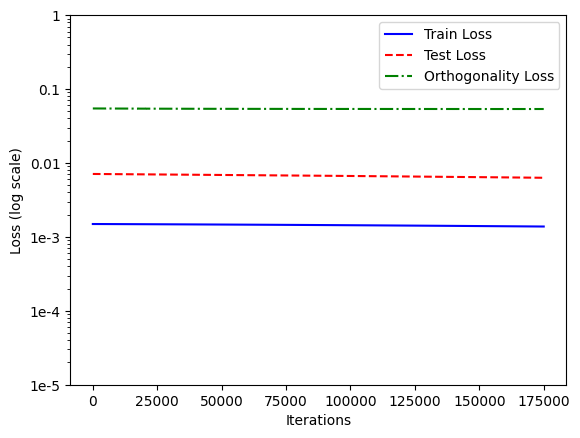

Iteration: 175500 Train_loss:0.0013804794289171696, Test_loss: 0.006302223075181246, ortho_loss:0.05369652807712555
Iteration: 176000 Train_loss:0.001380076166242361, Test_loss: 0.006299707572907209, ortho_loss:0.05370147526264191


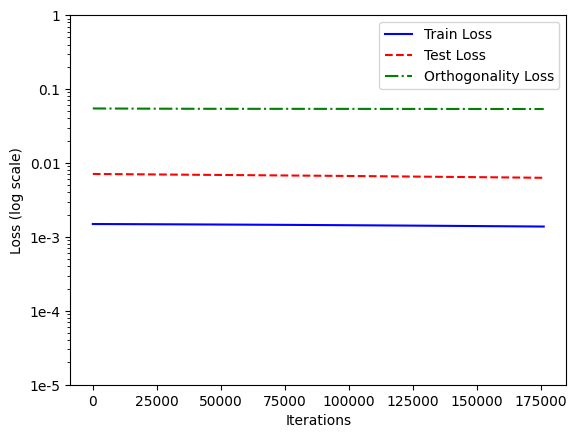

Iteration: 176500 Train_loss:0.0013796718558296561, Test_loss: 0.006297181360423565, ortho_loss:0.05370055139064789
Iteration: 177000 Train_loss:0.0013792675454169512, Test_loss: 0.006294651422649622, ortho_loss:0.053706660866737366


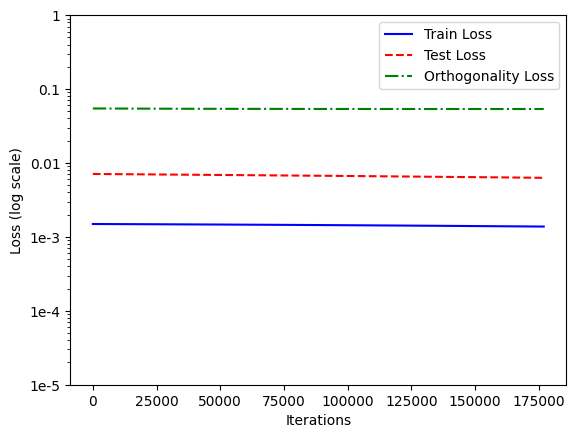

Iteration: 177500 Train_loss:0.0013788639334961772, Test_loss: 0.006292120553553104, ortho_loss:0.05370859056711197
Iteration: 178000 Train_loss:0.0013784585753455758, Test_loss: 0.0062895831651985645, ortho_loss:0.05371120199561119


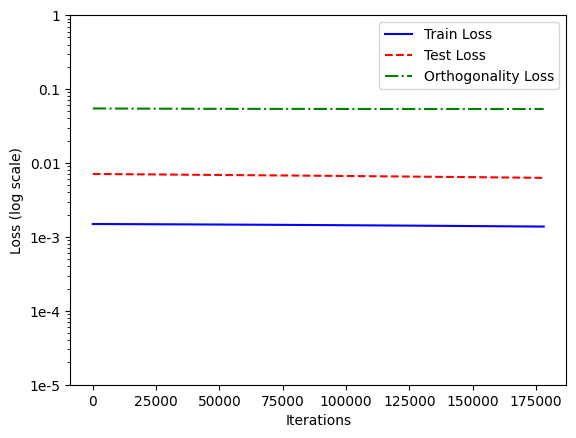

Iteration: 178500 Train_loss:0.00137805356644094, Test_loss: 0.006287053227424622, ortho_loss:0.053716741502285004
Iteration: 179000 Train_loss:0.0013776506530120969, Test_loss: 0.00628451956436038, ortho_loss:0.05371581017971039


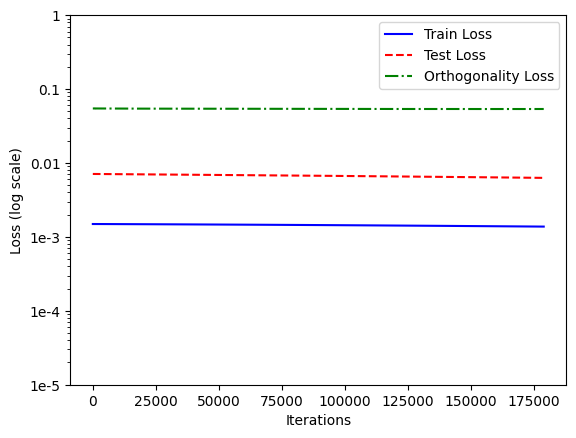

Iteration: 179500 Train_loss:0.0013772462261840701, Test_loss: 0.0062820096500217915, ortho_loss:0.05372089147567749
Iteration: 180000 Train_loss:0.0013768408680334687, Test_loss: 0.006279509048908949, ortho_loss:0.05373018607497215


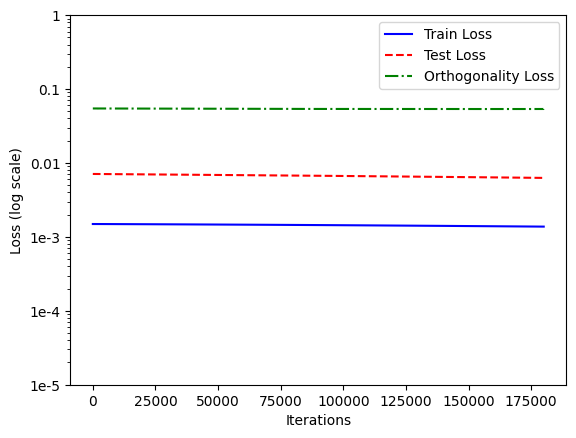

Iteration: 180500 Train_loss:0.0013764383038505912, Test_loss: 0.006277008913457394, ortho_loss:0.05373106524348259
Iteration: 181000 Train_loss:0.00137603422626853, Test_loss: 0.006274546030908823, ortho_loss:0.05373627692461014


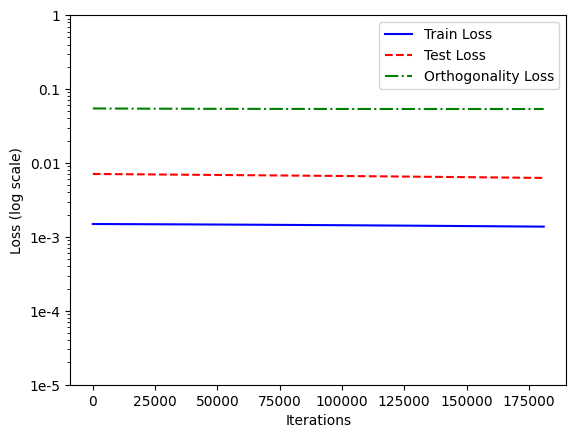

Iteration: 181500 Train_loss:0.001375634572468698, Test_loss: 0.006272086873650551, ortho_loss:0.053735170513391495
Iteration: 182000 Train_loss:0.0013752310769632459, Test_loss: 0.006269675679504871, ortho_loss:0.053739339113235474


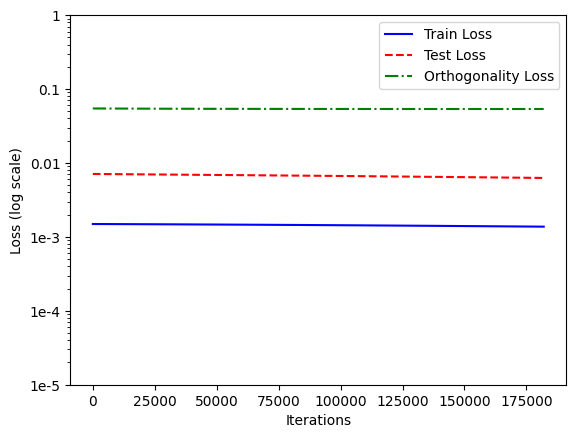

Iteration: 182500 Train_loss:0.0013748256023973227, Test_loss: 0.006267287768423557, ortho_loss:0.05374090373516083
Iteration: 183000 Train_loss:0.0013744172174483538, Test_loss: 0.006264895666390657, ortho_loss:0.05374284088611603


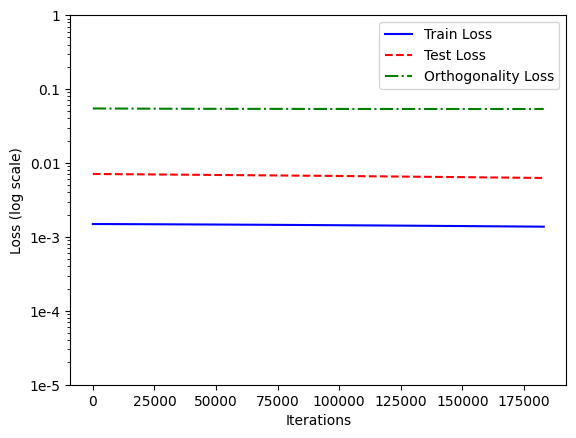

Iteration: 183500 Train_loss:0.0013740193098783493, Test_loss: 0.006262511946260929, ortho_loss:0.053744491189718246
Iteration: 184000 Train_loss:0.00137361790984869, Test_loss: 0.0062601384706795216, ortho_loss:0.05374202877283096


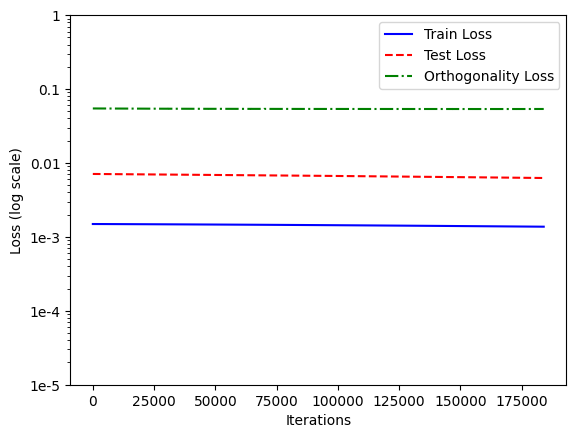

Iteration: 184500 Train_loss:0.0013732153456658125, Test_loss: 0.006257741246372461, ortho_loss:0.05374636873602867
Iteration: 185000 Train_loss:0.0013728105695918202, Test_loss: 0.006255373824387789, ortho_loss:0.053748611360788345


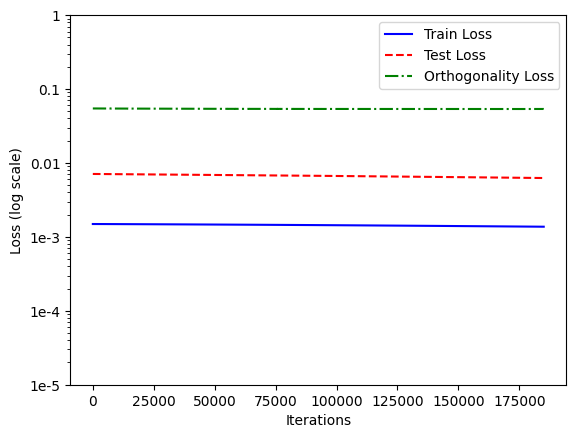

Iteration: 185500 Train_loss:0.0013724090531468391, Test_loss: 0.0062529779970645905, ortho_loss:0.053747083991765976
Iteration: 186000 Train_loss:0.0013720038114115596, Test_loss: 0.006250584963709116, ortho_loss:0.05375787243247032


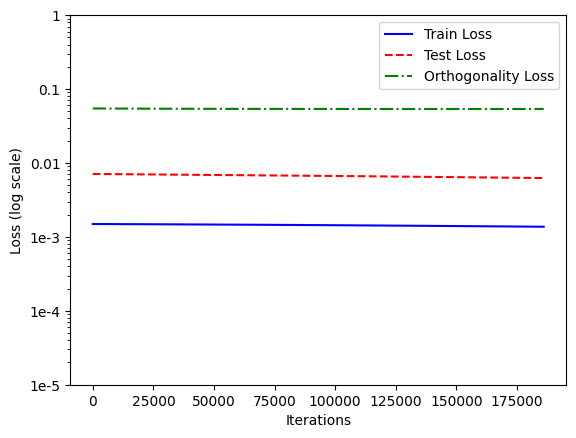

Iteration: 186500 Train_loss:0.0013716056710109115, Test_loss: 0.006248201243579388, ortho_loss:0.05375794321298599
Iteration: 187000 Train_loss:0.0013712049694731832, Test_loss: 0.006245822180062532, ortho_loss:0.05375327914953232


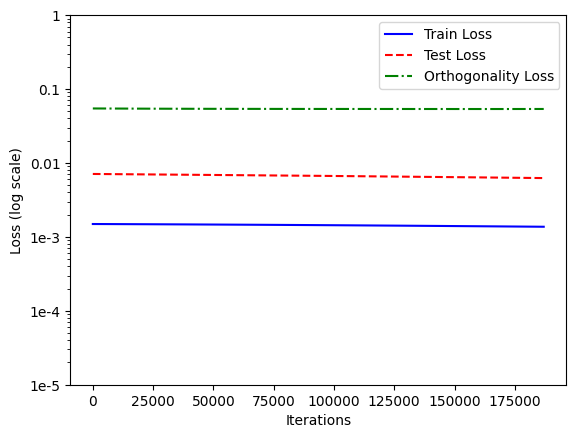

Iteration: 187500 Train_loss:0.001370798796415329, Test_loss: 0.006243408657610416, ortho_loss:0.05374997481703758
Iteration: 188000 Train_loss:0.0013703986769542098, Test_loss: 0.006241001188755035, ortho_loss:0.0537581667304039


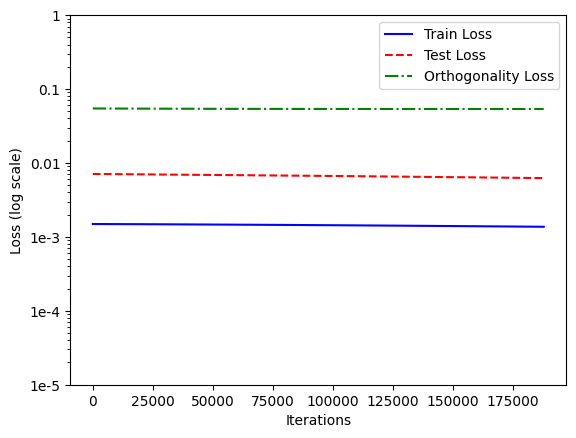

Iteration: 188500 Train_loss:0.0013700000708922744, Test_loss: 0.006238587666302919, ortho_loss:0.05376346781849861
Iteration: 189000 Train_loss:0.001369594712741673, Test_loss: 0.006236162502318621, ortho_loss:0.05376299470663071


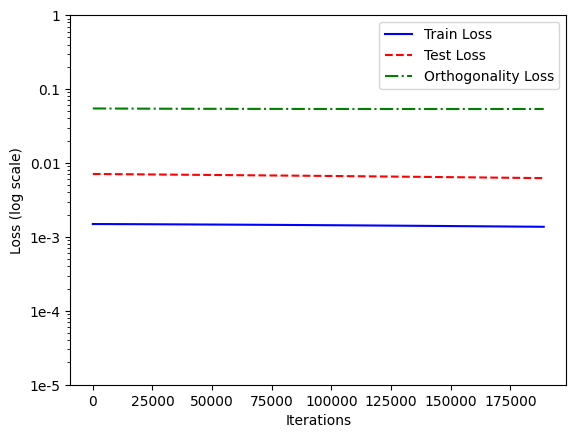

Iteration: 189500 Train_loss:0.0013691907515749335, Test_loss: 0.006233727093786001, ortho_loss:0.05377080664038658
Iteration: 190000 Train_loss:0.0013687931932508945, Test_loss: 0.006231287494301796, ortho_loss:0.05376671999692917


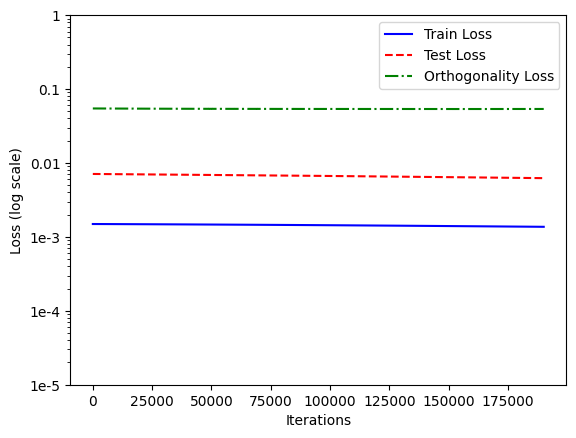

Iteration: 190500 Train_loss:0.00136839528568089, Test_loss: 0.006228822749108076, ortho_loss:0.053773216903209686
Iteration: 191000 Train_loss:0.001367991091683507, Test_loss: 0.006226349156349897, ortho_loss:0.053778793662786484


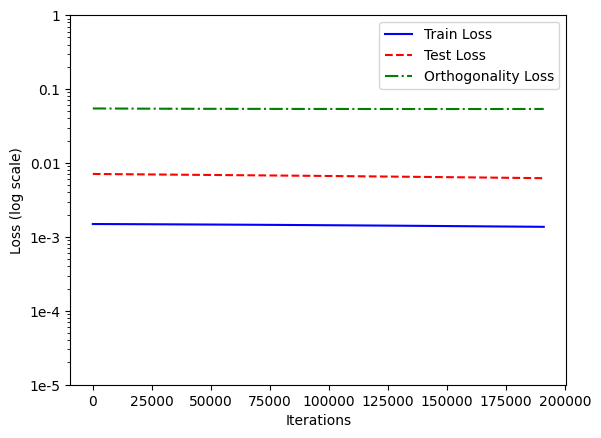

Iteration: 191500 Train_loss:0.0013675936497747898, Test_loss: 0.006223873235285282, ortho_loss:0.053776055574417114
Iteration: 192000 Train_loss:0.0013671908527612686, Test_loss: 0.006221388000994921, ortho_loss:0.05378277599811554


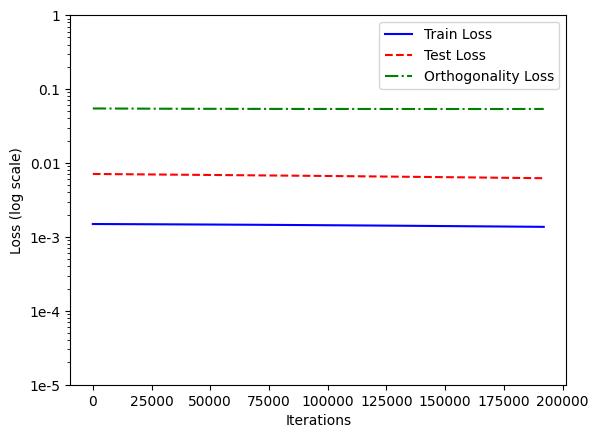

Iteration: 192500 Train_loss:0.001366792363114655, Test_loss: 0.00621889578178525, ortho_loss:0.053786732256412506
Iteration: 193000 Train_loss:0.0013663950376212597, Test_loss: 0.006216431502252817, ortho_loss:0.053790803998708725


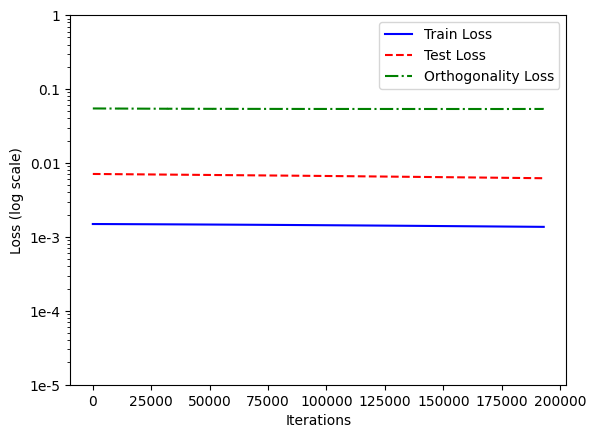

Iteration: 193500 Train_loss:0.0013659935211762786, Test_loss: 0.00621397327631712, ortho_loss:0.05379370227456093
Iteration: 194000 Train_loss:0.0013655931688845158, Test_loss: 0.006211531348526478, ortho_loss:0.05380072072148323


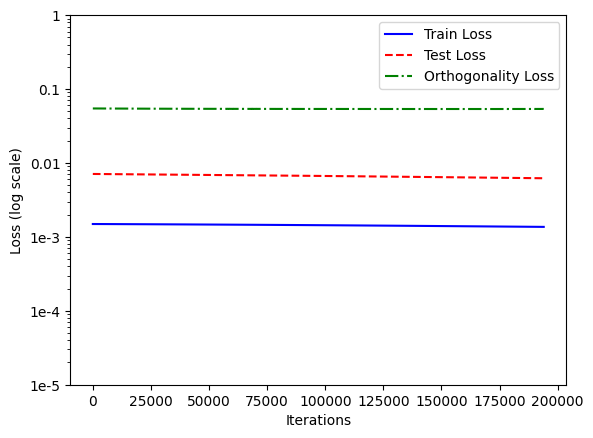

Iteration: 194500 Train_loss:0.0013651999179273844, Test_loss: 0.006209110375493765, ortho_loss:0.05380256101489067
Iteration: 195000 Train_loss:0.001364799216389656, Test_loss: 0.006206678692251444, ortho_loss:0.05381324142217636


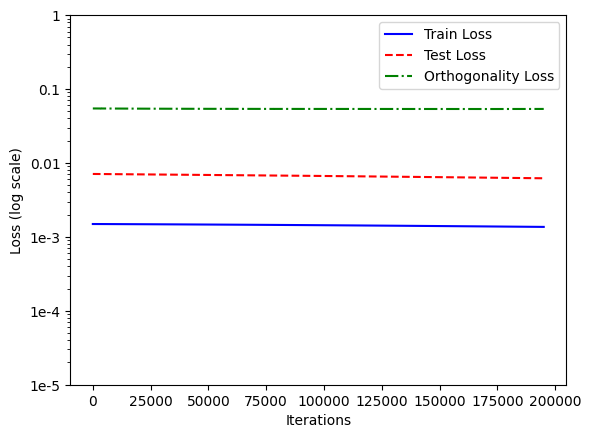

Iteration: 195500 Train_loss:0.0013643960701301694, Test_loss: 0.006204262841492891, ortho_loss:0.05382203310728073
Iteration: 196000 Train_loss:0.0013640036340802908, Test_loss: 0.0062018404714763165, ortho_loss:0.053823892027139664


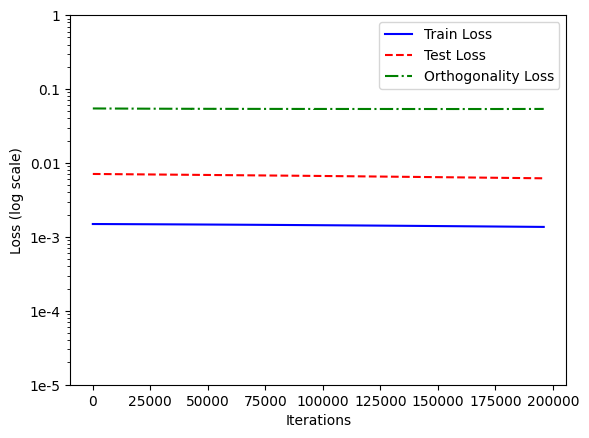

Iteration: 196500 Train_loss:0.0013636063085868955, Test_loss: 0.006199403200298548, ortho_loss:0.05383521690964699
Iteration: 197000 Train_loss:0.0013632107293233275, Test_loss: 0.006196964997798204, ortho_loss:0.053839195519685745


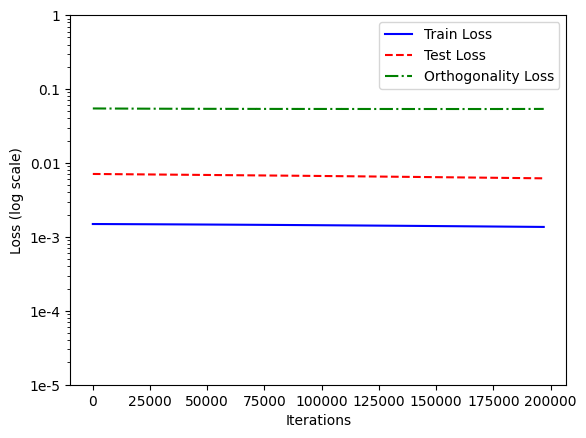

Iteration: 197500 Train_loss:0.001362813520245254, Test_loss: 0.006194539833813906, ortho_loss:0.053846780210733414
Iteration: 198000 Train_loss:0.001362412585876882, Test_loss: 0.006192095577716827, ortho_loss:0.05385621637105942


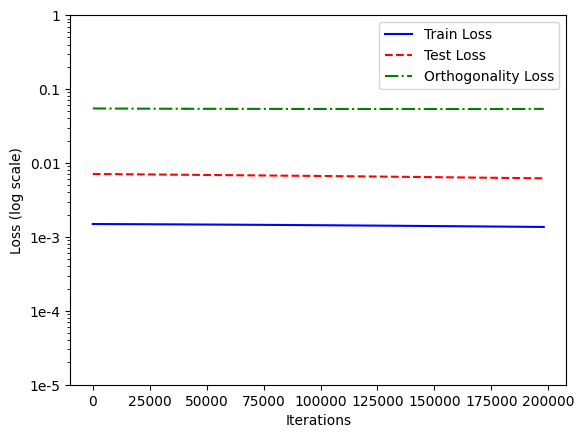

Iteration: 198500 Train_loss:0.0013620174722746015, Test_loss: 0.006189646199345589, ortho_loss:0.05386476218700409
Iteration: 199000 Train_loss:0.0013616239884868264, Test_loss: 0.006187224294990301, ortho_loss:0.05386737734079361


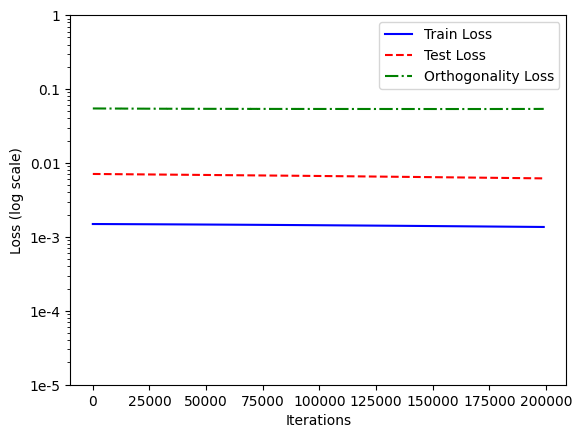

Iteration: 199500 Train_loss:0.0013612282928079367, Test_loss: 0.006184814963489771, ortho_loss:0.05386999621987343
Iteration: 200000 Train_loss:0.001360831898637116, Test_loss: 0.006182398181408644, ortho_loss:0.0538843609392643


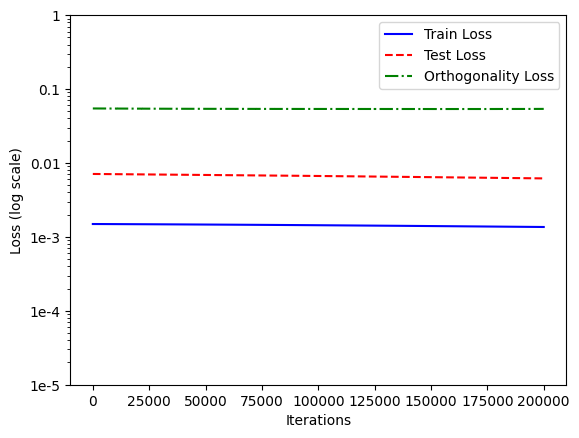

Iteration: 200500 Train_loss:0.0013604378327727318, Test_loss: 0.006179990246891975, ortho_loss:0.053887173533439636
Iteration: 201000 Train_loss:0.0013600494712591171, Test_loss: 0.006177594885230064, ortho_loss:0.05389381945133209


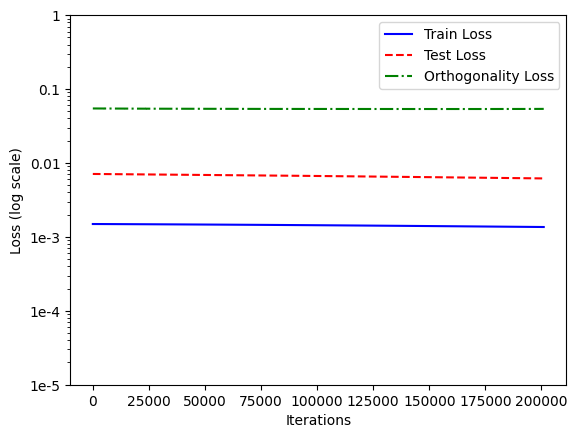

Iteration: 201500 Train_loss:0.0013596515636891127, Test_loss: 0.006175206508487463, ortho_loss:0.05389844998717308
Iteration: 202000 Train_loss:0.001359259127639234, Test_loss: 0.006172823719680309, ortho_loss:0.05390266701579094


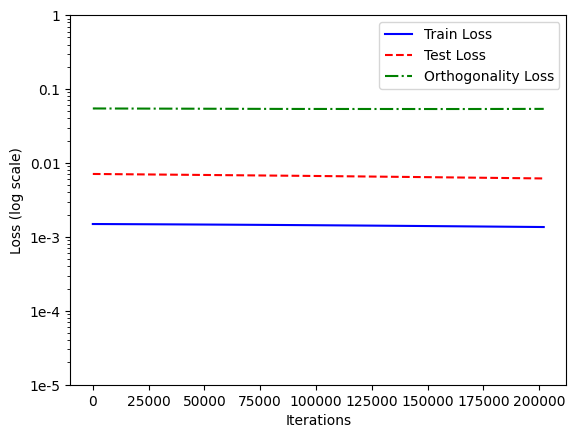

Iteration: 202500 Train_loss:0.0013588678557425737, Test_loss: 0.0061704497784376144, ortho_loss:0.053915418684482574
Iteration: 203000 Train_loss:0.001358472160063684, Test_loss: 0.006168077699840069, ortho_loss:0.053919363766908646


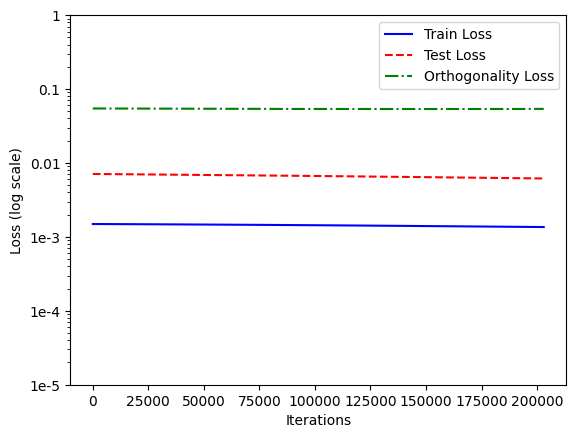

Iteration: 203500 Train_loss:0.0013580843806266785, Test_loss: 0.006165750324726105, ortho_loss:0.05393293499946594
Iteration: 204000 Train_loss:0.0013576934579759836, Test_loss: 0.006163412239402533, ortho_loss:0.05393717810511589


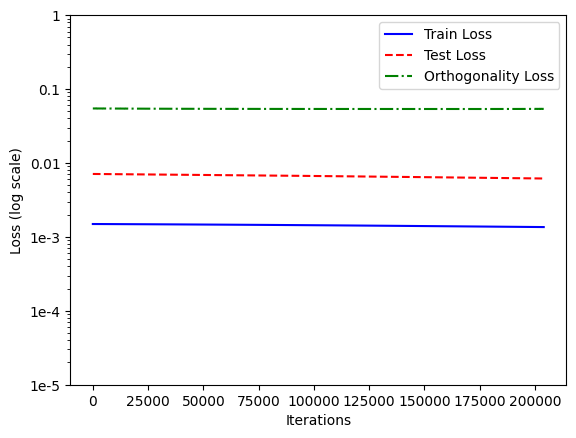

Iteration: 204500 Train_loss:0.0013573038158938289, Test_loss: 0.006161114200949669, ortho_loss:0.05394186079502106
Iteration: 205000 Train_loss:0.001356912893243134, Test_loss: 0.006158812437206507, ortho_loss:0.05394631624221802


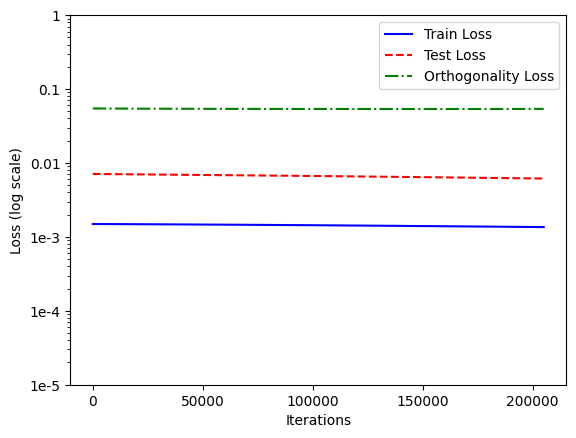

Iteration: 205500 Train_loss:0.0013565248809754848, Test_loss: 0.006156508810818195, ortho_loss:0.05395440384745598
Iteration: 206000 Train_loss:0.001356134656816721, Test_loss: 0.006154193077236414, ortho_loss:0.0539599284529686


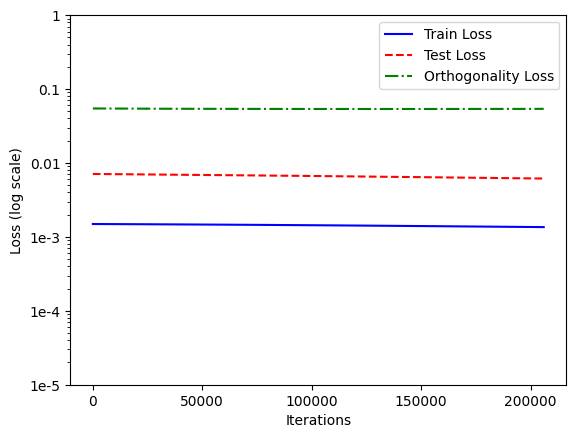

Iteration: 206500 Train_loss:0.0013557462953031063, Test_loss: 0.006151915993541479, ortho_loss:0.05396893620491028
Iteration: 207000 Train_loss:0.0013553608441725373, Test_loss: 0.006149664521217346, ortho_loss:0.05397797003388405


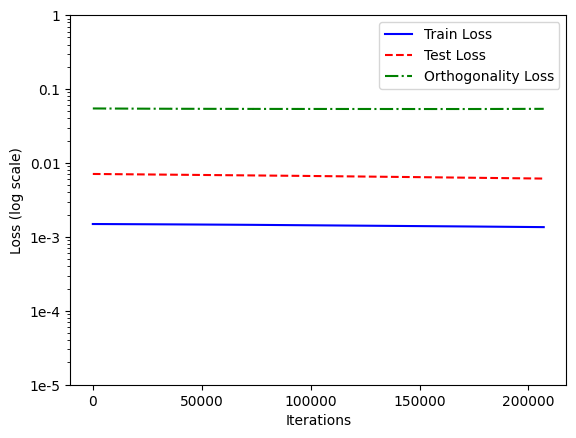

Iteration: 207500 Train_loss:0.0013549712020903826, Test_loss: 0.006147442851215601, ortho_loss:0.05397898331284523
Iteration: 208000 Train_loss:0.0013545871479436755, Test_loss: 0.006145235151052475, ortho_loss:0.05398162454366684


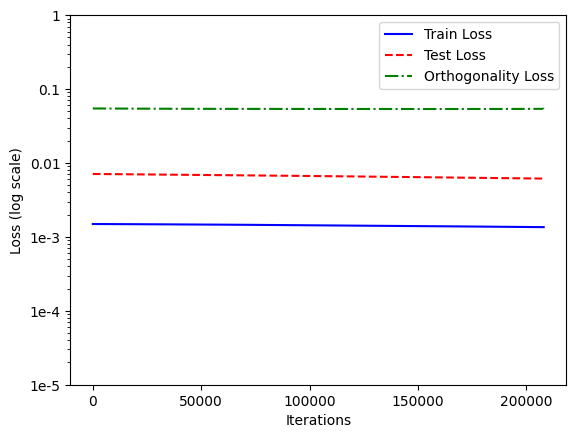

Iteration: 208500 Train_loss:0.0013542016968131065, Test_loss: 0.006143045611679554, ortho_loss:0.05398603528738022
Iteration: 209000 Train_loss:0.0013538101920858026, Test_loss: 0.00614086864516139, ortho_loss:0.05399250239133835


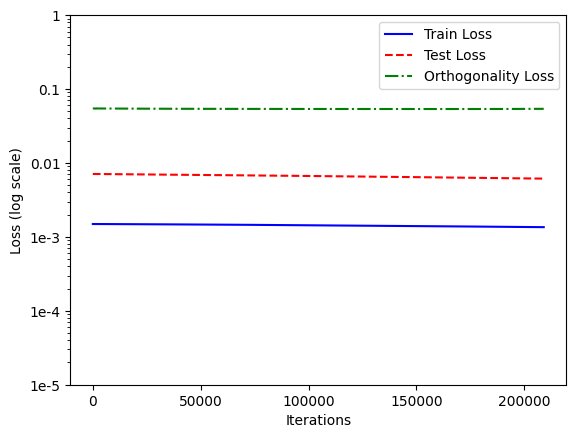

Iteration: 209500 Train_loss:0.0013534282334148884, Test_loss: 0.0061387005262076855, ortho_loss:0.05399272218346596
Iteration: 210000 Train_loss:0.001353049767203629, Test_loss: 0.006136542186141014, ortho_loss:0.05400530993938446


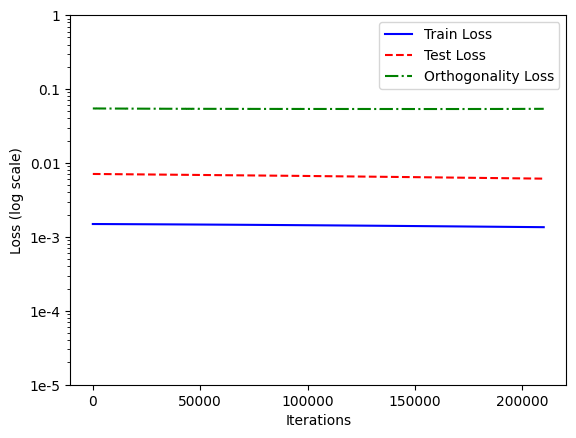

Iteration: 210500 Train_loss:0.0013526621041819453, Test_loss: 0.006134399212896824, ortho_loss:0.05401208624243736
Iteration: 211000 Train_loss:0.0013522789813578129, Test_loss: 0.006132232025265694, ortho_loss:0.05401671677827835


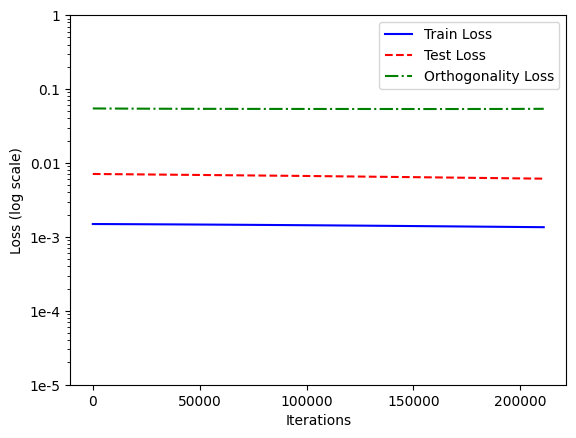

Iteration: 211500 Train_loss:0.0013519003987312317, Test_loss: 0.006130106281489134, ortho_loss:0.05402541905641556
Iteration: 212000 Train_loss:0.001351521466858685, Test_loss: 0.006128015927970409, ortho_loss:0.05402756109833717


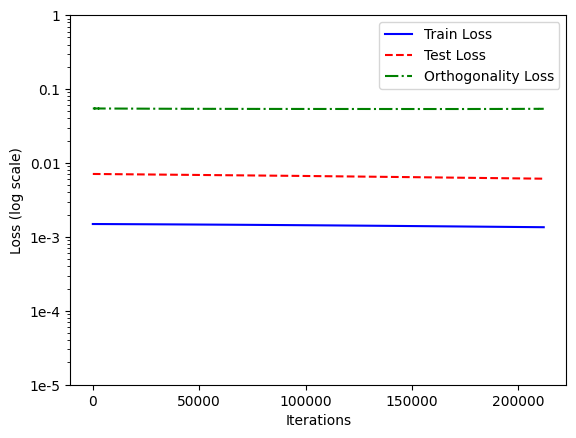

Iteration: 212500 Train_loss:0.001351139391772449, Test_loss: 0.006125931162387133, ortho_loss:0.05403020232915878
Iteration: 213000 Train_loss:0.001350761391222477, Test_loss: 0.006123867351561785, ortho_loss:0.054034553468227386


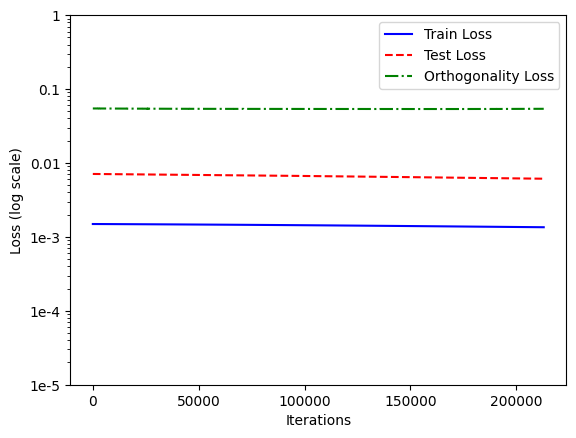

Iteration: 213500 Train_loss:0.0013503785012289882, Test_loss: 0.006121781654655933, ortho_loss:0.054039403796195984
Iteration: 214000 Train_loss:0.0013499996857717633, Test_loss: 0.0061196875758469105, ortho_loss:0.05405288189649582


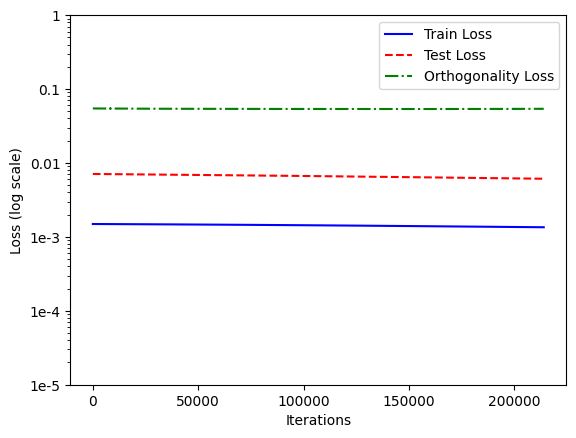

Iteration: 214500 Train_loss:0.001349621918052435, Test_loss: 0.00611760513857007, ortho_loss:0.05405803397297859
Iteration: 215000 Train_loss:0.0013492435682564974, Test_loss: 0.006115499883890152, ortho_loss:0.05406056344509125


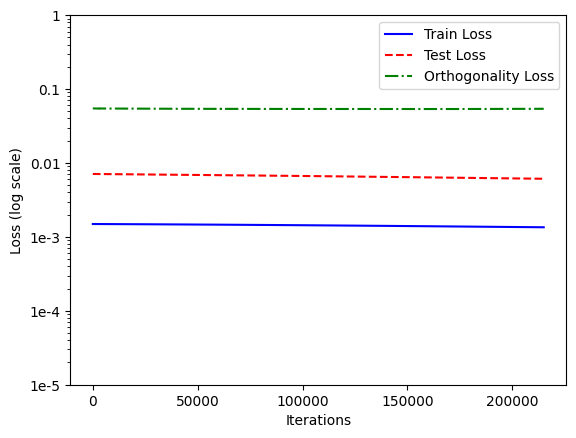

Iteration: 215500 Train_loss:0.0013488696422427893, Test_loss: 0.006113412790000439, ortho_loss:0.05406644195318222
Iteration: 216000 Train_loss:0.0013484912924468517, Test_loss: 0.006111310329288244, ortho_loss:0.05407939478754997


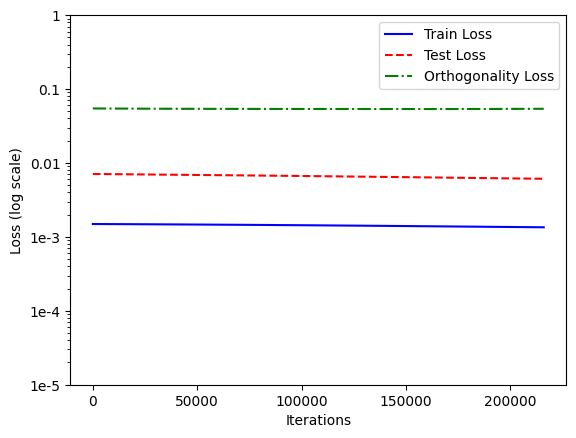

Iteration: 216500 Train_loss:0.001348117715679109, Test_loss: 0.006109219044446945, ortho_loss:0.054086677730083466
Iteration: 217000 Train_loss:0.0013477422762662172, Test_loss: 0.00610714266076684, ortho_loss:0.05408286303281784


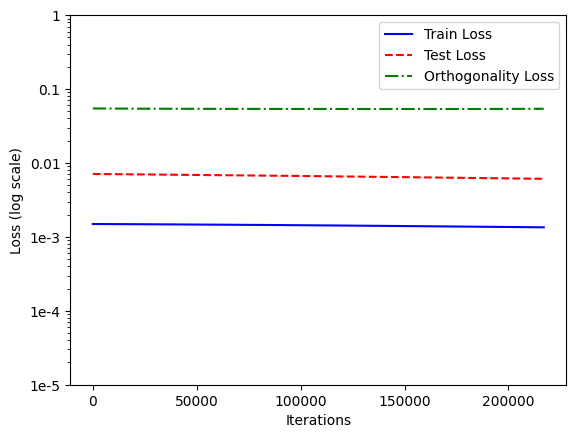

Iteration: 217500 Train_loss:0.0013473698636516929, Test_loss: 0.0061051128432154655, ortho_loss:0.05410337448120117
Iteration: 218000 Train_loss:0.0013469972182065248, Test_loss: 0.006103091407567263, ortho_loss:0.05411074310541153


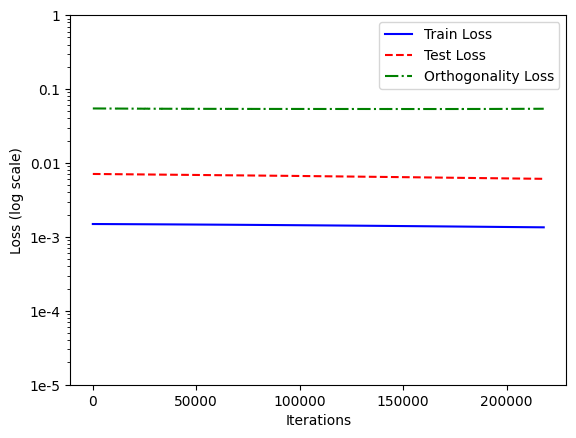

Iteration: 218500 Train_loss:0.001346622477285564, Test_loss: 0.006101090926676989, ortho_loss:0.054113004356622696
Iteration: 219000 Train_loss:0.001346255769021809, Test_loss: 0.006099113263189793, ortho_loss:0.05412166938185692


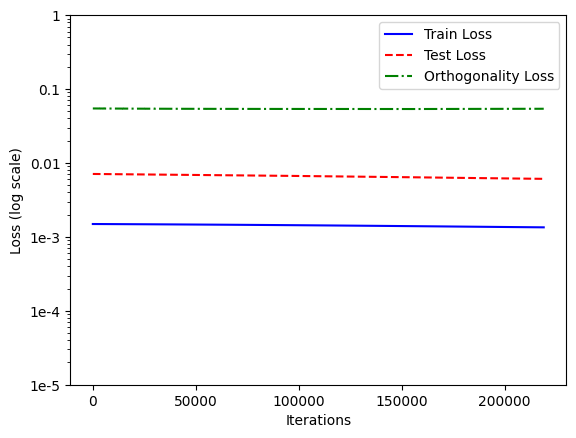

Iteration: 219500 Train_loss:0.0013458827743306756, Test_loss: 0.006097143050283194, ortho_loss:0.05413578078150749
Iteration: 220000 Train_loss:0.0013455142034217715, Test_loss: 0.006095185875892639, ortho_loss:0.054136186838150024


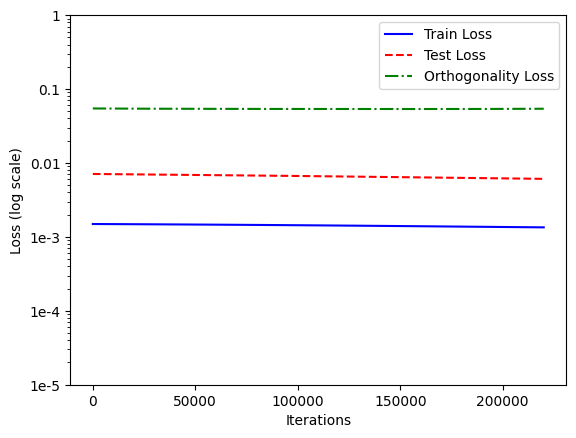

Iteration: 220500 Train_loss:0.0013451437698677182, Test_loss: 0.006093224510550499, ortho_loss:0.054142359644174576
Iteration: 221000 Train_loss:0.0013447781093418598, Test_loss: 0.0060912687331438065, ortho_loss:0.054143670946359634


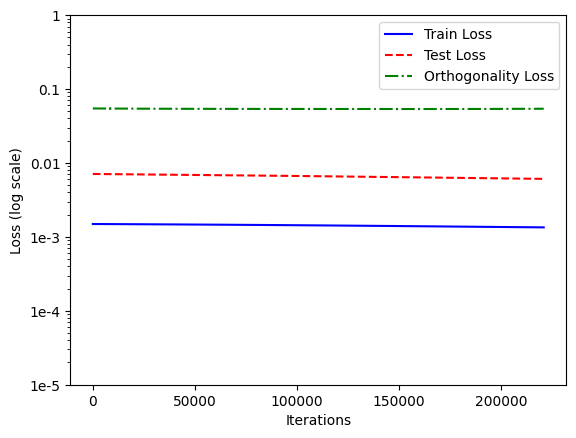

Iteration: 221500 Train_loss:0.00134440662804991, Test_loss: 0.006089332513511181, ortho_loss:0.05414847284555435
Iteration: 222000 Train_loss:0.001344044110737741, Test_loss: 0.006087394431233406, ortho_loss:0.054155271500349045


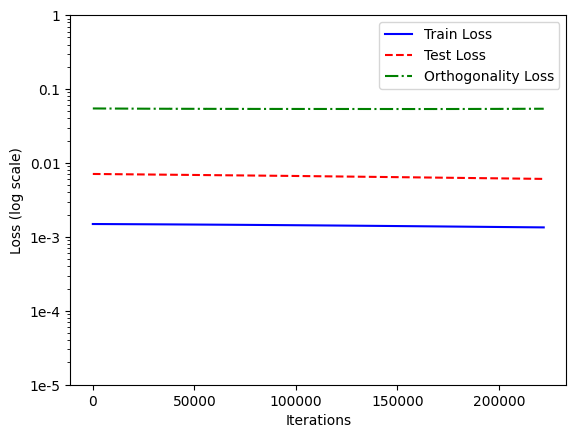

Iteration: 222500 Train_loss:0.0013436730951070786, Test_loss: 0.006085469853132963, ortho_loss:0.05416165292263031
Iteration: 223000 Train_loss:0.0013433118583634496, Test_loss: 0.0060835108160972595, ortho_loss:0.054165568202733994


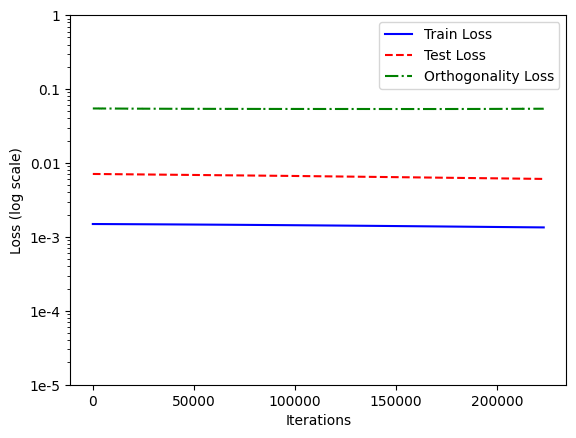

Iteration: 223500 Train_loss:0.001342950388789177, Test_loss: 0.0060815224424004555, ortho_loss:0.05416743457317352
Iteration: 224000 Train_loss:0.0013425853103399277, Test_loss: 0.00607956200838089, ortho_loss:0.05416915938258171


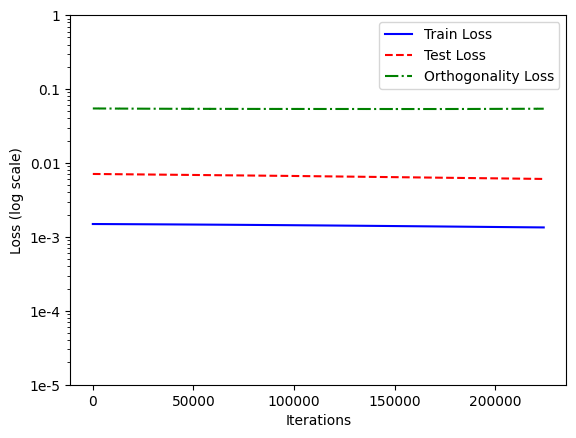

Iteration: 224500 Train_loss:0.0013422243064269423, Test_loss: 0.006077609024941921, ortho_loss:0.054182056337594986
Iteration: 225000 Train_loss:0.0013418635353446007, Test_loss: 0.006075672805309296, ortho_loss:0.05418521910905838


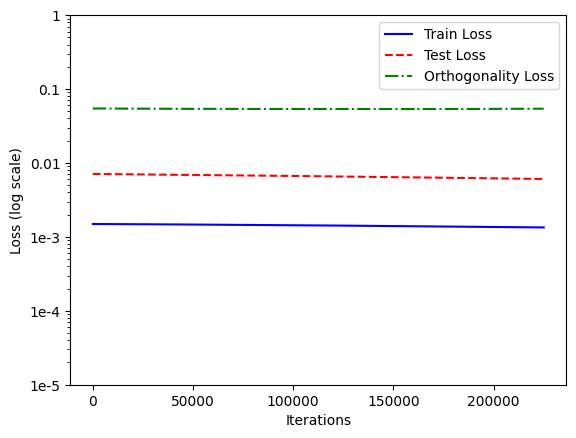

Iteration: 225500 Train_loss:0.0013415062567219138, Test_loss: 0.006073750089854002, ortho_loss:0.05418824031949043
Iteration: 226000 Train_loss:0.001341144205071032, Test_loss: 0.006071832031011581, ortho_loss:0.0541987307369709


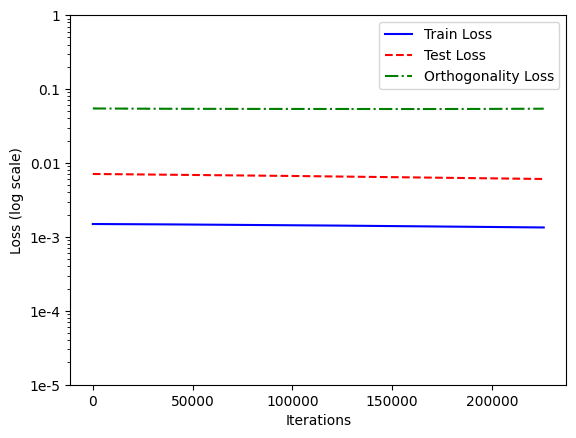

Iteration: 226500 Train_loss:0.0013407854130491614, Test_loss: 0.006069920025765896, ortho_loss:0.05420176684856415
Iteration: 227000 Train_loss:0.0013404327910393476, Test_loss: 0.006068000569939613, ortho_loss:0.05420586094260216


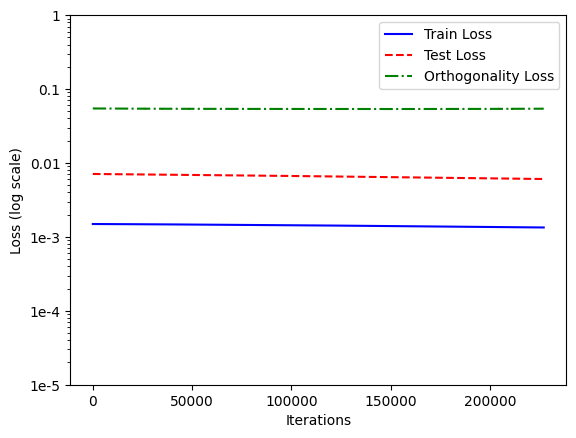

Iteration: 227500 Train_loss:0.00134007737506181, Test_loss: 0.006066079251468182, ortho_loss:0.05421479418873787
Iteration: 228000 Train_loss:0.0013397227739915252, Test_loss: 0.0060641588643193245, ortho_loss:0.05422297492623329


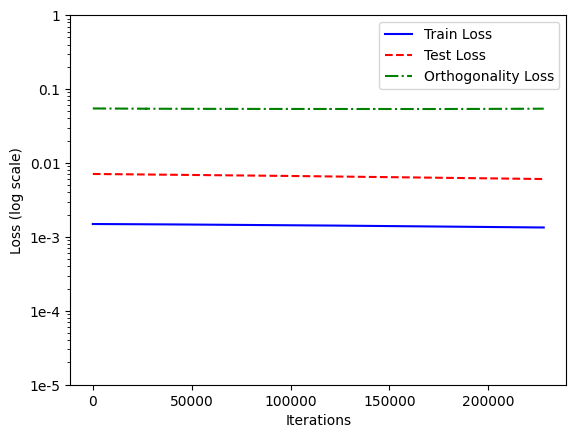

Iteration: 228500 Train_loss:0.0013393713161349297, Test_loss: 0.006062254775315523, ortho_loss:0.05423182249069214
Iteration: 229000 Train_loss:0.0013390133390203118, Test_loss: 0.006060359068214893, ortho_loss:0.05423623323440552


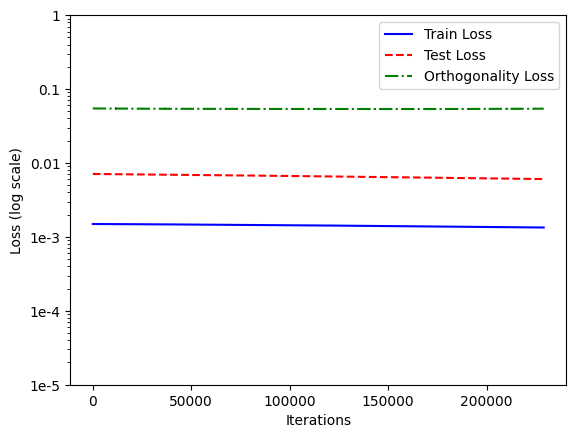

Iteration: 229500 Train_loss:0.0013386606005951762, Test_loss: 0.006058489438146353, ortho_loss:0.054236967116594315
Iteration: 230000 Train_loss:0.0013383070472627878, Test_loss: 0.006056618876755238, ortho_loss:0.05424485728144646


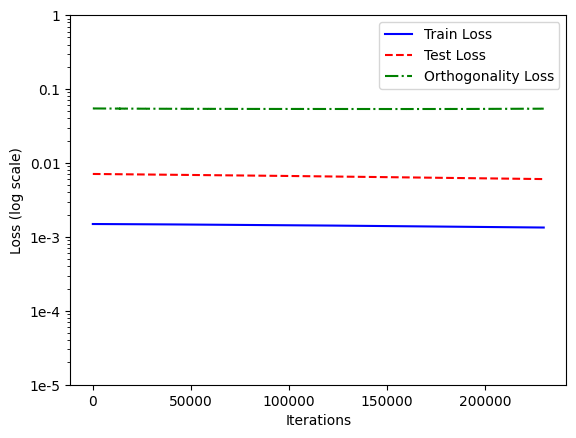

Iteration: 230500 Train_loss:0.0013379600131884217, Test_loss: 0.006054760422557592, ortho_loss:0.05424434319138527
Iteration: 231000 Train_loss:0.0013376108836382627, Test_loss: 0.006052936892956495, ortho_loss:0.054254546761512756


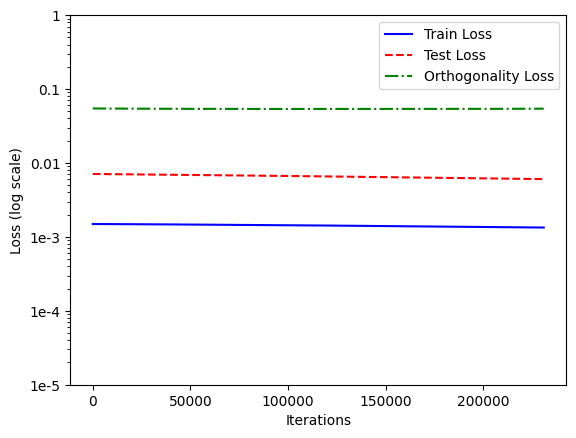

Iteration: 231500 Train_loss:0.0013372567482292652, Test_loss: 0.006051110103726387, ortho_loss:0.054260049015283585
Iteration: 232000 Train_loss:0.0013369146035984159, Test_loss: 0.006049301475286484, ortho_loss:0.05427023395895958


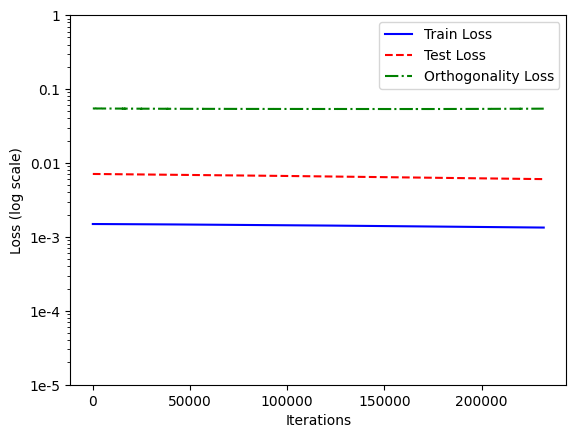

Iteration: 232500 Train_loss:0.0013365697814151645, Test_loss: 0.006047503557056189, ortho_loss:0.054272525012493134
Iteration: 233000 Train_loss:0.0013362226309254766, Test_loss: 0.006045715417712927, ortho_loss:0.05428410321474075


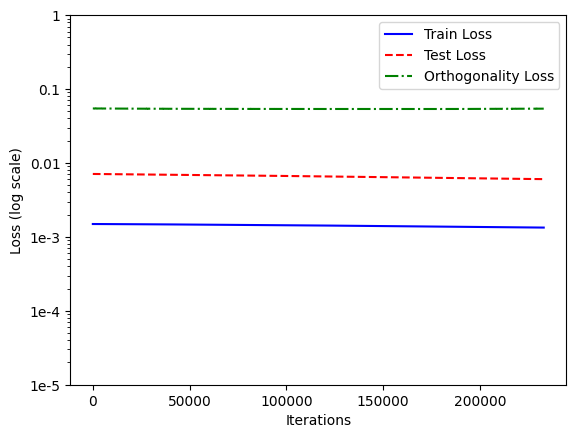

Iteration: 233500 Train_loss:0.0013358789728954434, Test_loss: 0.0060439445078372955, ortho_loss:0.054290708154439926
Iteration: 234000 Train_loss:0.0013355312403291464, Test_loss: 0.006042209453880787, ortho_loss:0.054297059774398804


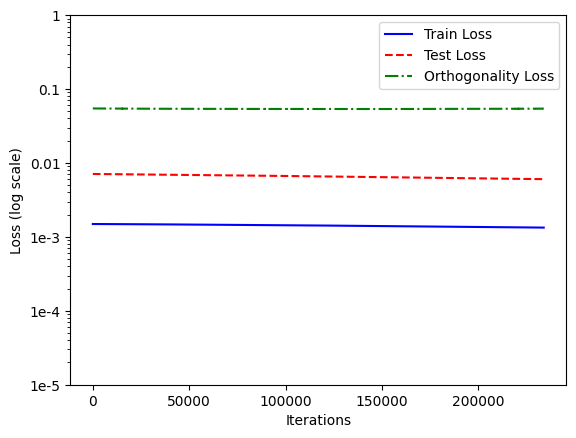

Iteration: 234500 Train_loss:0.001335191773250699, Test_loss: 0.006040459033101797, ortho_loss:0.0543038435280323
Iteration: 235000 Train_loss:0.001334860105998814, Test_loss: 0.006038735620677471, ortho_loss:0.0543193519115448


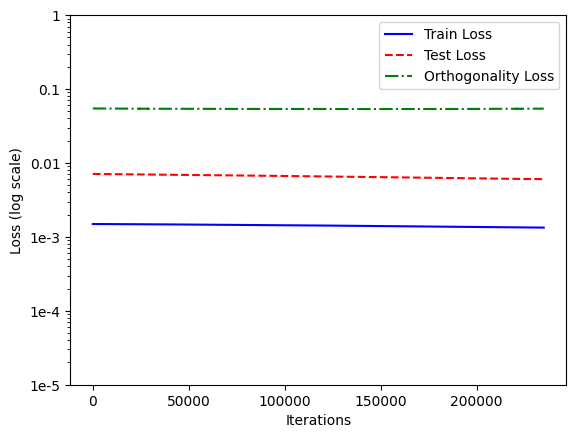

Iteration: 235500 Train_loss:0.0013345169136300683, Test_loss: 0.006037004292011261, ortho_loss:0.054326027631759644
Iteration: 236000 Train_loss:0.0013341772137209773, Test_loss: 0.006035263184458017, ortho_loss:0.05432702600955963


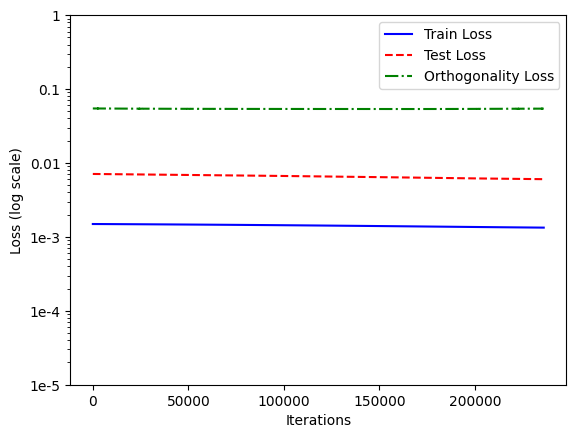

Iteration: 236500 Train_loss:0.0013338408898562193, Test_loss: 0.006033534649759531, ortho_loss:0.05433902516961098
Iteration: 237000 Train_loss:0.0013335064286366105, Test_loss: 0.006031821947544813, ortho_loss:0.054345741868019104


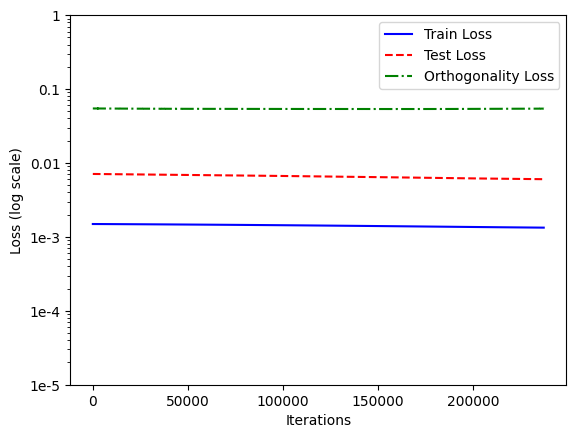

Iteration: 237500 Train_loss:0.0013331674272194505, Test_loss: 0.006030096672475338, ortho_loss:0.05436160787940025
Iteration: 238000 Train_loss:0.0013328362256288528, Test_loss: 0.006028384901583195, ortho_loss:0.0543670579791069


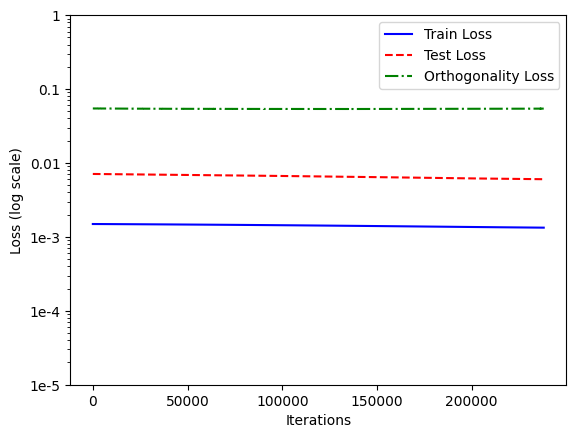

Iteration: 238500 Train_loss:0.00133250723592937, Test_loss: 0.006026668008416891, ortho_loss:0.054374903440475464
Iteration: 239000 Train_loss:0.001332170213572681, Test_loss: 0.0060249632224440575, ortho_loss:0.054381903260946274


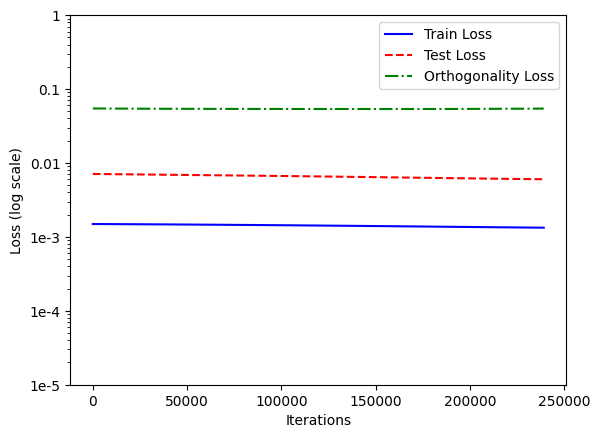

Iteration: 239500 Train_loss:0.0013318327255547047, Test_loss: 0.006023322697728872, ortho_loss:0.05439178645610809
Iteration: 240000 Train_loss:0.0013315044343471527, Test_loss: 0.0060216947458684444, ortho_loss:0.05439898744225502


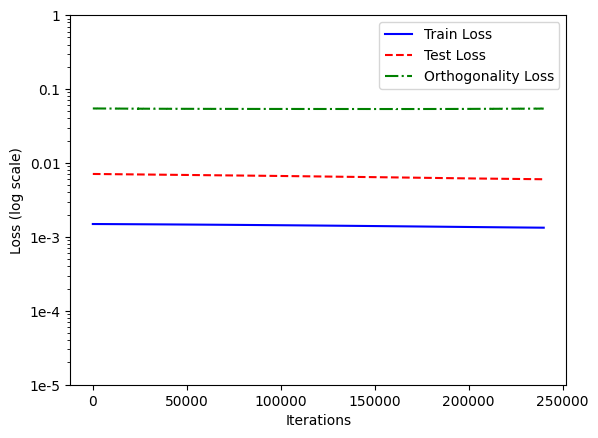

Iteration: 240500 Train_loss:0.001331175910308957, Test_loss: 0.006020043045282364, ortho_loss:0.0544082447886467
Iteration: 241000 Train_loss:0.0013308505294844508, Test_loss: 0.006018366664648056, ortho_loss:0.05441225692629814


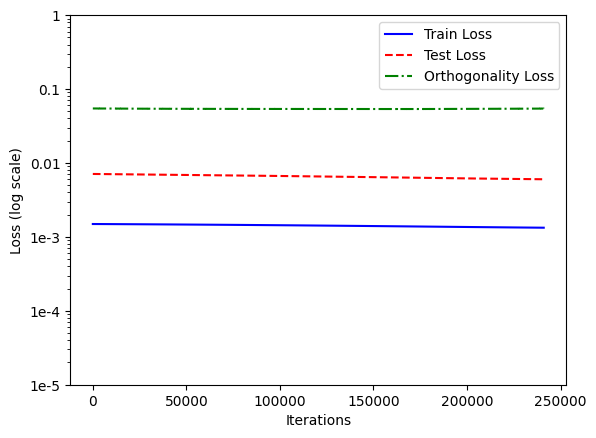

Iteration: 241500 Train_loss:0.0013305252650752664, Test_loss: 0.006016689818352461, ortho_loss:0.05441698431968689
Iteration: 242000 Train_loss:0.001330200000666082, Test_loss: 0.006015038583427668, ortho_loss:0.05441845953464508


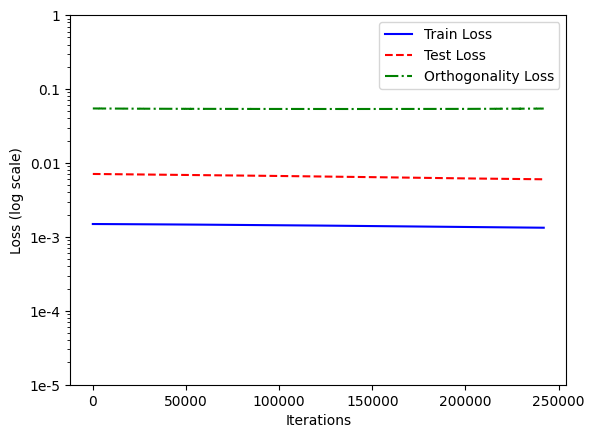

Iteration: 242500 Train_loss:0.001329871010966599, Test_loss: 0.0060133603401482105, ortho_loss:0.05442763864994049
Iteration: 243000 Train_loss:0.0013295493554323912, Test_loss: 0.006011711433529854, ortho_loss:0.05443571135401726


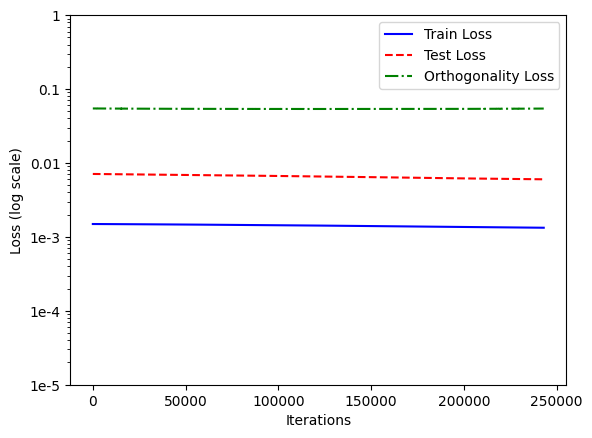

Iteration: 243500 Train_loss:0.0013292246730998158, Test_loss: 0.0060100676491856575, ortho_loss:0.05444017052650452
Iteration: 244000 Train_loss:0.0013289024354889989, Test_loss: 0.00600844481959939, ortho_loss:0.05444428324699402


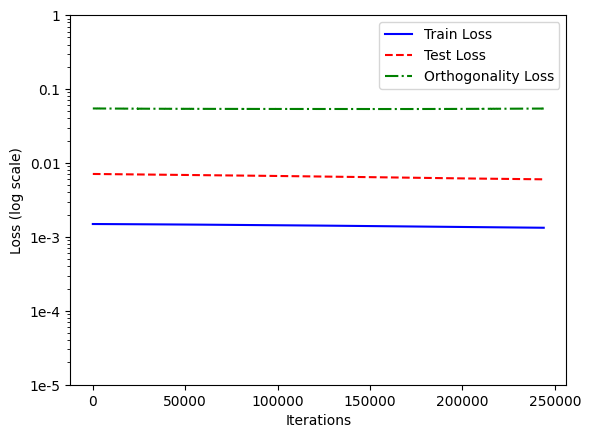

Iteration: 244500 Train_loss:0.0013285836903378367, Test_loss: 0.006006829906255007, ortho_loss:0.05444847792387009
Iteration: 245000 Train_loss:0.0013282611034810543, Test_loss: 0.006005248986184597, ortho_loss:0.05446269363164902


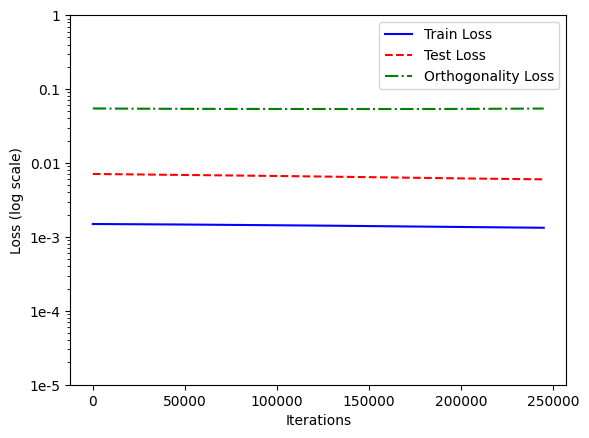

Iteration: 245500 Train_loss:0.001327945850789547, Test_loss: 0.006003668066114187, ortho_loss:0.054466988891363144
Iteration: 246000 Train_loss:0.001327624311670661, Test_loss: 0.0060020936653018, ortho_loss:0.05447515845298767


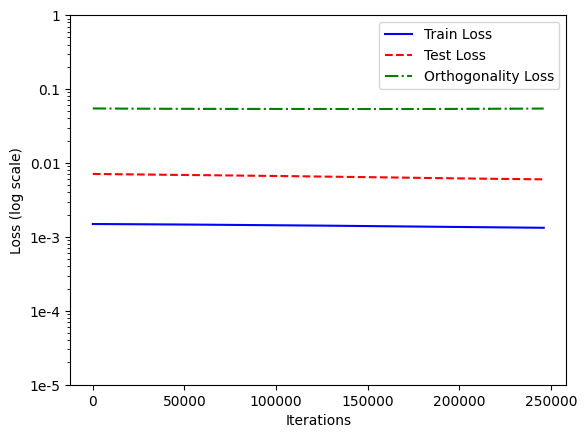

Iteration: 246500 Train_loss:0.0013273078948259354, Test_loss: 0.006000555586069822, ortho_loss:0.054474472999572754
Iteration: 247000 Train_loss:0.0013269956689327955, Test_loss: 0.0059990184381604195, ortho_loss:0.05448123812675476


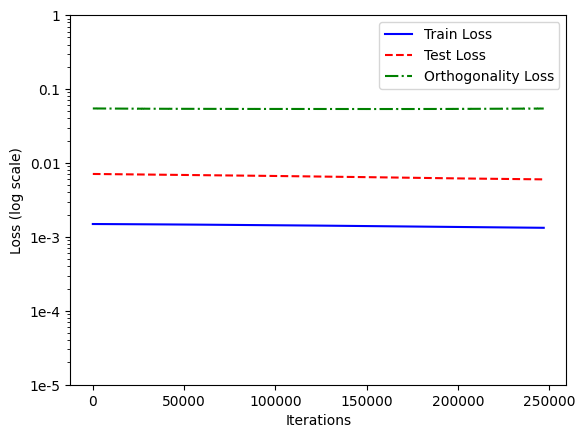

Iteration: 247500 Train_loss:0.0013266784371808171, Test_loss: 0.0059975204057991505, ortho_loss:0.054488424211740494
Iteration: 248000 Train_loss:0.0013263708679005504, Test_loss: 0.005996028892695904, ortho_loss:0.05449498072266579


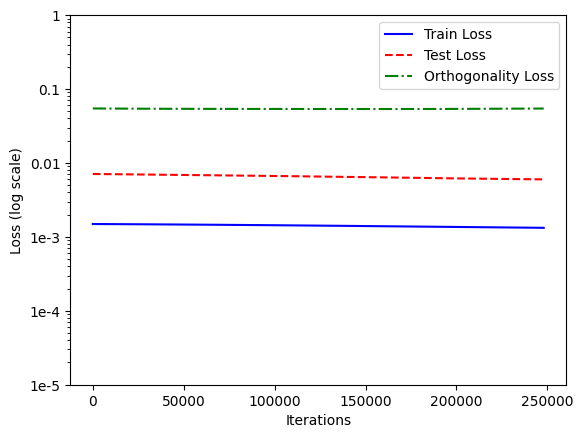

Iteration: 248500 Train_loss:0.0013260530540719628, Test_loss: 0.005994577892124653, ortho_loss:0.054499395191669464
Iteration: 249000 Train_loss:0.001325745601207018, Test_loss: 0.005993189290165901, ortho_loss:0.05449913442134857


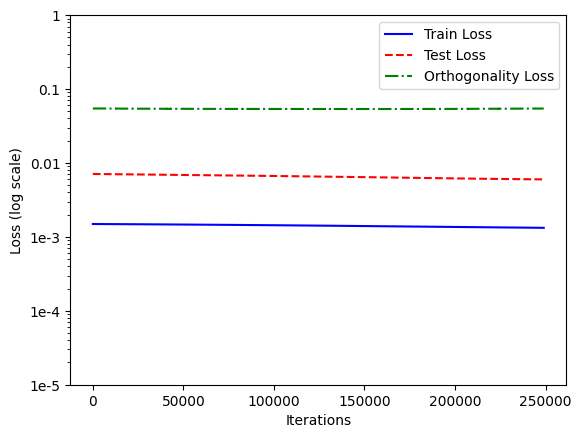

Iteration: 249500 Train_loss:0.0013254308141767979, Test_loss: 0.005991814192384481, ortho_loss:0.05450800433754921
Iteration: 250000 Train_loss:0.0013251305790618062, Test_loss: 0.0059904069639742374, ortho_loss:0.05451896786689758


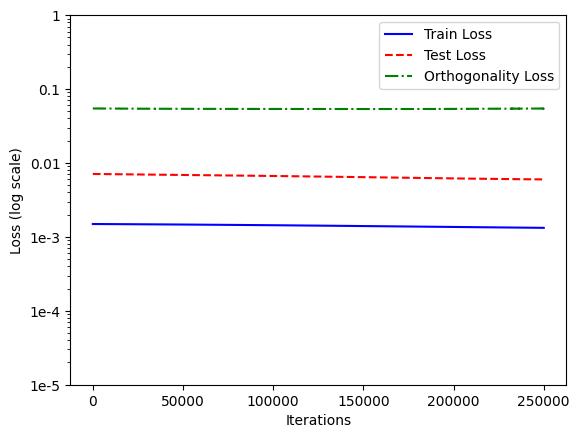

Iteration: 250500 Train_loss:0.001324820565059781, Test_loss: 0.005989025346934795, ortho_loss:0.05452391505241394
Iteration: 251000 Train_loss:0.001324511249549687, Test_loss: 0.005987688433378935, ortho_loss:0.054532136768102646


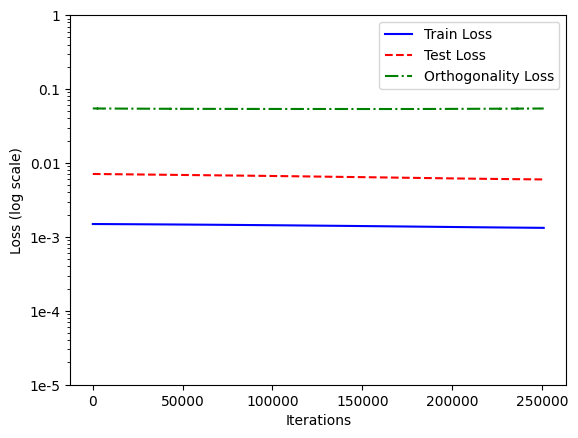

Iteration: 251500 Train_loss:0.0013242081040516496, Test_loss: 0.005986366420984268, ortho_loss:0.054541487246751785
Iteration: 252000 Train_loss:0.0013239089166745543, Test_loss: 0.0059851109981536865, ortho_loss:0.05454465374350548


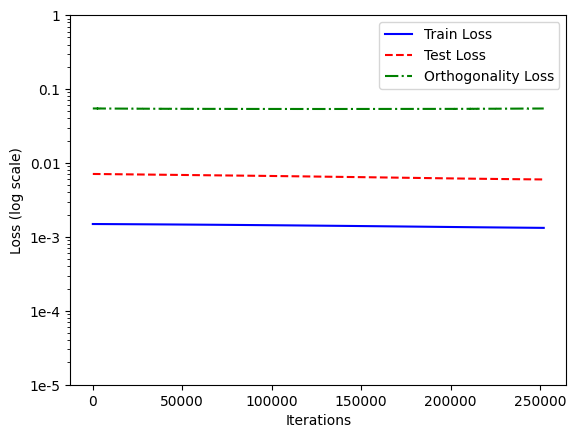

Iteration: 252500 Train_loss:0.001323605771176517, Test_loss: 0.0059839035384356976, ortho_loss:0.054551344364881516
Iteration: 253000 Train_loss:0.0013233028585091233, Test_loss: 0.005982745438814163, ortho_loss:0.0545593798160553


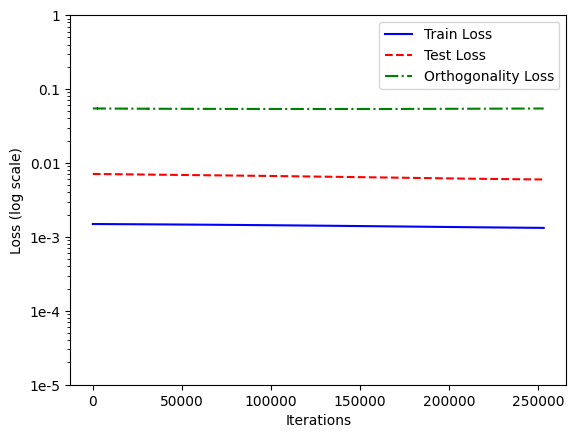

Iteration: 253500 Train_loss:0.0013230042532086372, Test_loss: 0.0059816185384988785, ortho_loss:0.05456966161727905
Iteration: 254000 Train_loss:0.0013227022718638182, Test_loss: 0.005980506539344788, ortho_loss:0.05457335710525513


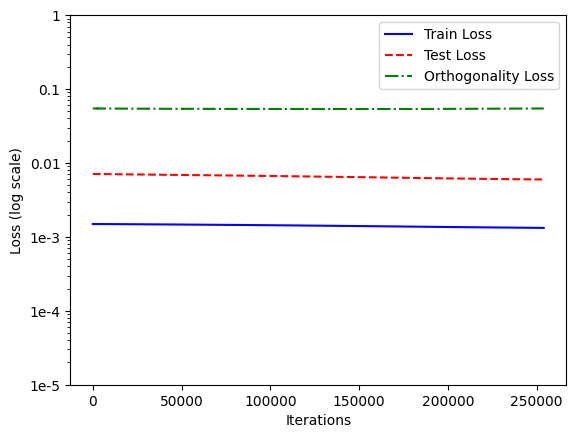

Iteration: 254500 Train_loss:0.001322405063547194, Test_loss: 0.0059794094413518906, ortho_loss:0.05459265038371086
Iteration: 255000 Train_loss:0.0013221087865531445, Test_loss: 0.0059783244505524635, ortho_loss:0.05459647998213768


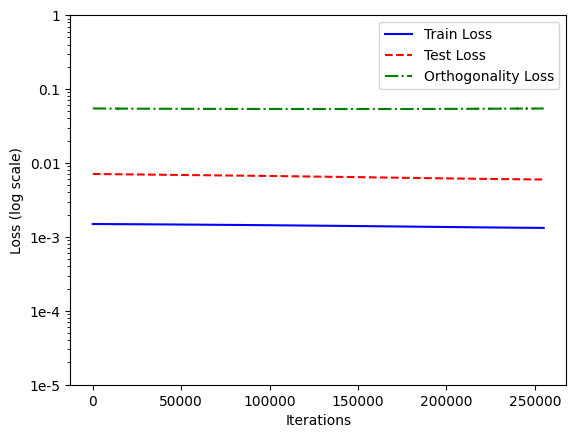

Iteration: 255500 Train_loss:0.0013218132080510259, Test_loss: 0.00597727857530117, ortho_loss:0.0546027310192585
Iteration: 256000 Train_loss:0.001321519142948091, Test_loss: 0.00597622012719512, ortho_loss:0.05460510030388832


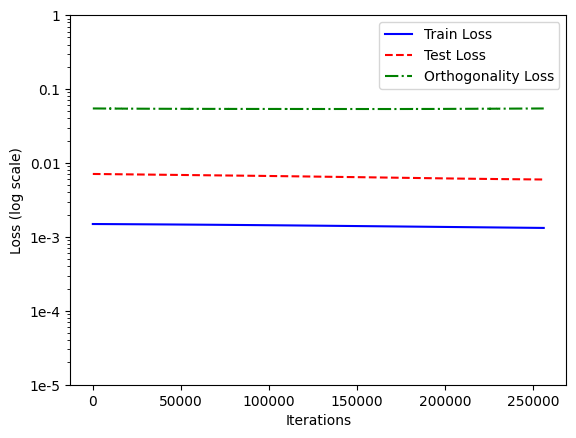

Iteration: 256500 Train_loss:0.0013212281046435237, Test_loss: 0.0059751542285084724, ortho_loss:0.0546104870736599
Iteration: 257000 Train_loss:0.0013209390453994274, Test_loss: 0.0059740906581282616, ortho_loss:0.054617710411548615


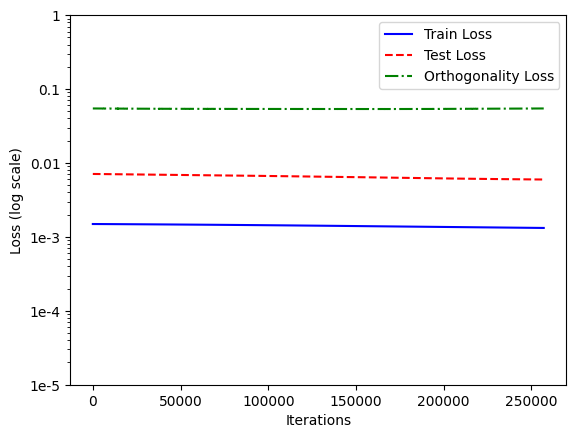

Iteration: 257500 Train_loss:0.0013206425355747342, Test_loss: 0.005973044317215681, ortho_loss:0.054621774703264236
Iteration: 258000 Train_loss:0.0013203633716329932, Test_loss: 0.005972014274448156, ortho_loss:0.054628703743219376


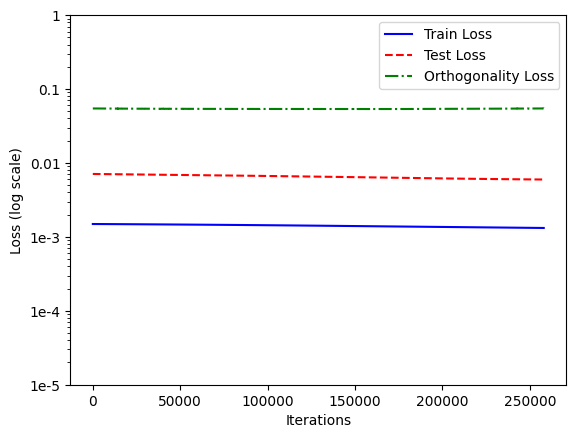

Iteration: 258500 Train_loss:0.0013200734974816442, Test_loss: 0.005970984231680632, ortho_loss:0.05463070049881935
Iteration: 259000 Train_loss:0.0013197886291891336, Test_loss: 0.005969960708171129, ortho_loss:0.0546332411468029


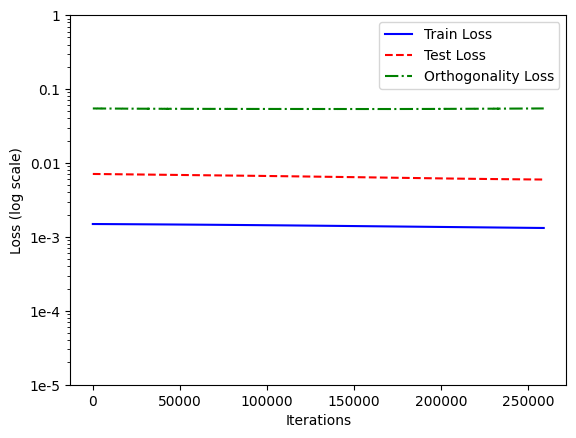

Iteration: 259500 Train_loss:0.0013195037608966231, Test_loss: 0.00596891064196825, ortho_loss:0.05463408678770065
Iteration: 260000 Train_loss:0.0013192174956202507, Test_loss: 0.00596788851544261, ortho_loss:0.054641902446746826


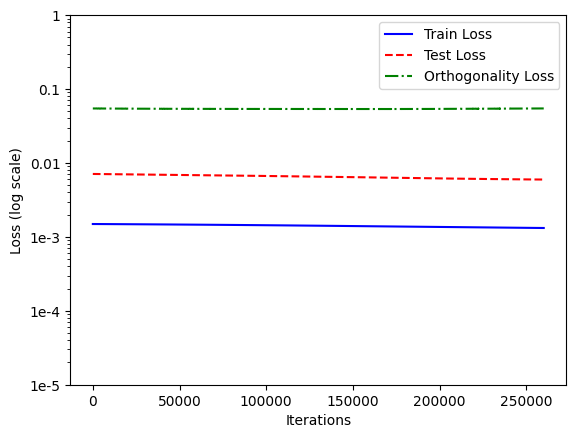

Iteration: 260500 Train_loss:0.001318940776400268, Test_loss: 0.005966866854578257, ortho_loss:0.0546465665102005
Iteration: 261000 Train_loss:0.0013186607975512743, Test_loss: 0.005965821910649538, ortho_loss:0.054643820971250534


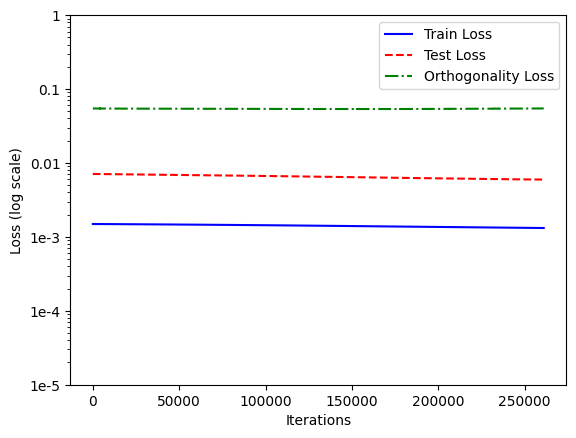

Iteration: 261500 Train_loss:0.001318377093411982, Test_loss: 0.005964812822639942, ortho_loss:0.05465171858668327
Iteration: 262000 Train_loss:0.0013181049143895507, Test_loss: 0.005963822361081839, ortho_loss:0.05465036630630493


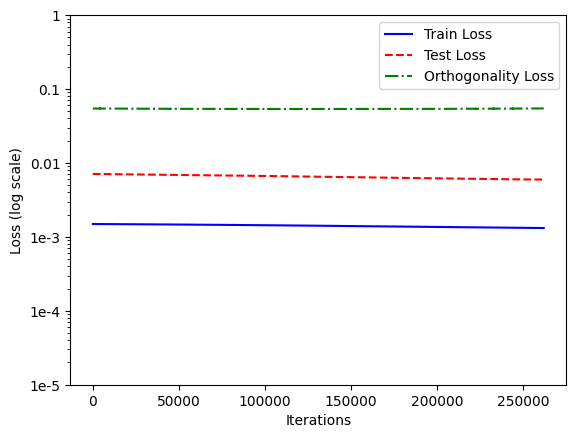

Iteration: 262500 Train_loss:0.0013178271474316716, Test_loss: 0.0059627993032336235, ortho_loss:0.05465978384017944
Iteration: 263000 Train_loss:0.001317550428211689, Test_loss: 0.005961740855127573, ortho_loss:0.054656244814395905


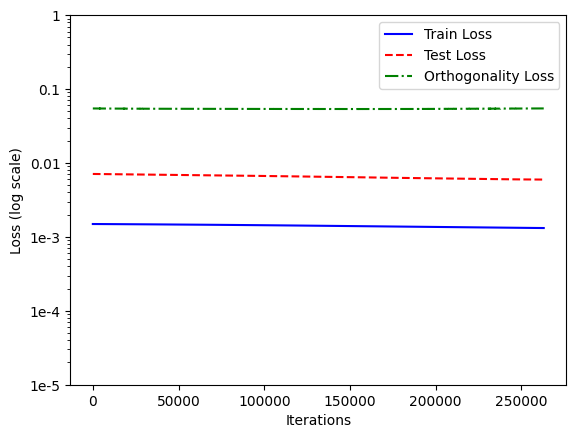

Iteration: 263500 Train_loss:0.001317276037298143, Test_loss: 0.005960662849247456, ortho_loss:0.054661862552165985
Iteration: 264000 Train_loss:0.0013170072343200445, Test_loss: 0.005959582049399614, ortho_loss:0.054663460701704025


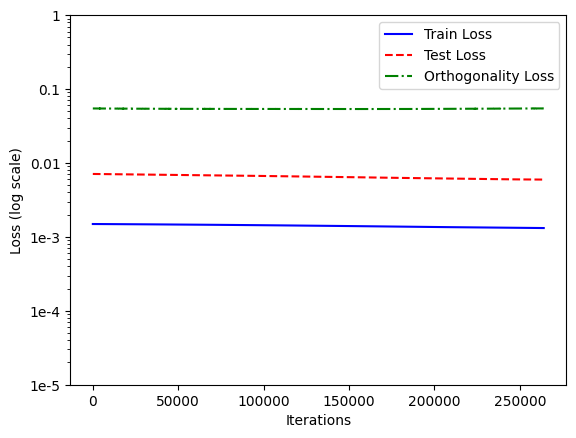

Iteration: 264500 Train_loss:0.0013167372671887279, Test_loss: 0.0059585003182291985, ortho_loss:0.05466151982545853
Iteration: 265000 Train_loss:0.0013164724223315716, Test_loss: 0.005957436747848988, ortho_loss:0.05466718599200249


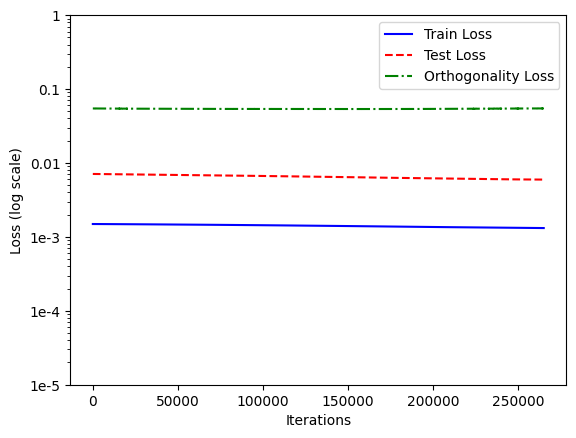

Iteration: 265500 Train_loss:0.001316201756708324, Test_loss: 0.0059563471004366875, ortho_loss:0.054668765515089035
Iteration: 266000 Train_loss:0.0013159348163753748, Test_loss: 0.005955264437943697, ortho_loss:0.05467871576547623


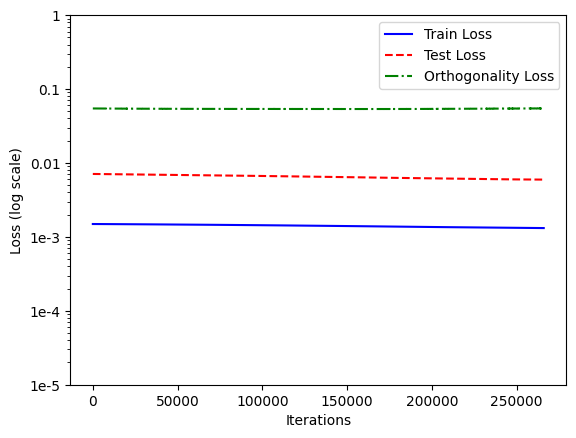

Iteration: 266500 Train_loss:0.0013156674103811383, Test_loss: 0.005954219494014978, ortho_loss:0.05467105656862259
Iteration: 267000 Train_loss:0.001315404544584453, Test_loss: 0.005953188985586166, ortho_loss:0.05467813462018967


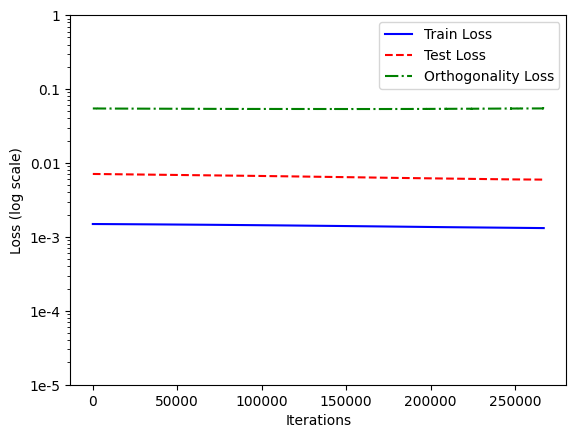

Iteration: 267500 Train_loss:0.0013151417952030897, Test_loss: 0.0059521994553506374, ortho_loss:0.05468282476067543
Iteration: 268000 Train_loss:0.0013148800935596228, Test_loss: 0.005951232276856899, ortho_loss:0.05468559265136719


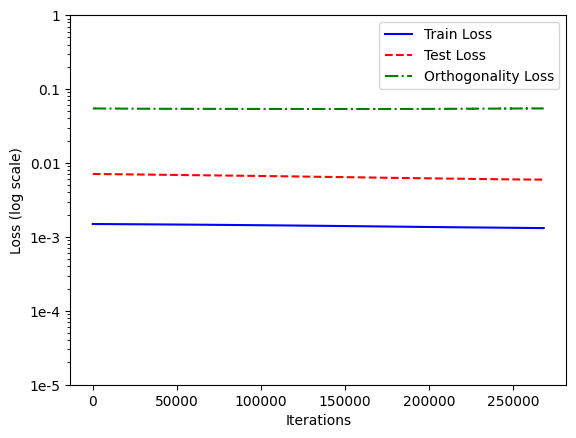

Iteration: 268500 Train_loss:0.0013146200217306614, Test_loss: 0.005950243212282658, ortho_loss:0.05468800291419029
Iteration: 269000 Train_loss:0.0013143657706677914, Test_loss: 0.005949215963482857, ortho_loss:0.05468858778476715


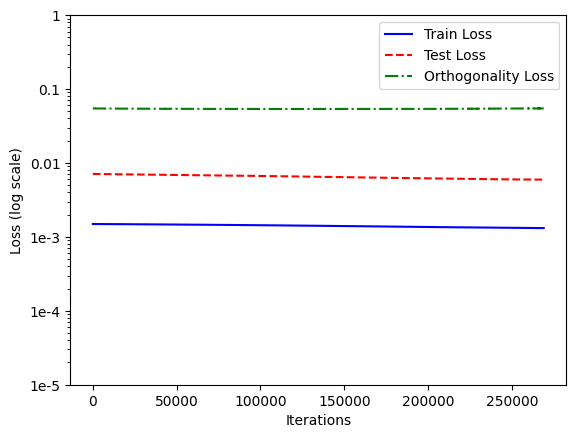

Iteration: 269500 Train_loss:0.0013141053495928645, Test_loss: 0.005948202218860388, ortho_loss:0.05469048395752907
Iteration: 270000 Train_loss:0.001313843415118754, Test_loss: 0.005947088357061148, ortho_loss:0.054697729647159576


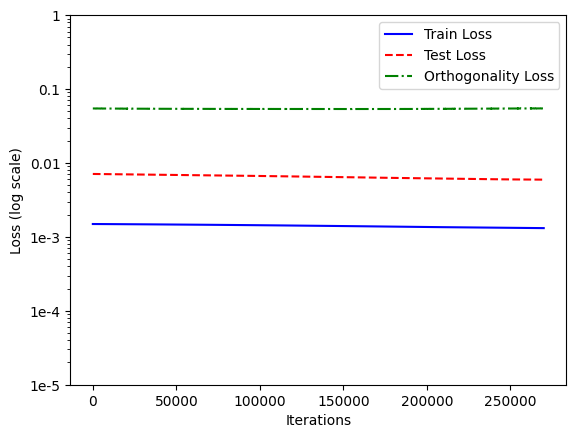

Iteration: 270500 Train_loss:0.0013135882327333093, Test_loss: 0.005946008488535881, ortho_loss:0.05469437688589096
Iteration: 271000 Train_loss:0.0013133358443155885, Test_loss: 0.005944942589849234, ortho_loss:0.05469421297311783


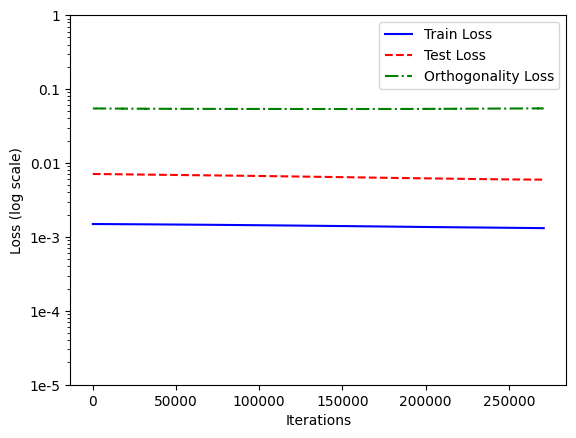

Iteration: 271500 Train_loss:0.00131308869458735, Test_loss: 0.0059438482858240604, ortho_loss:0.054694727063179016
Iteration: 272000 Train_loss:0.0013128304854035378, Test_loss: 0.00594272930175066, ortho_loss:0.054691068828105927


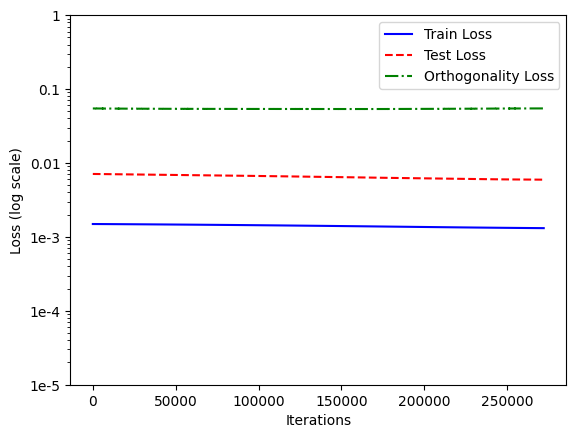

Iteration: 272500 Train_loss:0.0013125801924616098, Test_loss: 0.0059415721334517, ortho_loss:0.05469821020960808
Iteration: 273000 Train_loss:0.0013123322278261185, Test_loss: 0.005940392147749662, ortho_loss:0.054696377366781235


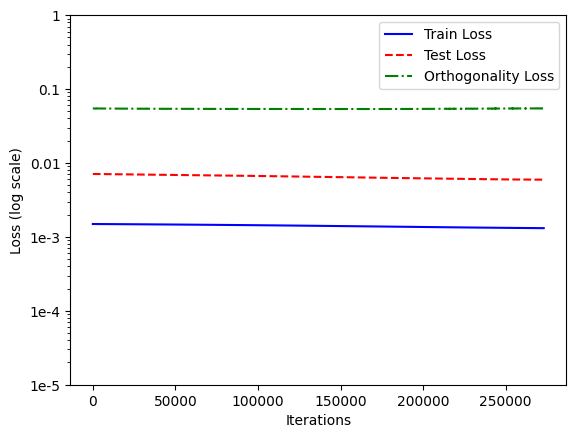

Iteration: 273500 Train_loss:0.0013120821677148342, Test_loss: 0.005939199589192867, ortho_loss:0.054707709699869156
Iteration: 274000 Train_loss:0.0013118353672325611, Test_loss: 0.005938021931797266, ortho_loss:0.054707642644643784


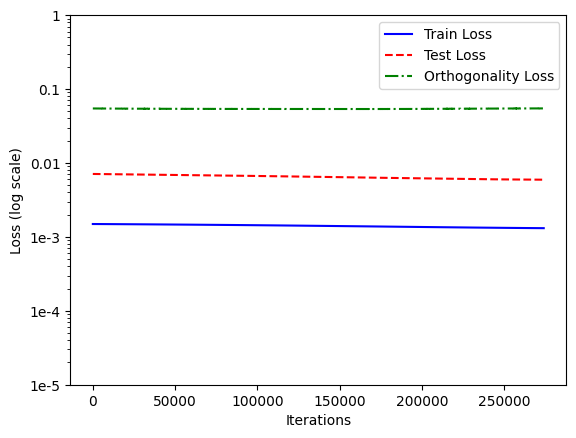

Iteration: 274500 Train_loss:0.0013115924084559083, Test_loss: 0.005936837289482355, ortho_loss:0.05471258983016014
Iteration: 275000 Train_loss:0.0013113470049574971, Test_loss: 0.005935658700764179, ortho_loss:0.054715149104595184


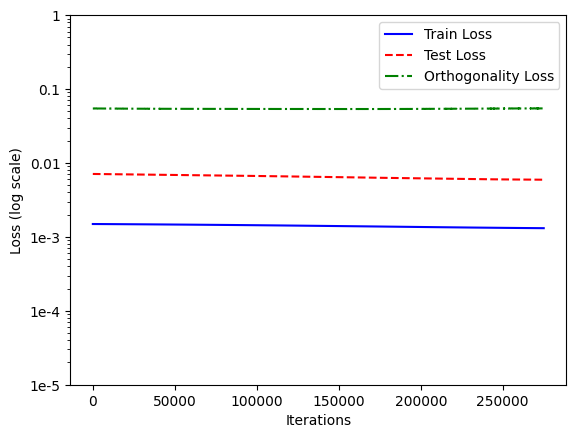

Iteration: 275500 Train_loss:0.0013111007865518332, Test_loss: 0.005934442859143019, ortho_loss:0.05471569299697876
Iteration: 276000 Train_loss:0.001310859457589686, Test_loss: 0.005933194421231747, ortho_loss:0.054718662053346634


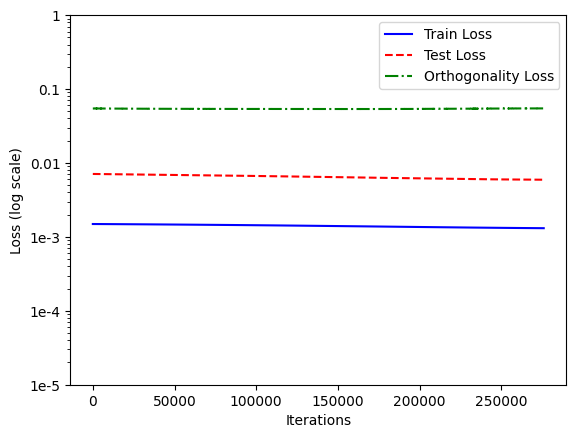

Iteration: 276500 Train_loss:0.0013106174301356077, Test_loss: 0.005931955296546221, ortho_loss:0.0547238327562809
Iteration: 277000 Train_loss:0.0013103842502459884, Test_loss: 0.005930682178586721, ortho_loss:0.0547378733754158


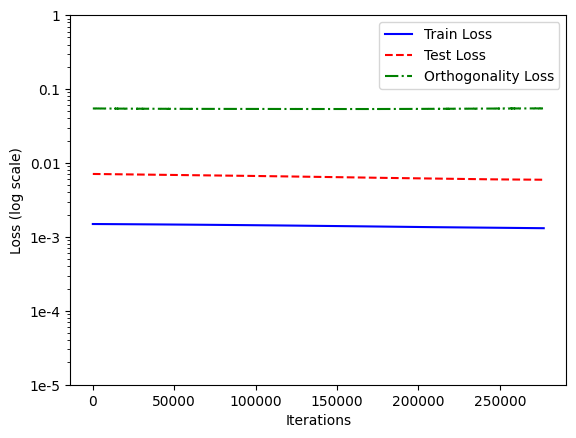

Iteration: 277500 Train_loss:0.0013101445510983467, Test_loss: 0.005929416976869106, ortho_loss:0.05473405122756958
Iteration: 278000 Train_loss:0.0013099027564749122, Test_loss: 0.005928159225732088, ortho_loss:0.05473504960536957


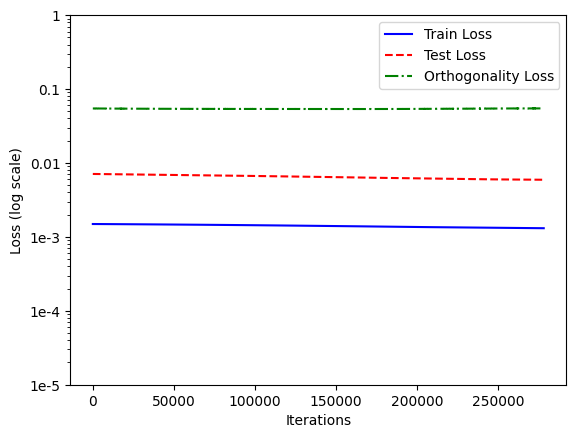

Iteration: 278500 Train_loss:0.0013096644543111324, Test_loss: 0.005926857236772776, ortho_loss:0.05474955216050148
Iteration: 279000 Train_loss:0.0013094322057440877, Test_loss: 0.005925586447119713, ortho_loss:0.054751984775066376


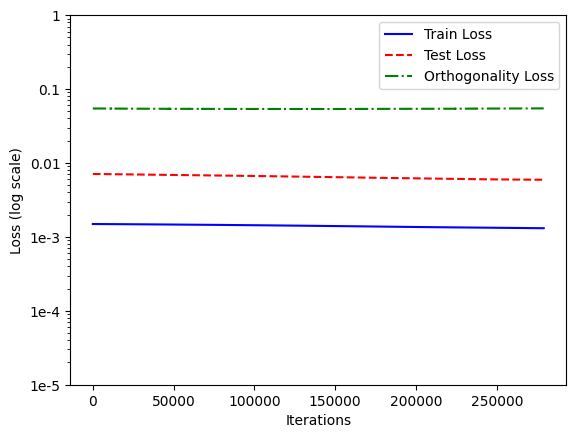

Iteration: 279500 Train_loss:0.0013092007720842957, Test_loss: 0.005924324505031109, ortho_loss:0.05475868657231331
Iteration: 280000 Train_loss:0.0013089695712551475, Test_loss: 0.005923084914684296, ortho_loss:0.05477166920900345


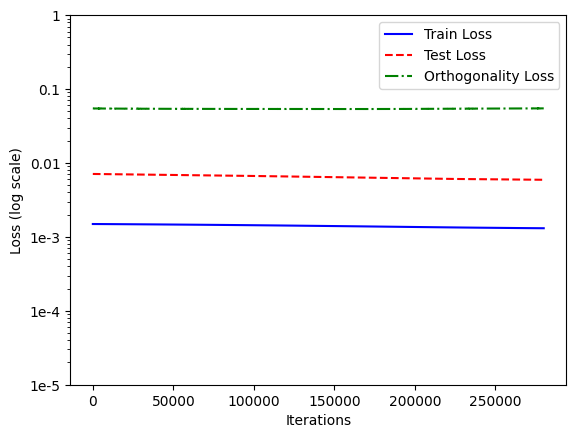

Iteration: 280500 Train_loss:0.0013087335973978043, Test_loss: 0.005921854637563229, ortho_loss:0.05476870387792587
Iteration: 281000 Train_loss:0.0013084972742944956, Test_loss: 0.005920622497797012, ortho_loss:0.05478044971823692


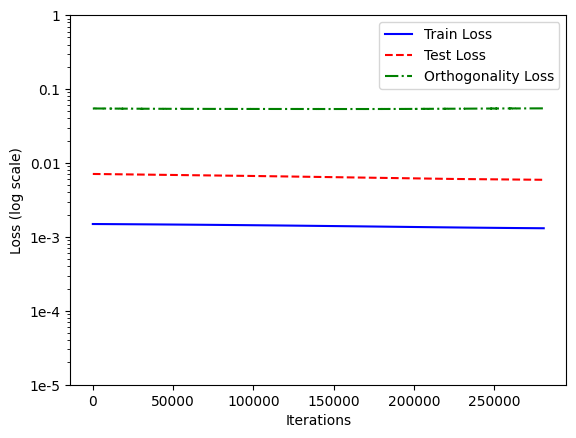

Iteration: 281500 Train_loss:0.0013082694495096803, Test_loss: 0.0059193712659180164, ortho_loss:0.054785847663879395
Iteration: 282000 Train_loss:0.001308042323216796, Test_loss: 0.00591811491176486, ortho_loss:0.054787248373031616


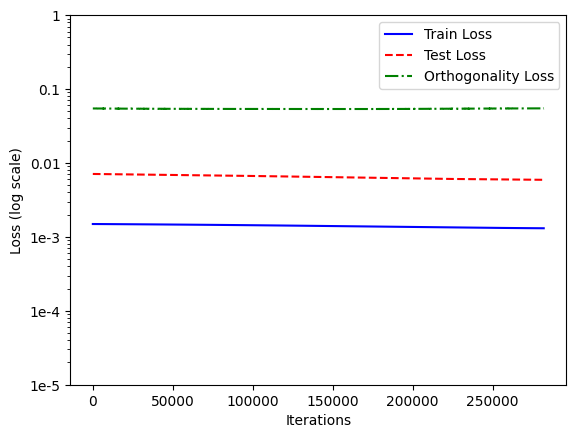

Iteration: 282500 Train_loss:0.0013078184565529227, Test_loss: 0.005916856229305267, ortho_loss:0.0547931008040905
Iteration: 283000 Train_loss:0.0013075872557237744, Test_loss: 0.005915547255426645, ortho_loss:0.05479765310883522


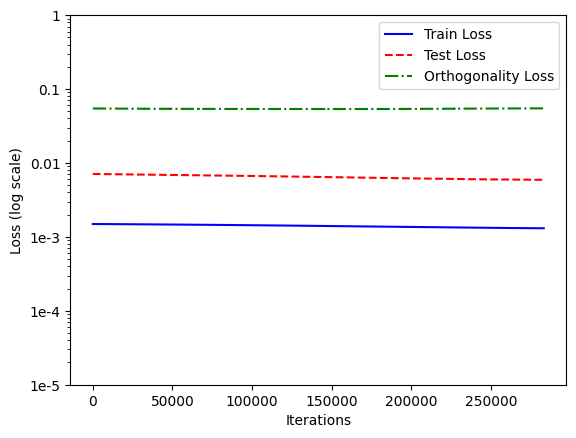

Iteration: 283500 Train_loss:0.001307366299442947, Test_loss: 0.005914241075515747, ortho_loss:0.05480217933654785
Iteration: 284000 Train_loss:0.0013071403373032808, Test_loss: 0.005912954919040203, ortho_loss:0.05480864644050598


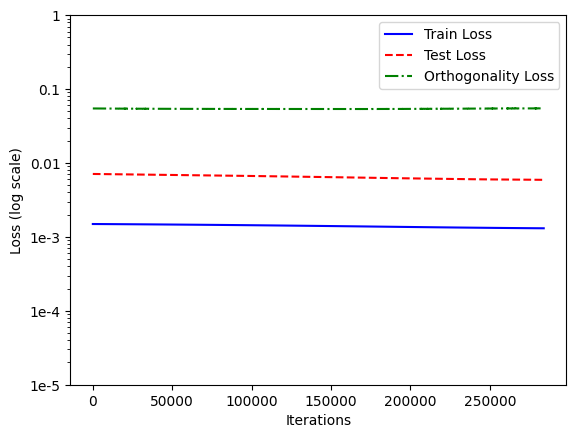

Iteration: 284500 Train_loss:0.0013069225242361426, Test_loss: 0.005911707412451506, ortho_loss:0.054812170565128326
Iteration: 285000 Train_loss:0.0013067004038020968, Test_loss: 0.005910446401685476, ortho_loss:0.05482061207294464


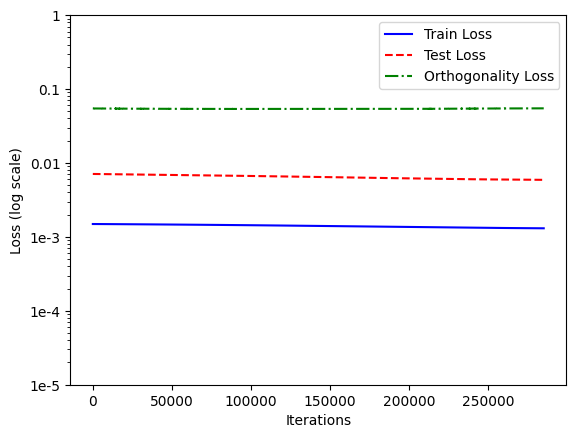

Iteration: 285500 Train_loss:0.0013064757222309709, Test_loss: 0.005909224972128868, ortho_loss:0.054824527353048325
Iteration: 286000 Train_loss:0.0013062591897323728, Test_loss: 0.005908031016588211, ortho_loss:0.05483678728342056


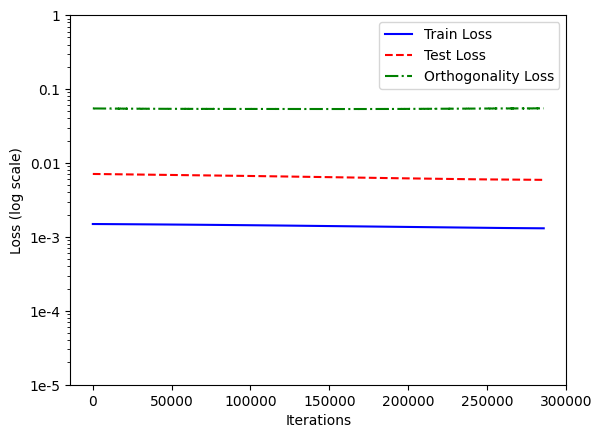

Iteration: 286500 Train_loss:0.0013060442870482802, Test_loss: 0.005906815640628338, ortho_loss:0.054847732186317444
Iteration: 287000 Train_loss:0.00130582379642874, Test_loss: 0.005905632395297289, ortho_loss:0.05485242232680321


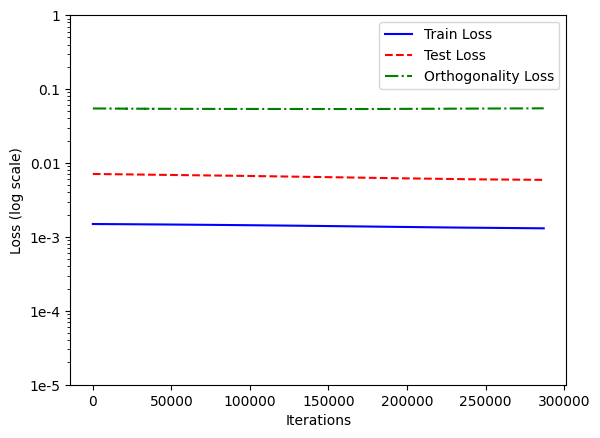

Iteration: 287500 Train_loss:0.0013056093594059348, Test_loss: 0.00590449059382081, ortho_loss:0.05485730245709419
Iteration: 288000 Train_loss:0.0013053977163508534, Test_loss: 0.0059033650904893875, ortho_loss:0.05485177040100098


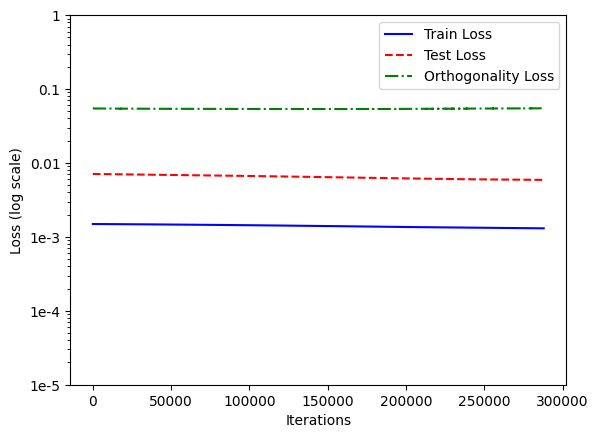

Iteration: 288500 Train_loss:0.0013051879359409213, Test_loss: 0.005902251228690147, ortho_loss:0.05485684424638748
Iteration: 289000 Train_loss:0.0013049781555309892, Test_loss: 0.005901107098907232, ortho_loss:0.05486416816711426


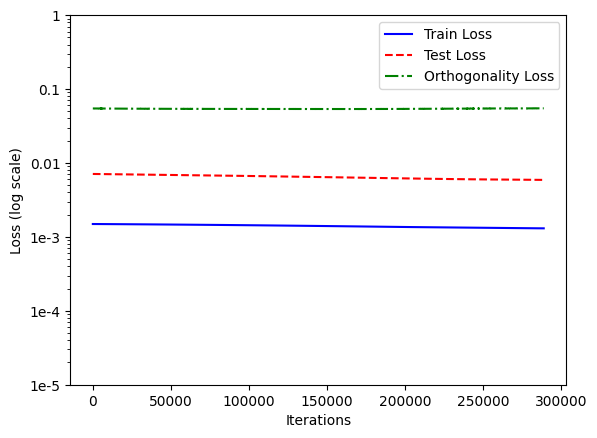

Iteration: 289500 Train_loss:0.0013047631364315748, Test_loss: 0.00589997973293066, ortho_loss:0.05487579479813576
Iteration: 290000 Train_loss:0.0013045530067756772, Test_loss: 0.0058988346718251705, ortho_loss:0.05487794429063797


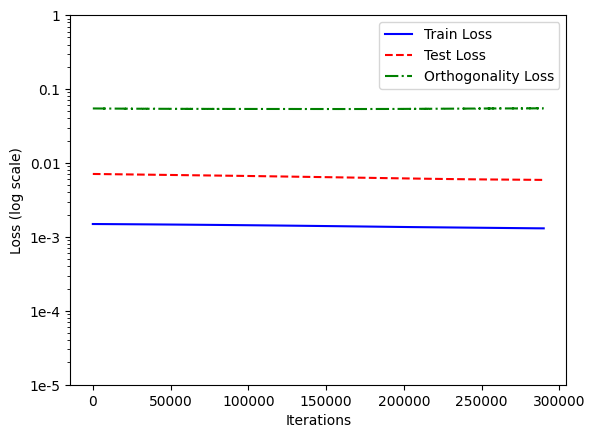

Iteration: 290500 Train_loss:0.001304351375438273, Test_loss: 0.005897717084735632, ortho_loss:0.05488559976220131
Iteration: 291000 Train_loss:0.0013041403144598007, Test_loss: 0.005896597169339657, ortho_loss:0.054888758808374405


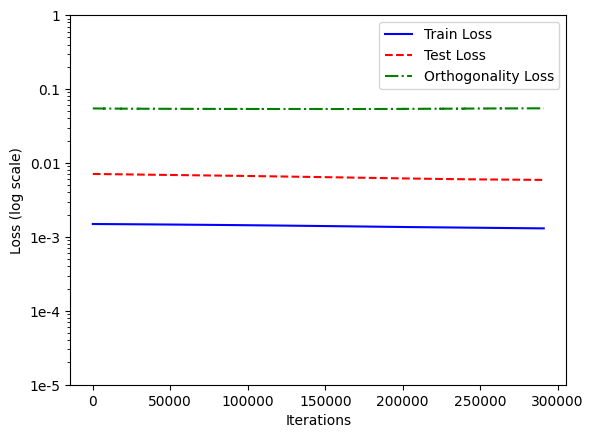

Iteration: 291500 Train_loss:0.001303939032368362, Test_loss: 0.005895525682717562, ortho_loss:0.05488427355885506
Iteration: 292000 Train_loss:0.0013037302996963263, Test_loss: 0.005894478876143694, ortho_loss:0.05489017814397812


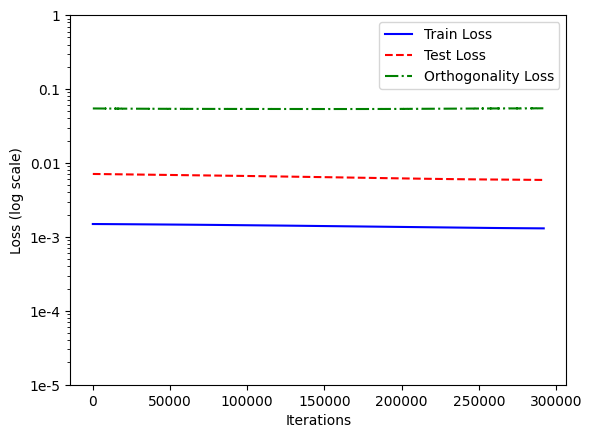

Iteration: 292500 Train_loss:0.0013035309966653585, Test_loss: 0.0058934506960213184, ortho_loss:0.05489426106214523
Iteration: 293000 Train_loss:0.0013033283175900578, Test_loss: 0.005892462097108364, ortho_loss:0.05490216240286827


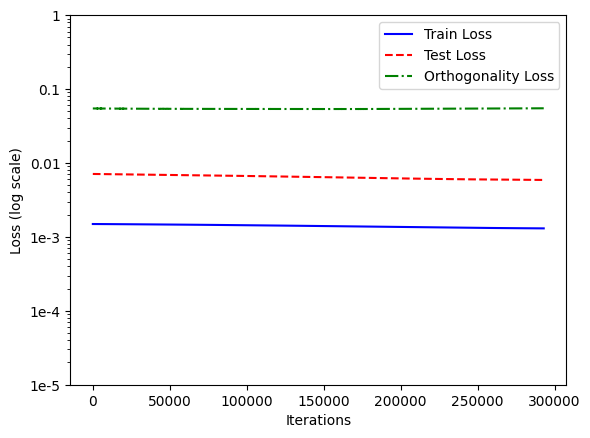

Iteration: 293500 Train_loss:0.001303127151913941, Test_loss: 0.00589150981977582, ortho_loss:0.054897792637348175
Iteration: 294000 Train_loss:0.0013029315741732717, Test_loss: 0.005890547297894955, ortho_loss:0.054904744029045105


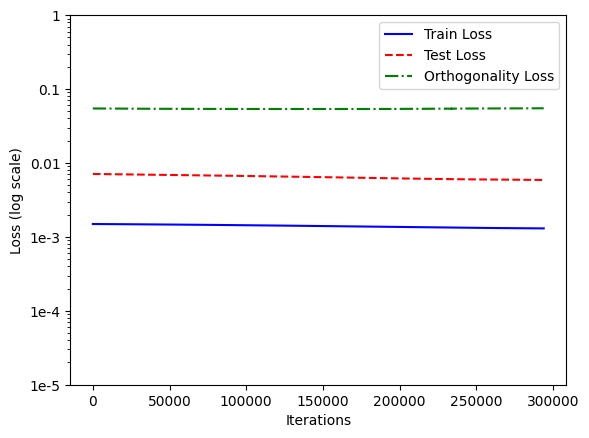

Iteration: 294500 Train_loss:0.0013027336681261659, Test_loss: 0.005889574531465769, ortho_loss:0.05490609630942345
Iteration: 295000 Train_loss:0.0013025443768128753, Test_loss: 0.00588858500123024, ortho_loss:0.05491429194808006


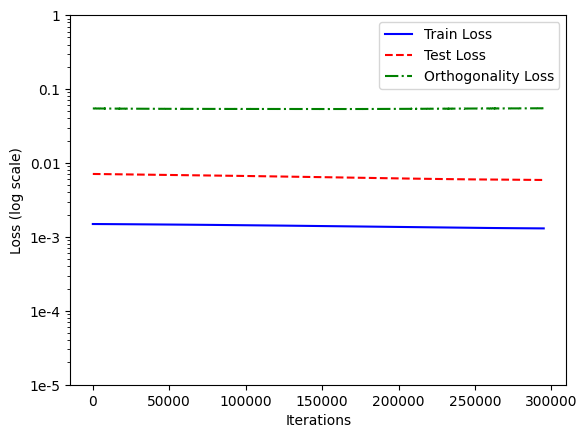

Iteration: 295500 Train_loss:0.0013023421633988619, Test_loss: 0.005887590814381838, ortho_loss:0.054915010929107666
Iteration: 296000 Train_loss:0.0013021534541621804, Test_loss: 0.005886595696210861, ortho_loss:0.05491728335618973


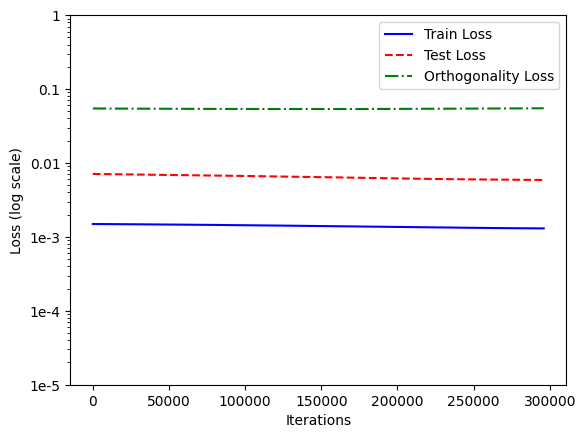

Iteration: 296500 Train_loss:0.0013019585749134421, Test_loss: 0.005885587073862553, ortho_loss:0.05491961911320686
Iteration: 297000 Train_loss:0.0013017640449106693, Test_loss: 0.00588459987193346, ortho_loss:0.054927241057157516


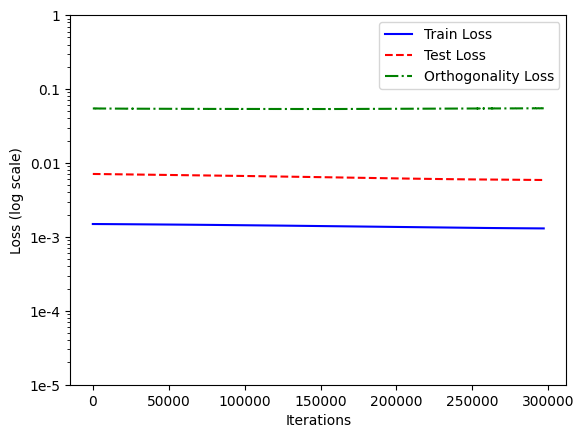

Iteration: 297500 Train_loss:0.0013015762669965625, Test_loss: 0.005883637350052595, ortho_loss:0.05492692068219185
Iteration: 298000 Train_loss:0.001301392214372754, Test_loss: 0.005882665980607271, ortho_loss:0.05492802709341049


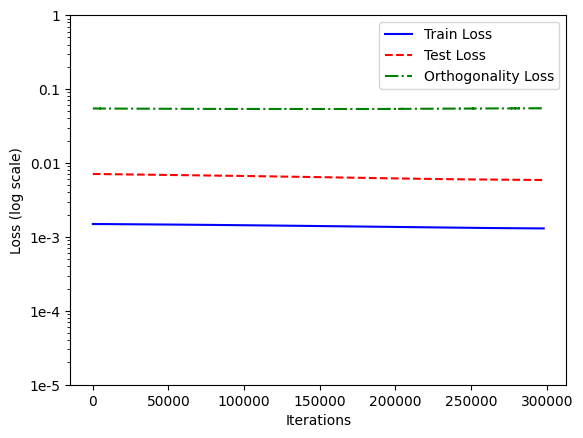

Iteration: 298500 Train_loss:0.0013011941919103265, Test_loss: 0.005881750490516424, ortho_loss:0.054929014295339584
Iteration: 299000 Train_loss:0.001301012933254242, Test_loss: 0.005880868993699551, ortho_loss:0.05492480471730232


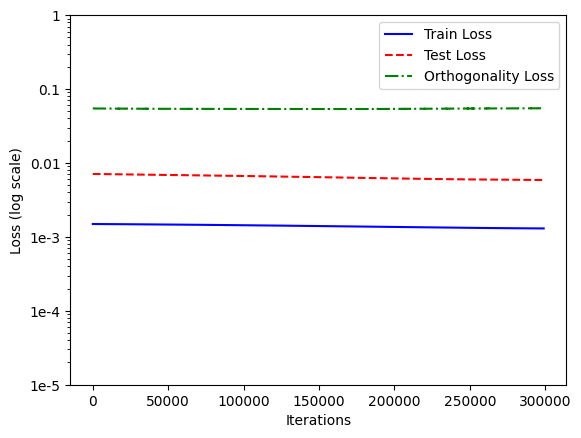

Iteration: 299500 Train_loss:0.0013008314417675138, Test_loss: 0.005879998207092285, ortho_loss:0.05492634326219559
Iteration: 300000 Train_loss:0.0013006443623453379, Test_loss: 0.005879153963178396, ortho_loss:0.0549304336309433


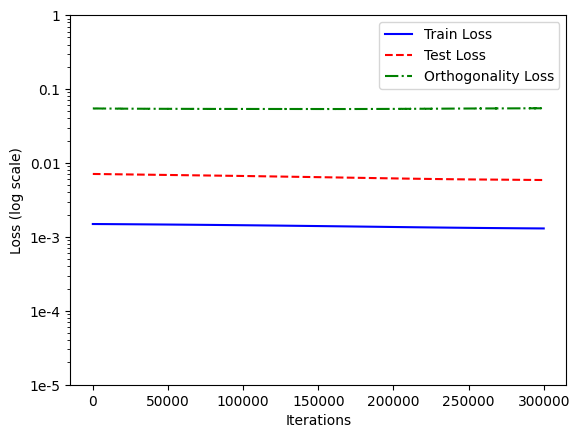

Iteration: 300500 Train_loss:0.0013004643842577934, Test_loss: 0.005878297612071037, ortho_loss:0.054931219667196274
Iteration: 301000 Train_loss:0.0013002820778638124, Test_loss: 0.005877440329641104, ortho_loss:0.05493112653493881


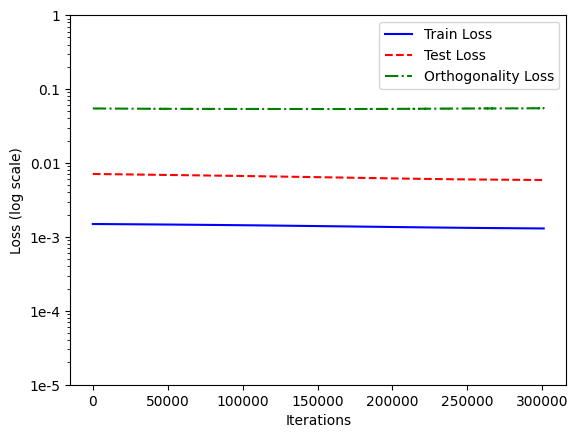

Iteration: 301500 Train_loss:0.0013000996550545096, Test_loss: 0.005876609589904547, ortho_loss:0.054941754788160324
Iteration: 302000 Train_loss:0.0012999239843338728, Test_loss: 0.005875790026038885, ortho_loss:0.054946258664131165


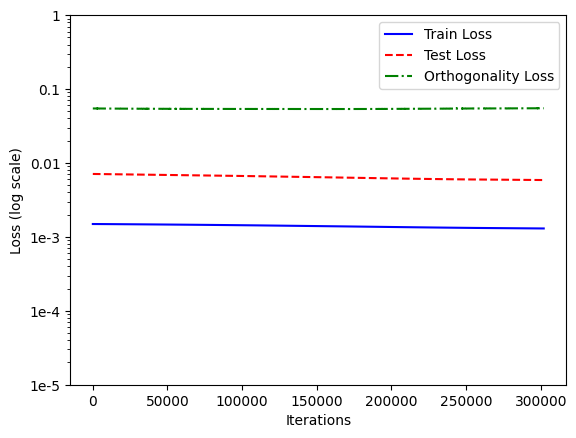

Iteration: 302500 Train_loss:0.0012997392332181334, Test_loss: 0.005874963011592627, ortho_loss:0.05494869500398636
Iteration: 303000 Train_loss:0.001299572642892599, Test_loss: 0.005874128546565771, ortho_loss:0.05495154857635498


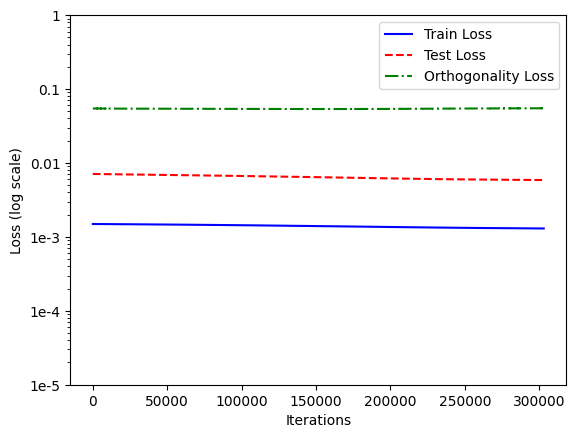

Iteration: 303500 Train_loss:0.0012993902200832963, Test_loss: 0.0058732652105391026, ortho_loss:0.05495382845401764
Iteration: 304000 Train_loss:0.0012992145493626595, Test_loss: 0.005872386507689953, ortho_loss:0.05495463311672211


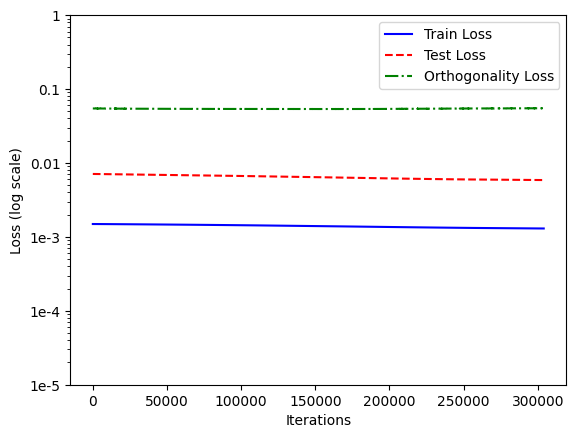

Iteration: 304500 Train_loss:0.0012990356190130115, Test_loss: 0.005871486384421587, ortho_loss:0.05495762079954147
Iteration: 305000 Train_loss:0.0012988653033971786, Test_loss: 0.005870564840734005, ortho_loss:0.05495684966444969


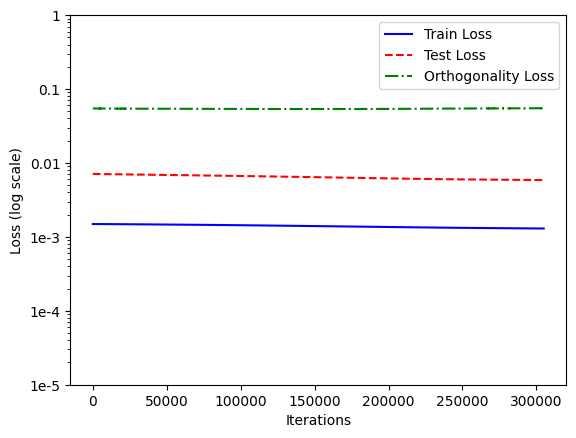

Iteration: 305500 Train_loss:0.0012986910296604037, Test_loss: 0.0058695911429822445, ortho_loss:0.05495842918753624
Iteration: 306000 Train_loss:0.0012985204812139273, Test_loss: 0.005868600215762854, ortho_loss:0.054961834102869034


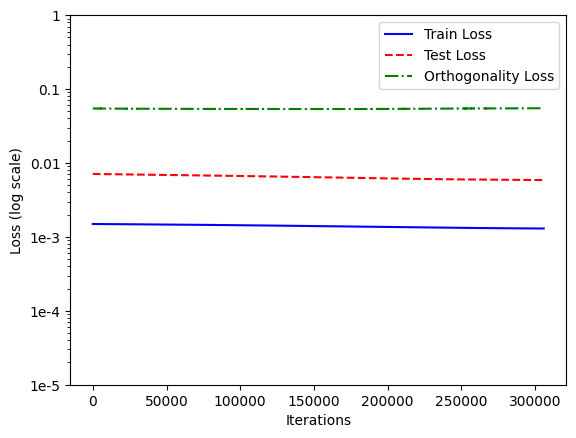

Iteration: 306500 Train_loss:0.0012983474880456924, Test_loss: 0.005867595784366131, ortho_loss:0.05496639758348465
Iteration: 307000 Train_loss:0.0012981797335669398, Test_loss: 0.005866604391485453, ortho_loss:0.054961349815130234


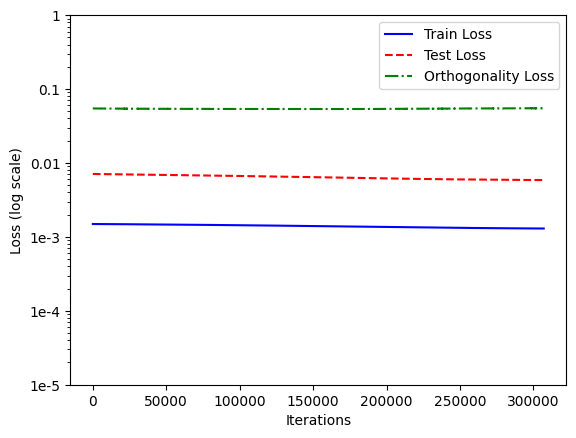

Iteration: 307500 Train_loss:0.001298003364354372, Test_loss: 0.005865597166121006, ortho_loss:0.054960280656814575
Iteration: 308000 Train_loss:0.0012978402664884925, Test_loss: 0.005864556413143873, ortho_loss:0.05497000366449356


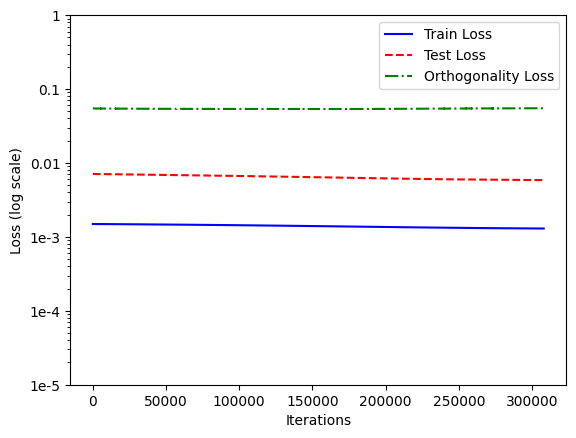

Iteration: 308500 Train_loss:0.0012976700672879815, Test_loss: 0.005863522179424763, ortho_loss:0.054975725710392
Iteration: 309000 Train_loss:0.001297501614317298, Test_loss: 0.0058625126257538795, ortho_loss:0.05498296767473221


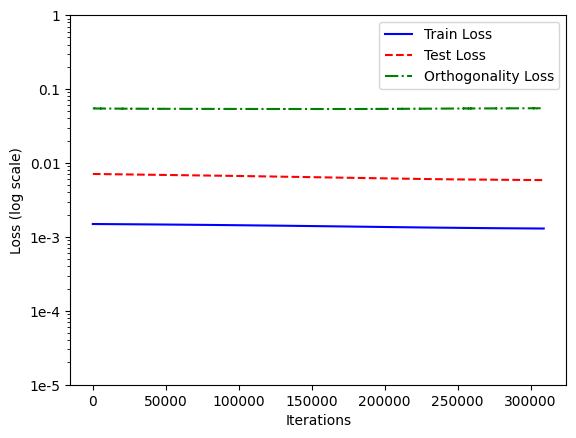

Iteration: 309500 Train_loss:0.0012973343254998326, Test_loss: 0.005861517041921616, ortho_loss:0.05498158186674118
Iteration: 310000 Train_loss:0.0012971709948033094, Test_loss: 0.005860540084540844, ortho_loss:0.054988015443086624


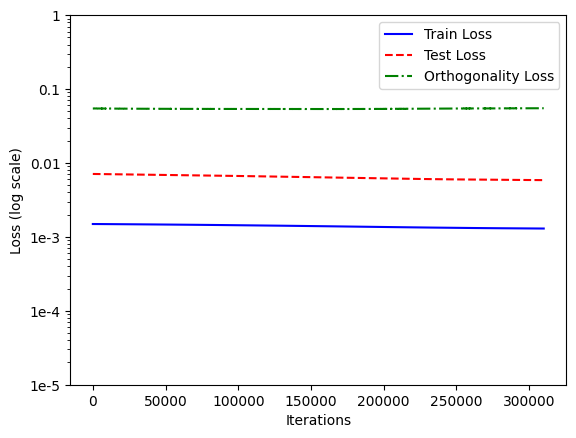

Iteration: 310500 Train_loss:0.0012970039388164878, Test_loss: 0.005859565455466509, ortho_loss:0.05499130114912987
Iteration: 311000 Train_loss:0.0012968472437933087, Test_loss: 0.005858610849827528, ortho_loss:0.05499434098601341


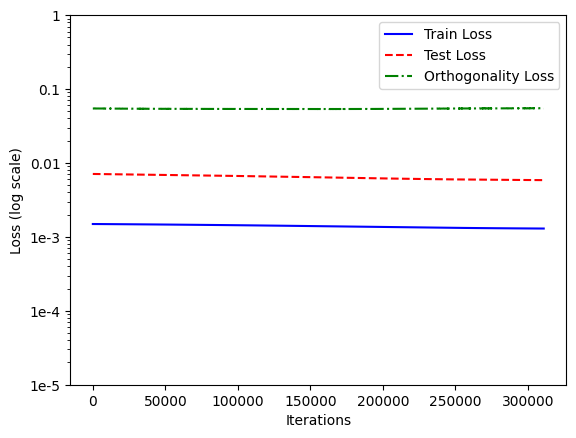

Iteration: 311500 Train_loss:0.00129668228328228, Test_loss: 0.005857636220753193, ortho_loss:0.05500435456633568
Iteration: 312000 Train_loss:0.0012965223286300898, Test_loss: 0.005856677424162626, ortho_loss:0.05501099303364754


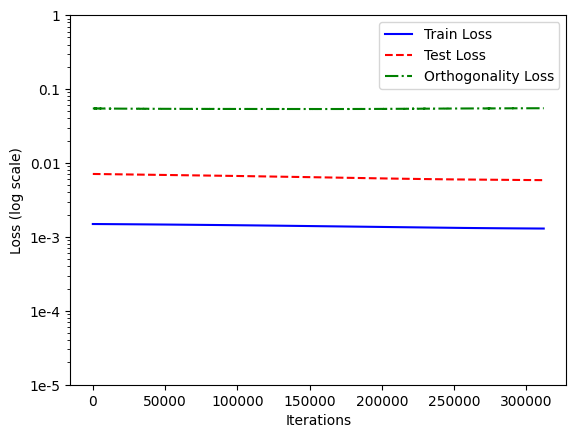

Iteration: 312500 Train_loss:0.0012963624903932214, Test_loss: 0.005855700001120567, ortho_loss:0.05501116067171097
Iteration: 313000 Train_loss:0.0012961969478055835, Test_loss: 0.005854736547917128, ortho_loss:0.05502491816878319


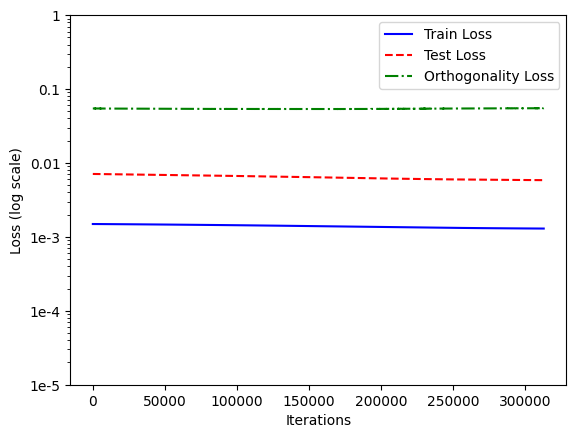

Iteration: 313500 Train_loss:0.0012960390886291862, Test_loss: 0.005853785667568445, ortho_loss:0.05502920225262642
Iteration: 314000 Train_loss:0.0012958800652995706, Test_loss: 0.005852802656590939, ortho_loss:0.055040281265974045


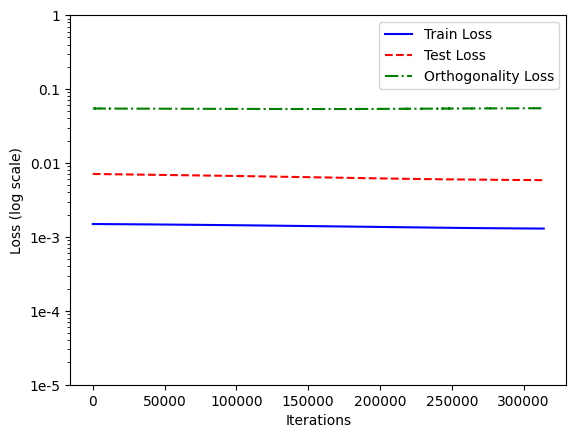

Iteration: 314500 Train_loss:0.0012957288417965174, Test_loss: 0.00585183734074235, ortho_loss:0.05505199357867241
Iteration: 315000 Train_loss:0.0012955776182934642, Test_loss: 0.005850826855748892, ortho_loss:0.0550578348338604


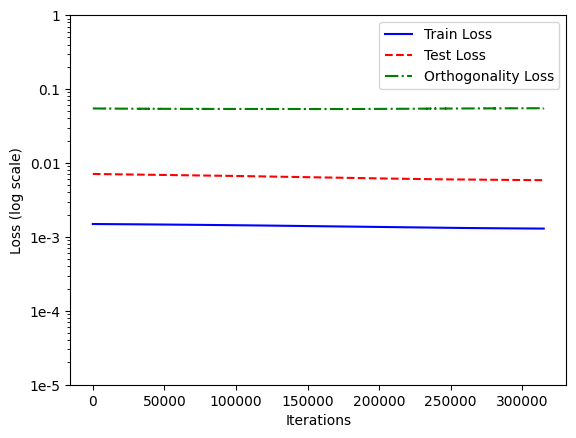

Iteration: 315500 Train_loss:0.0012954163830727339, Test_loss: 0.005849814973771572, ortho_loss:0.0550597608089447
Iteration: 316000 Train_loss:0.0012952681863680482, Test_loss: 0.0058488124050199986, ortho_loss:0.05505935102701187


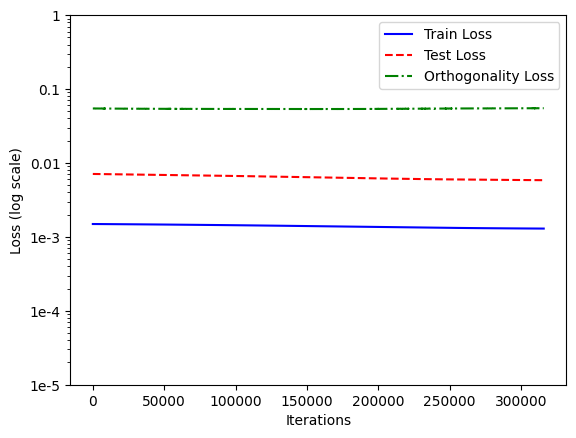

Iteration: 316500 Train_loss:0.0012951152166351676, Test_loss: 0.0058478135615587234, ortho_loss:0.05506671592593193
Iteration: 317000 Train_loss:0.0012949620140716434, Test_loss: 0.00584679190069437, ortho_loss:0.05507323890924454


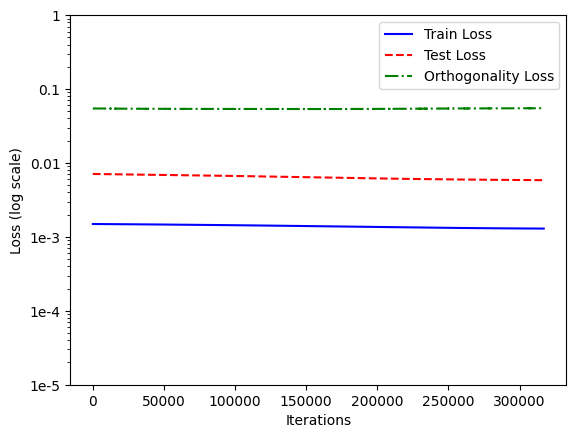

Iteration: 317500 Train_loss:0.0012948099756613374, Test_loss: 0.0058457935228943825, ortho_loss:0.055072300136089325
Iteration: 318000 Train_loss:0.0012946571223437786, Test_loss: 0.0058447509072721004, ortho_loss:0.055085666477680206


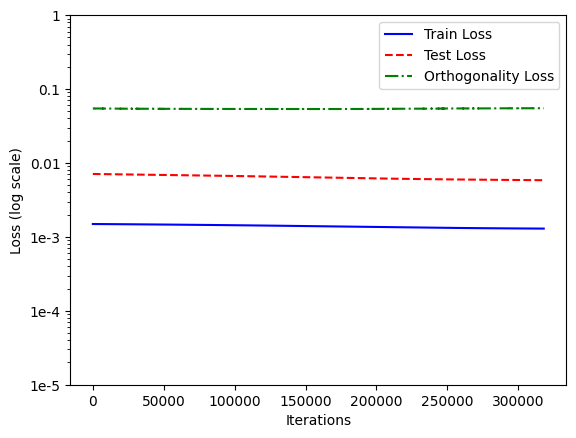

Iteration: 318500 Train_loss:0.0012945070629939437, Test_loss: 0.0058436947874724865, ortho_loss:0.0550907626748085
Iteration: 319000 Train_loss:0.001294360845349729, Test_loss: 0.005842625629156828, ortho_loss:0.055091746151447296


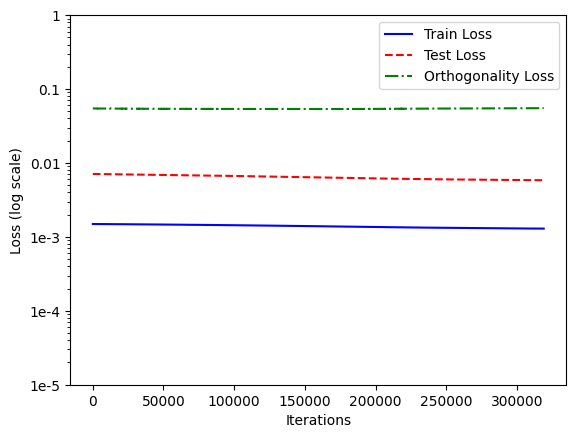

Iteration: 319500 Train_loss:0.0012942134635522962, Test_loss: 0.005841558333486319, ortho_loss:0.05508788675069809
Iteration: 320000 Train_loss:0.001294062240049243, Test_loss: 0.00584048917517066, ortho_loss:0.05509354919195175


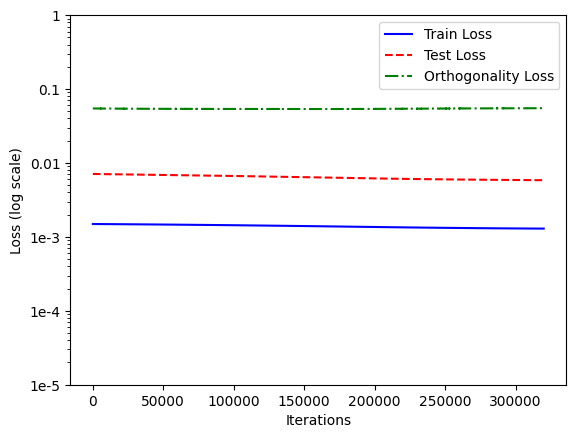

Iteration: 320500 Train_loss:0.0012939204461872578, Test_loss: 0.005839476361870766, ortho_loss:0.05509395897388458
Iteration: 321000 Train_loss:0.0012937703868374228, Test_loss: 0.005838459823280573, ortho_loss:0.05510033294558525


In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

n = 0
nmax = 2000000
lr = 1e-3
start_time = time.perf_counter()
time_step_0 = time.perf_counter()
l2_reg_strength = 1e-6  # You can adjust this value


#optimizer = optim.Adam(list(W_branch) + list(b_branch) + list(W_trunk) + list(b_trunk), lr=lr,  weight_decay=l2_reg_strength)
optimizer = optim.SGD(list(W_branch) + list(b_branch) + list(W_trunk) + list(b_trunk), lr=lr,  weight_decay=l2_reg_strength)
scheduler = ReduceLROnPlateau(optimizer=optimizer)


data_loss_list = []
loss_ortho_list = []
train_err_list = []
test_err_list = []
train_loss_list = []
test_loss_list = []

try:
    while n <= nmax:
        x_train_tensor = torch.from_numpy(x_y_train).float()
        x_train_tensor.requires_grad_(True)
        v_train_tensor = torch.from_numpy(v_train).float()
        u_train_tensor = torch.from_numpy(u_train).float()

        loss_train, u_train_pred, loss_ortho, data_loss = train_step(model, W_branch, b_branch, W_trunk,
                                              b_trunk, v_train_tensor, x_train_tensor, u_train_tensor,
                                              optimizer)
        #loss_train, u_train_pred, data_loss = train_step(model, W_branch, b_branch, W_trunk,
                                              #b_trunk, v_train_tensor, x_train_tensor, u_train_tensor,
                                              #optimizer)




        #     #err_train = np.mean(np.linalg.norm(u_train - u_train_pred, 2, axis=1) /
        #                         np.linalg.norm(u_train, 2, axis=1))

        u_train_pred_np = u_train_pred.detach().numpy()

        err_train = np.mean(np.linalg.norm(u_train - u_train_pred_np, 2, axis=1) /
                            np.linalg.norm(u_train, 2, axis=1))

        loss_test, u_test_pred = test_step(model, W_branch, b_branch, W_trunk, b_trunk, v_test, x_y_test, u_test,
                                           optimizer)
        err_test = np.mean(np.linalg.norm(u_test - u_test_pred, 2, axis=1) /
                           np.linalg.norm(u_test, 2, axis=1))

        if n % 500 == 0:
            print(f"Iteration: {n} Train_loss:{loss_train}, Test_loss: {loss_test}, ortho_loss:{abs(loss_ortho)}")
            #print(f"Iteration: {n} Train_loss:{loss_train}, ortho_loss:{abs(loss_ortho)}")

        train_err_list.append(err_train)
        test_err_list.append(err_test)
        train_loss_list.append(loss_train)
        test_loss_list.append(loss_test)
        loss_ortho_list.append(loss_ortho)
        data_loss_list.append(data_loss)

        if n % 1000 == 0:
            gs = gridspec.GridSpec(1, 1)
            ax = plt.subplot(gs[:, :])
            plt.semilogy(range(len(train_loss_list)), train_loss_list, 'b-', label='Train Loss')
            plt.semilogy(range(len(test_loss_list)), test_loss_list, 'r--', label='Test Loss')
            plt.semilogy(range(len(loss_ortho_list)), loss_ortho_list, 'g-.', label='Orthogonality Loss')


            #plt.plot(range(len(train_loss_list)), train_loss_list, 'b-', label='Train Loss')
            #plt.plot(range(len(test_loss_list)), test_loss_list, 'r--', label='Test Loss')
            #plt.semilogy(range(len(pde_loss_list)), pde_loss_list, 'g-.', label='PDE_t Loss')
            #plt.semilogy(range(len(data_loss_list)), data_loss_list, 'm:', label='Data_t loss')

            plt.xlabel('Iterations')
            plt.ylabel('Loss (log scale)')

            # Set the y-axis ticks and labels using a logarithmic scale
            yticks = [ 10 ** -5, 10 ** -4, 10 ** -3, 10 ** -2, 10 ** -1, 10 ** 0]
            yticklabels = [ '1e-5', '1e-4', '1e-3', '0.01', '0.1', '1']
            plt.yticks(yticks, yticklabels)
            # Set the y-axis limits
            ax.set_ylim([10 ** -5, 1])

            plt.legend()
            plt.show()


        n = n + 1

except KeyboardInterrupt:
    print("Training interrupted. Saving the model...")

In [ ]:
u_test_pred[-1, :]

array([ 0.01559211, -0.01221691, -0.05992101,  0.00703168,  0.02512234,
        0.01264007, -0.00951954, -0.0055464 , -0.00249657,  0.00191519,
       -0.04593698, -0.00468341, -0.02268459,  0.01598892, -0.05342331,
       -0.00293403,  0.00999282,  0.01899476, -0.02321159, -0.00512604,
       -0.00580696,  0.01923436,  0.05697231, -0.01618066,  0.01698001,
        0.00083934,  0.03523774,  0.0607039 , -0.02522023, -0.05332609,
        0.05886846,  0.04018289, -0.00701531, -0.00601098, -0.00086329,
        0.03119786,  0.07636118,  0.023768  ,  0.0031681 ,  0.00738848],
      dtype=float32)